# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
import torch
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Joe Copula and add Gaussian marginals. Feel free to exchange the copula parameter, the rotation or even the copula itsself.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [2]:
#copula_pv = pv.Bicop(family=pv.BicopFamily.indep)
copula_pv = pv.Bicop(family=pv.BicopFamily.joe, parameters=np.array([[2.5]]), rotation=90)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [3]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

/tmp/ipykernel_3297271/2085715786.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/tmp/ipykernel_3297271/2085715786.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/tmp/ipykernel_3297271/2085715786.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_da

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [4]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

In [5]:
loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [6]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_test)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_test)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [22]:
hyperparameters = {
    "transformation": {
    "sigma_a": 2.1, "sigma_b": 1e6,        #Ignored not used
    "RW2": { "tau_a": 1.1, "tau_b": 10 },  #E[λ_T] = sehr groß  (smooth but not stiff)
    "RW1": { "tau_a": 10.0,"tau_b": 15.0 }  #Ignored not used
    },
    "decorrelation": {
    "sigma_a": 2.1, "sigma_b": -1e6,              # mean σ² = very small close to 0 (weak)
    "RW2": { "tau_a": 1.5, "tau_b": 0.01 },      # E[κ2] ≈ 0.05   (weak curvature smoothing)
    "RW1": { "tau_a": 1.5, "tau_b": 0.01 },      # E[κ1] ≈ 0.10   (light shrink to linear)
    }
}



model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=0,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

model.transform_only = True
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
_=model

The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [23]:
output = model.pretrain_transformation_layer(
                train_dataloader=dataloader_train,
                validate_dataloader=dataloader_validate,
                hyperparameters=None,
                iterations=1000,
                #verbose=True,
                learning_rate=0.01,
                mcmc_sample_train=4,            # will ramp
                mcmc_sample_val=16,             # fixed & larger for stable eval
                mc_ramp_every=10,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                patience=15,                # early-stop patience
                min_delta=0.001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=2,          # slightly faster variance adaption (optional)
                sched_factor=0.5, sched_patience=6, sched_threshold=1e-4,
            )

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
  0%|          | 2/1000 [00:00<03:00,  5.52it/s]

[1/1000] train=38.2376  val=38.8367  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0510 σmin=0.0510 σmax=0.0510   tau4=0.1995497685 rank=20  E_qf≈0.0896  tau*E[qf]≈0.01787  Δ=+8.95e-02
[2/1000] train=37.1456  val=38.3680  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0520 σmin=0.0520 σmax=0.0520   tau4=0.2801445608 rank=20  E_qf≈0.0896  tau*E[qf]≈0.02509  Δ=+8.06e-02


  0%|          | 4/1000 [00:00<02:51,  5.80it/s]

[3/1000] train=39.3605  val=37.8998  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0530 σmin=0.0530 σmax=0.0530   tau4=0.3526798738 rank=20  E_qf≈0.0896  tau*E[qf]≈0.03158  Δ=+7.25e-02
[4/1000] train=39.0601  val=37.4321  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0541 σmin=0.0541 σmax=0.0541   tau4=0.4179616555 rank=20  E_qf≈0.0896  tau*E[qf]≈0.03743  Δ=+6.53e-02


  1%|          | 6/1000 [00:01<02:49,  5.88it/s]

[5/1000] train=35.1963  val=36.9652  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0551 σmin=0.0551 σmax=0.0551   tau4=0.476715259 rank=20  E_qf≈0.0896  tau*E[qf]≈0.04269  Δ=+5.88e-02
[6/1000] train=34.1810  val=36.4987  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0562 σmin=0.0562 σmax=0.0562   tau4=0.5295935022 rank=20  E_qf≈0.0896  tau*E[qf]≈0.04743  Δ=+5.29e-02


  1%|          | 8/1000 [00:01<02:46,  5.95it/s]

[7/1000] train=35.9753  val=36.0314  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0573 σmin=0.0573 σmax=0.0573   tau4=0.577183921 rank=20  E_qf≈0.0896  tau*E[qf]≈0.05169  Δ=+4.76e-02
[8/1000] train=34.6244  val=35.5644  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0584 σmin=0.0584 σmax=0.0584   tau4=0.620015298 rank=20  E_qf≈0.0896  tau*E[qf]≈0.05552  Δ=+4.28e-02


  1%|          | 10/1000 [00:01<02:45,  5.98it/s]

[9/1000] train=36.8746  val=35.0978  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0596 σmin=0.0596 σmax=0.0596   tau4=0.6585635373 rank=20  E_qf≈0.0896  tau*E[qf]≈0.05898  Δ=+3.85e-02
[10/1000] train=34.3047  val=34.6318  S_train=4 S_val=16 lr=[0.01, 0.02] σ̄=0.0607 σmin=0.0607 σmax=0.0607   tau4=0.6932569526 rank=20  E_qf≈0.0896  tau*E[qf]≈0.06208  Δ=+3.47e-02


  1%|          | 11/1000 [00:01<02:59,  5.50it/s]

[11/1000] train=36.4357  val=34.1659  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0619 σmin=0.0619 σmax=0.0619   tau4=0.7244810264 rank=20  E_qf≈0.0896  tau*E[qf]≈0.06488  Δ=+3.12e-02


  1%|          | 12/1000 [00:02<03:09,  5.21it/s]

[12/1000] train=35.5222  val=33.6999  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0631 σmin=0.0631 σmax=0.0631   tau4=0.7525826929 rank=20  E_qf≈0.0896  tau*E[qf]≈0.0674  Δ=+2.81e-02


  1%|▏         | 13/1000 [00:02<03:16,  5.02it/s]

[13/1000] train=35.7506  val=33.2335  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0644 σmin=0.0644 σmax=0.0644   tau4=0.7778741927 rank=20  E_qf≈0.0896  tau*E[qf]≈0.06966  Δ=+2.53e-02


  1%|▏         | 14/1000 [00:02<03:21,  4.90it/s]

[14/1000] train=35.9600  val=32.7673  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0656 σmin=0.0656 σmax=0.0656   tau4=0.8006365425 rank=20  E_qf≈0.0896  tau*E[qf]≈0.0717  Δ=+2.28e-02


  2%|▏         | 15/1000 [00:02<03:24,  4.81it/s]

[15/1000] train=33.1048  val=32.3016  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0669 σmin=0.0669 σmax=0.0669   tau4=0.8211226573 rank=20  E_qf≈0.0896  tau*E[qf]≈0.07353  Δ=+2.05e-02


  2%|▏         | 16/1000 [00:03<03:27,  4.74it/s]

[16/1000] train=30.6490  val=31.8365  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0682 σmin=0.0682 σmax=0.0682   tau4=0.8395601607 rank=20  E_qf≈0.0896  tau*E[qf]≈0.07519  Δ=+1.84e-02


  2%|▏         | 17/1000 [00:03<03:28,  4.72it/s]

[17/1000] train=31.9309  val=31.3723  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0695 σmin=0.0695 σmax=0.0695   tau4=0.8561539137 rank=20  E_qf≈0.0896  tau*E[qf]≈0.07667  Δ=+1.66e-02


  2%|▏         | 18/1000 [00:03<03:30,  4.67it/s]

[18/1000] train=33.1610  val=30.9088  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0709 σmin=0.0709 σmax=0.0709   tau4=0.8710882914 rank=20  E_qf≈0.0896  tau*E[qf]≈0.07801  Δ=+1.49e-02


  2%|▏         | 19/1000 [00:03<03:30,  4.65it/s]

[19/1000] train=30.0514  val=30.4460  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0723 σmin=0.0723 σmax=0.0723   tau4=0.8845292313 rank=20  E_qf≈0.0896  tau*E[qf]≈0.07921  Δ=+1.34e-02


  2%|▏         | 20/1000 [00:03<03:31,  4.64it/s]

[20/1000] train=30.5059  val=29.9839  S_train=8 S_val=16 lr=[0.01, 0.02] σ̄=0.0737 σmin=0.0737 σmax=0.0737   tau4=0.8966260773 rank=20  E_qf≈0.0896  tau*E[qf]≈0.0803  Δ=+1.21e-02


  2%|▏         | 21/1000 [00:04<04:01,  4.05it/s]

[21/1000] train=29.0805  val=29.5222  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0751 σmin=0.0751 σmax=0.0751   tau4=0.9075132386 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08127  Δ=+1.09e-02


  2%|▏         | 22/1000 [00:04<04:20,  3.75it/s]

[22/1000] train=29.7141  val=29.0605  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0766 σmin=0.0766 σmax=0.0766   tau4=0.9173116838 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08215  Δ=+9.80e-03


  2%|▏         | 23/1000 [00:04<04:33,  3.57it/s]

[23/1000] train=27.7680  val=28.5993  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0781 σmin=0.0781 σmax=0.0781   tau4=0.9261302845 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08294  Δ=+8.82e-03


  2%|▏         | 24/1000 [00:05<04:42,  3.45it/s]

[24/1000] train=28.6076  val=28.1386  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0796 σmin=0.0796 σmax=0.0796   tau4=0.9340670251 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08365  Δ=+7.94e-03


  2%|▎         | 25/1000 [00:05<04:48,  3.38it/s]

[25/1000] train=27.7864  val=27.6786  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0811 σmin=0.0811 σmax=0.0811   tau4=0.9412100917 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08429  Δ=+7.14e-03


  3%|▎         | 26/1000 [00:05<04:56,  3.29it/s]

[26/1000] train=27.1840  val=27.2194  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0827 σmin=0.0827 σmax=0.0827   tau4=0.9476388516 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08486  Δ=+6.43e-03


  3%|▎         | 27/1000 [00:06<04:58,  3.26it/s]

[27/1000] train=27.2977  val=26.7609  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0843 σmin=0.0843 σmax=0.0843   tau4=0.9534247355 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08538  Δ=+5.79e-03


  3%|▎         | 28/1000 [00:06<05:00,  3.24it/s]

[28/1000] train=26.8757  val=26.3029  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0859 σmin=0.0859 σmax=0.0859   tau4=0.9586320311 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08585  Δ=+5.21e-03


  3%|▎         | 29/1000 [00:06<05:01,  3.22it/s]

[29/1000] train=25.1784  val=25.8453  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0875 σmin=0.0875 σmax=0.0876   tau4=0.963318597 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08627  Δ=+4.69e-03


  3%|▎         | 30/1000 [00:07<05:01,  3.22it/s]

[30/1000] train=27.3699  val=25.3882  S_train=16 S_val=16 lr=[0.01, 0.02] σ̄=0.0892 σmin=0.0892 σmax=0.0892   tau4=0.9675365064 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08665  Δ=+4.22e-03


  3%|▎         | 31/1000 [00:07<05:56,  2.72it/s]

[31/1000] train=25.6995  val=24.9316  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.0909 σmin=0.0909 σmax=0.0910   tau4=0.9713326248 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08699  Δ=+3.80e-03


  3%|▎         | 32/1000 [00:08<06:36,  2.44it/s]

[32/1000] train=25.6302  val=24.4750  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.0927 σmin=0.0927 σmax=0.0927   tau4=0.9747491314 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08729  Δ=+3.42e-03


  3%|▎         | 33/1000 [00:08<07:03,  2.28it/s]

[33/1000] train=24.3587  val=24.0190  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.0945 σmin=0.0945 σmax=0.0945   tau4=0.9778239874 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08757  Δ=+3.07e-03


  3%|▎         | 34/1000 [00:09<07:22,  2.18it/s]

[34/1000] train=23.7888  val=23.5635  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.0963 σmin=0.0963 σmax=0.0963   tau4=0.9805913577 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08782  Δ=+2.77e-03


  4%|▎         | 35/1000 [00:09<07:33,  2.13it/s]

[35/1000] train=23.5083  val=23.1087  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.0981 σmin=0.0981 σmax=0.0981   tau4=0.983081991 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08804  Δ=+2.49e-03


  4%|▎         | 36/1000 [00:10<07:41,  2.09it/s]

[36/1000] train=23.2057  val=22.6545  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.1000 σmin=0.1000 σmax=0.1000   tau4=0.985323561 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08824  Δ=+2.24e-03


  4%|▎         | 37/1000 [00:10<07:47,  2.06it/s]

[37/1000] train=22.2267  val=22.2012  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.1019 σmin=0.1019 σmax=0.1019   tau4=0.987340974 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08842  Δ=+2.02e-03


  4%|▍         | 38/1000 [00:11<07:51,  2.04it/s]

[38/1000] train=20.6975  val=21.7487  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.1038 σmin=0.1038 σmax=0.1038   tau4=0.9891566456 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08858  Δ=+1.82e-03


  4%|▍         | 39/1000 [00:11<07:59,  2.00it/s]

[39/1000] train=21.5207  val=21.2970  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.1058 σmin=0.1058 σmax=0.1058   tau4=0.9907907502 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08873  Δ=+1.63e-03


  4%|▍         | 40/1000 [00:12<08:00,  2.00it/s]

[40/1000] train=21.3454  val=20.8462  S_train=32 S_val=16 lr=[0.01, 0.02] σ̄=0.1078 σmin=0.1078 σmax=0.1078   tau4=0.9922614442 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08886  Δ=+1.47e-03


  4%|▍         | 41/1000 [00:12<09:45,  1.64it/s]

[41/1000] train=21.2226  val=20.3959  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1099 σmin=0.1098 σmax=0.1099   tau4=0.9935850689 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08898  Δ=+1.32e-03


  4%|▍         | 42/1000 [00:13<11:04,  1.44it/s]

[42/1000] train=21.3571  val=19.9462  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1119 σmin=0.1119 σmax=0.1120   tau4=0.9947763311 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08909  Δ=+1.19e-03


  4%|▍         | 43/1000 [00:14<11:58,  1.33it/s]

[43/1000] train=20.0194  val=19.4974  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1141 σmin=0.1140 σmax=0.1141   tau4=0.995848467 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08918  Δ=+1.07e-03


  4%|▍         | 44/1000 [00:15<12:36,  1.26it/s]

[44/1000] train=18.7281  val=19.0495  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1162 σmin=0.1162 σmax=0.1162   tau4=0.9968133894 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08927  Δ=+9.65e-04


  4%|▍         | 45/1000 [00:16<13:01,  1.22it/s]

[45/1000] train=19.0366  val=18.6026  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1184 σmin=0.1183 σmax=0.1184   tau4=0.9976818195 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08935  Δ=+8.68e-04


  5%|▍         | 46/1000 [00:17<13:20,  1.19it/s]

[46/1000] train=19.1191  val=18.1566  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1206 σmin=0.1206 σmax=0.1206   tau4=0.9984634067 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08942  Δ=+7.82e-04


  5%|▍         | 47/1000 [00:18<13:32,  1.17it/s]

[47/1000] train=17.9033  val=17.7118  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1229 σmin=0.1228 σmax=0.1229   tau4=0.9991668351 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08948  Δ=+7.03e-04


  5%|▍         | 48/1000 [00:19<13:40,  1.16it/s]

[48/1000] train=18.1014  val=17.2678  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1252 σmin=0.1251 σmax=0.1252   tau4=0.9997999206 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08954  Δ=+6.33e-04


  5%|▍         | 49/1000 [00:20<13:46,  1.15it/s]

[49/1000] train=17.0715  val=16.8247  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1275 σmin=0.1275 σmax=0.1276   tau4=1.000369698 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08959  Δ=+5.70e-04


  5%|▌         | 50/1000 [00:20<13:49,  1.15it/s]

[50/1000] train=16.9207  val=16.3821  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1299 σmin=0.1298 σmax=0.1300   tau4=1.000882497 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08963  Δ=+5.13e-04


  5%|▌         | 51/1000 [00:21<13:51,  1.14it/s]

[51/1000] train=16.8585  val=15.9399  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1323 σmin=0.1323 σmax=0.1324   tau4=1.001344016 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08967  Δ=+4.62e-04


  5%|▌         | 52/1000 [00:22<13:53,  1.14it/s]

[52/1000] train=15.5538  val=15.4979  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1348 σmin=0.1347 σmax=0.1348   tau4=1.001759384 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08971  Δ=+4.15e-04


  5%|▌         | 53/1000 [00:23<13:54,  1.13it/s]

[53/1000] train=15.5028  val=15.0568  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1373 σmin=0.1372 σmax=0.1374   tau4=1.002133214 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08974  Δ=+3.74e-04


  5%|▌         | 54/1000 [00:24<13:53,  1.13it/s]

[54/1000] train=14.4714  val=14.6168  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1399 σmin=0.1398 σmax=0.1399   tau4=1.002469662 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08978  Δ=+3.36e-04


  6%|▌         | 55/1000 [00:25<13:53,  1.13it/s]

[55/1000] train=15.3925  val=14.1775  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1424 σmin=0.1423 σmax=0.1425   tau4=1.002772465 rank=20  E_qf≈0.0896  tau*E[qf]≈0.0898  Δ=+3.03e-04


  6%|▌         | 56/1000 [00:26<13:53,  1.13it/s]

[56/1000] train=13.7754  val=13.7400  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1451 σmin=0.1450 σmax=0.1451   tau4=1.003044988 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08983  Δ=+2.73e-04


  6%|▌         | 57/1000 [00:27<13:57,  1.13it/s]

[57/1000] train=13.2126  val=13.3034  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1477 σmin=0.1476 σmax=0.1478   tau4=1.003290258 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08985  Δ=+2.45e-04


  6%|▌         | 58/1000 [00:27<13:56,  1.13it/s]

[58/1000] train=13.6057  val=12.8676  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1505 σmin=0.1503 σmax=0.1505   tau4=1.003511001 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08987  Δ=+2.21e-04


  6%|▌         | 59/1000 [00:28<13:54,  1.13it/s]

[59/1000] train=12.8564  val=12.4319  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1532 σmin=0.1531 σmax=0.1533   tau4=1.00370967 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08989  Δ=+1.99e-04


  6%|▌         | 60/1000 [00:29<13:53,  1.13it/s]

[60/1000] train=12.2953  val=11.9957  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1560 σmin=0.1559 σmax=0.1561   tau4=1.003888472 rank=20  E_qf≈0.0896  tau*E[qf]≈0.0899  Δ=+1.79e-04


  6%|▌         | 61/1000 [00:30<13:51,  1.13it/s]

[61/1000] train=11.6784  val=11.5603  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1589 σmin=0.1587 σmax=0.1590   tau4=1.004049394 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08992  Δ=+1.61e-04


  6%|▌         | 62/1000 [00:31<13:50,  1.13it/s]

[62/1000] train=11.4065  val=11.1257  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1618 σmin=0.1616 σmax=0.1619   tau4=1.004194224 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08993  Δ=+1.45e-04


  6%|▋         | 63/1000 [00:32<13:49,  1.13it/s]

[63/1000] train=10.6849  val=10.6921  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1647 σmin=0.1645 σmax=0.1648   tau4=1.00432457 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08994  Δ=+1.30e-04


  6%|▋         | 64/1000 [00:33<13:48,  1.13it/s]

[64/1000] train=10.7251  val=10.2600  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1677 σmin=0.1675 σmax=0.1678   tau4=1.004441882 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08995  Δ=+1.17e-04


  6%|▋         | 65/1000 [00:34<13:47,  1.13it/s]

[65/1000] train=10.6465  val=9.8297  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1708 σmin=0.1705 σmax=0.1709   tau4=1.004547463 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08996  Δ=+1.06e-04


  7%|▋         | 66/1000 [00:35<13:45,  1.13it/s]

[66/1000] train=9.8355  val=9.4017  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1738 σmin=0.1736 σmax=0.1740   tau4=1.004642486 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08997  Δ=+9.50e-05


  7%|▋         | 67/1000 [00:35<13:44,  1.13it/s]

[67/1000] train=9.7639  val=8.9754  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1770 σmin=0.1767 σmax=0.1771   tau4=1.004728007 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08998  Δ=+8.55e-05


  7%|▋         | 68/1000 [00:36<13:43,  1.13it/s]

[68/1000] train=9.5144  val=8.5508  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1802 σmin=0.1799 σmax=0.1803   tau4=1.004804975 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08998  Δ=+7.70e-05


  7%|▋         | 69/1000 [00:37<13:43,  1.13it/s]

[69/1000] train=7.7679  val=8.1281  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1834 σmin=0.1831 σmax=0.1835   tau4=1.004874247 rank=20  E_qf≈0.0896  tau*E[qf]≈0.08999  Δ=+6.93e-05


  7%|▋         | 70/1000 [00:38<13:42,  1.13it/s]

[70/1000] train=8.6427  val=7.7061  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1867 σmin=0.1863 σmax=0.1868   tau4=1.004936591 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09  Δ=+6.23e-05


  7%|▋         | 71/1000 [00:39<13:41,  1.13it/s]

[71/1000] train=7.3401  val=7.2850  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1900 σmin=0.1897 σmax=0.1902   tau4=1.004992701 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09  Δ=+5.61e-05


  7%|▋         | 72/1000 [00:40<13:40,  1.13it/s]

[72/1000] train=7.5041  val=6.8647  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1934 σmin=0.1930 σmax=0.1936   tau4=1.0050432 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09001  Δ=+5.05e-05


  7%|▋         | 73/1000 [00:41<13:39,  1.13it/s]

[73/1000] train=6.5231  val=6.4448  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.1968 σmin=0.1964 σmax=0.1970   tau4=1.005088649 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09001  Δ=+4.54e-05


  7%|▋         | 74/1000 [00:42<13:39,  1.13it/s]

[74/1000] train=6.4604  val=6.0259  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2003 σmin=0.1999 σmax=0.2005   tau4=1.005129553 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09001  Δ=+4.09e-05


  8%|▊         | 75/1000 [00:43<13:38,  1.13it/s]

[75/1000] train=5.5824  val=5.6071  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2038 σmin=0.2034 σmax=0.2041   tau4=1.005166367 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09002  Δ=+3.68e-05


  8%|▊         | 76/1000 [00:43<13:37,  1.13it/s]

[76/1000] train=5.2992  val=5.1896  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2074 σmin=0.2070 σmax=0.2077   tau4=1.005199499 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09002  Δ=+3.31e-05


  8%|▊         | 77/1000 [00:44<13:36,  1.13it/s]

[77/1000] train=5.6389  val=4.7732  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2111 σmin=0.2106 σmax=0.2113   tau4=1.005229318 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09002  Δ=+2.98e-05


  8%|▊         | 78/1000 [00:45<13:35,  1.13it/s]

[78/1000] train=5.2505  val=4.3581  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2148 σmin=0.2142 σmax=0.2150   tau4=1.005256156 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09002  Δ=+2.68e-05


  8%|▊         | 79/1000 [00:46<13:33,  1.13it/s]

[79/1000] train=4.3222  val=3.9438  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2185 σmin=0.2180 σmax=0.2188   tau4=1.005280309 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09003  Δ=+2.42e-05


  8%|▊         | 80/1000 [00:47<13:33,  1.13it/s]

[80/1000] train=4.3154  val=3.5310  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2223 σmin=0.2217 σmax=0.2226   tau4=1.005302047 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09003  Δ=+2.17e-05


  8%|▊         | 81/1000 [00:48<13:31,  1.13it/s]

[81/1000] train=2.9995  val=3.1186  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2262 σmin=0.2255 σmax=0.2265   tau4=1.005321612 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09003  Δ=+1.96e-05


  8%|▊         | 82/1000 [00:49<13:31,  1.13it/s]

[82/1000] train=3.1732  val=2.7085  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2301 σmin=0.2294 σmax=0.2305   tau4=1.00533922 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09003  Δ=+1.76e-05


  8%|▊         | 83/1000 [00:50<13:30,  1.13it/s]

[83/1000] train=2.7897  val=2.2999  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2341 σmin=0.2334 σmax=0.2344   tau4=1.005355067 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09003  Δ=+1.58e-05


  8%|▊         | 84/1000 [00:50<13:29,  1.13it/s]

[84/1000] train=1.9907  val=1.8936  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2381 σmin=0.2373 σmax=0.2385   tau4=1.005369329 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09003  Δ=+1.43e-05


  8%|▊         | 85/1000 [00:51<13:27,  1.13it/s]

[85/1000] train=1.9973  val=1.4898  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2422 σmin=0.2414 σmax=0.2426   tau4=1.005382165 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+1.28e-05


  9%|▊         | 86/1000 [00:52<13:27,  1.13it/s]

[86/1000] train=1.6210  val=1.0872  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2463 σmin=0.2455 σmax=0.2468   tau4=1.005393718 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+1.16e-05


  9%|▊         | 87/1000 [00:53<13:26,  1.13it/s]

[87/1000] train=0.7151  val=0.6867  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2505 σmin=0.2496 σmax=0.2510   tau4=1.005404115 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+1.04e-05


  9%|▉         | 88/1000 [00:54<13:25,  1.13it/s]

[88/1000] train=0.6274  val=0.2868  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2547 σmin=0.2538 σmax=0.2553   tau4=1.005413473 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+9.36e-06


  9%|▉         | 89/1000 [00:55<13:24,  1.13it/s]

[89/1000] train=0.7702  val=-0.1117  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2590 σmin=0.2580 σmax=0.2596   tau4=1.005421895 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+8.42e-06


  9%|▉         | 90/1000 [00:56<13:23,  1.13it/s]

[90/1000] train=-0.2907  val=-0.5093  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2634 σmin=0.2623 σmax=0.2640   tau4=1.005429474 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+7.58e-06


  9%|▉         | 91/1000 [00:57<13:30,  1.12it/s]

[91/1000] train=-0.9239  val=-0.9054  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2678 σmin=0.2667 σmax=0.2685   tau4=1.005436296 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+6.82e-06


  9%|▉         | 92/1000 [00:58<13:30,  1.12it/s]

[92/1000] train=-0.3192  val=-1.3012  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2723 σmin=0.2711 σmax=0.2730   tau4=1.005442435 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+6.14e-06


  9%|▉         | 93/1000 [00:58<13:27,  1.12it/s]

[93/1000] train=-1.2866  val=-1.6964  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2768 σmin=0.2755 σmax=0.2776   tau4=1.005447961 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+5.53e-06


  9%|▉         | 94/1000 [01:00<14:37,  1.03it/s]

[94/1000] train=-1.4080  val=-2.0898  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2814 σmin=0.2801 σmax=0.2822   tau4=1.005452934 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+4.97e-06


 10%|▉         | 95/1000 [01:01<14:18,  1.05it/s]

[95/1000] train=-1.7088  val=-2.4806  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2861 σmin=0.2847 σmax=0.2869   tau4=1.00545741 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+4.48e-06


 10%|▉         | 96/1000 [01:01<14:00,  1.08it/s]

[96/1000] train=-2.4711  val=-2.8695  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2908 σmin=0.2893 σmax=0.2917   tau4=1.005461438 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+4.03e-06


 10%|▉         | 97/1000 [01:02<13:47,  1.09it/s]

[97/1000] train=-2.3914  val=-3.2583  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.2956 σmin=0.2940 σmax=0.2965   tau4=1.005465063 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+3.63e-06


 10%|▉         | 98/1000 [01:03<13:39,  1.10it/s]

[98/1000] train=-3.5923  val=-3.6438  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3004 σmin=0.2987 σmax=0.3014   tau4=1.005468326 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+3.26e-06


 10%|▉         | 99/1000 [01:04<13:32,  1.11it/s]

[99/1000] train=-3.0604  val=-4.0267  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3053 σmin=0.3035 σmax=0.3063   tau4=1.005471262 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+2.94e-06


 10%|█         | 100/1000 [01:05<13:26,  1.12it/s]

[100/1000] train=-3.8596  val=-4.4079  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3103 σmin=0.3084 σmax=0.3113   tau4=1.005473905 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+2.64e-06


 10%|█         | 101/1000 [01:06<13:23,  1.12it/s]

[101/1000] train=-4.3999  val=-4.7872  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3153 σmin=0.3133 σmax=0.3164   tau4=1.005476284 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+2.38e-06


 10%|█         | 102/1000 [01:07<13:20,  1.12it/s]

[102/1000] train=-4.8330  val=-5.1620  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3203 σmin=0.3183 σmax=0.3215   tau4=1.005478424 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+2.14e-06


 10%|█         | 103/1000 [01:08<13:17,  1.12it/s]

[103/1000] train=-5.5307  val=-5.5354  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3255 σmin=0.3233 σmax=0.3267   tau4=1.005480351 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+1.93e-06


 10%|█         | 104/1000 [01:08<13:15,  1.13it/s]

[104/1000] train=-5.9302  val=-5.9081  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3307 σmin=0.3284 σmax=0.3320   tau4=1.005482085 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+1.73e-06


 10%|█         | 105/1000 [01:09<13:14,  1.13it/s]

[105/1000] train=-5.5574  val=-6.2798  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3359 σmin=0.3335 σmax=0.3373   tau4=1.005483646 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09004  Δ=+1.56e-06


 11%|█         | 106/1000 [01:10<13:12,  1.13it/s]

[106/1000] train=-6.4259  val=-6.6484  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3412 σmin=0.3387 σmax=0.3427   tau4=1.00548505 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.40e-06


 11%|█         | 107/1000 [01:11<13:11,  1.13it/s]

[107/1000] train=-6.7491  val=-7.0160  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3466 σmin=0.3439 σmax=0.3482   tau4=1.005486314 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.26e-06


 11%|█         | 108/1000 [01:12<13:11,  1.13it/s]

[108/1000] train=-6.8574  val=-7.3820  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3520 σmin=0.3492 σmax=0.3537   tau4=1.005487452 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.14e-06


 11%|█         | 109/1000 [01:13<13:10,  1.13it/s]

[109/1000] train=-7.2131  val=-7.7466  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3575 σmin=0.3545 σmax=0.3593   tau4=1.005488476 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.02e-06


 11%|█         | 110/1000 [01:14<13:08,  1.13it/s]

[110/1000] train=-7.4585  val=-8.1119  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3630 σmin=0.3599 σmax=0.3649   tau4=1.005489397 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+9.22e-07


 11%|█         | 111/1000 [01:15<13:07,  1.13it/s]

[111/1000] train=-8.7929  val=-8.4790  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3687 σmin=0.3653 σmax=0.3706   tau4=1.005490227 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+8.29e-07


 11%|█         | 112/1000 [01:16<13:06,  1.13it/s]

[112/1000] train=-7.8165  val=-8.8436  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3743 σmin=0.3708 σmax=0.3764   tau4=1.005490973 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+7.46e-07


 11%|█▏        | 113/1000 [01:16<13:05,  1.13it/s]

[113/1000] train=-8.9929  val=-9.2027  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3801 σmin=0.3763 σmax=0.3822   tau4=1.005491645 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+6.72e-07


 11%|█▏        | 114/1000 [01:17<13:03,  1.13it/s]

[114/1000] train=-8.9144  val=-9.5598  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3858 σmin=0.3819 σmax=0.3882   tau4=1.005492249 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+6.05e-07


 12%|█▏        | 115/1000 [01:18<13:03,  1.13it/s]

[115/1000] train=-9.8030  val=-9.9150  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3917 σmin=0.3875 σmax=0.3941   tau4=1.005492794 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+5.44e-07


 12%|█▏        | 116/1000 [01:19<13:02,  1.13it/s]

[116/1000] train=-10.0937  val=-10.2679  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.3976 σmin=0.3932 σmax=0.4002   tau4=1.005493283 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+4.90e-07


 12%|█▏        | 117/1000 [01:20<13:01,  1.13it/s]

[117/1000] train=-10.3973  val=-10.6199  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4036 σmin=0.3990 σmax=0.4063   tau4=1.005493724 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+4.41e-07


 12%|█▏        | 118/1000 [01:21<13:00,  1.13it/s]

[118/1000] train=-10.1634  val=-10.9703  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4096 σmin=0.4048 σmax=0.4124   tau4=1.005494121 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+3.97e-07


 12%|█▏        | 119/1000 [01:22<13:00,  1.13it/s]

[119/1000] train=-10.6928  val=-11.3176  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4157 σmin=0.4106 σmax=0.4186   tau4=1.005494478 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+3.57e-07


 12%|█▏        | 120/1000 [01:23<12:59,  1.13it/s]

[120/1000] train=-11.0876  val=-11.6614  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4218 σmin=0.4165 σmax=0.4249   tau4=1.005494799 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+3.21e-07


 12%|█▏        | 121/1000 [01:24<12:58,  1.13it/s]

[121/1000] train=-11.3706  val=-12.0012  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4280 σmin=0.4224 σmax=0.4313   tau4=1.005495088 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.89e-07


 12%|█▏        | 122/1000 [01:24<12:57,  1.13it/s]

[122/1000] train=-12.1215  val=-12.3397  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4343 σmin=0.4284 σmax=0.4377   tau4=1.005495348 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.60e-07


 12%|█▏        | 123/1000 [01:25<12:55,  1.13it/s]

[123/1000] train=-12.2212  val=-12.6774  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4406 σmin=0.4344 σmax=0.4442   tau4=1.005495583 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.34e-07


 12%|█▏        | 124/1000 [01:26<12:54,  1.13it/s]

[124/1000] train=-13.0642  val=-13.0127  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4470 σmin=0.4405 σmax=0.4507   tau4=1.005495793 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.11e-07


 12%|█▎        | 125/1000 [01:27<12:55,  1.13it/s]

[125/1000] train=-13.0719  val=-13.3444  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4534 σmin=0.4467 σmax=0.4574   tau4=1.005495983 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.90e-07


 13%|█▎        | 126/1000 [01:28<12:54,  1.13it/s]

[126/1000] train=-13.6240  val=-13.6746  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4599 σmin=0.4529 σmax=0.4640   tau4=1.005496154 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.71e-07


 13%|█▎        | 127/1000 [01:29<12:52,  1.13it/s]

[127/1000] train=-14.2248  val=-14.0040  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4665 σmin=0.4592 σmax=0.4708   tau4=1.005496308 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.54e-07


 13%|█▎        | 128/1000 [01:30<12:51,  1.13it/s]

[128/1000] train=-14.5077  val=-14.3285  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4731 σmin=0.4654 σmax=0.4776   tau4=1.005496446 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.38e-07


 13%|█▎        | 129/1000 [01:31<12:50,  1.13it/s]

[129/1000] train=-14.1302  val=-14.6530  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4797 σmin=0.4717 σmax=0.4844   tau4=1.00549657 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.24e-07


 13%|█▎        | 130/1000 [01:32<12:49,  1.13it/s]

[130/1000] train=-14.9357  val=-14.9799  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4865 σmin=0.4781 σmax=0.4914   tau4=1.005496682 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.12e-07


 13%|█▎        | 131/1000 [01:32<12:48,  1.13it/s]

[131/1000] train=-15.5241  val=-15.3098  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.4932 σmin=0.4845 σmax=0.4984   tau4=1.005496783 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.01e-07


 13%|█▎        | 132/1000 [01:33<12:47,  1.13it/s]

[132/1000] train=-15.1230  val=-15.6345  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.5000 σmin=0.4909 σmax=0.5054   tau4=1.005496874 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+9.07e-08


 13%|█▎        | 133/1000 [01:34<12:46,  1.13it/s]

[133/1000] train=-15.8181  val=-15.9521  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.5069 σmin=0.4973 σmax=0.5125   tau4=1.005496956 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+8.17e-08


 13%|█▎        | 134/1000 [01:35<12:45,  1.13it/s]

[134/1000] train=-15.8408  val=-16.2705  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.5138 σmin=0.5038 σmax=0.5197   tau4=1.005497029 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+7.35e-08


 14%|█▎        | 135/1000 [01:36<12:44,  1.13it/s]

[135/1000] train=-15.9329  val=-16.5878  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.5208 σmin=0.5103 σmax=0.5270   tau4=1.005497095 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+6.62e-08


 14%|█▎        | 136/1000 [01:37<12:43,  1.13it/s]

[136/1000] train=-16.4752  val=-16.9024  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.5279 σmin=0.5170 σmax=0.5343   tau4=1.005497155 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+5.95e-08


 14%|█▎        | 137/1000 [01:38<12:43,  1.13it/s]

[137/1000] train=-16.5280  val=-17.2135  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.5350 σmin=0.5236 σmax=0.5416   tau4=1.005497209 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+5.36e-08


 14%|█▍        | 138/1000 [01:39<12:41,  1.13it/s]

[138/1000] train=-17.2824  val=-17.5221  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.5421 σmin=0.5303 σmax=0.5490   tau4=1.005497257 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+4.82e-08


 14%|█▍        | 139/1000 [01:39<12:41,  1.13it/s]

[139/1000] train=-17.2669  val=-17.8270  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.5493 σmin=0.5371 σmax=0.5565   tau4=1.0054973 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+4.34e-08


 14%|█▍        | 140/1000 [01:40<12:39,  1.13it/s]

[140/1000] train=-18.5630  val=-18.1293  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.5566 σmin=0.5439 σmax=0.5641   tau4=1.005497339 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+3.91e-08


 14%|█▍        | 141/1000 [01:41<12:39,  1.13it/s]

[141/1000] train=-18.0325  val=-18.4322  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.5639 σmin=0.5506 σmax=0.5717   tau4=1.005497374 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+3.52e-08


 14%|█▍        | 142/1000 [01:42<12:45,  1.12it/s]

[142/1000] train=-18.1134  val=-18.7295  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.5712 σmin=0.5575 σmax=0.5793   tau4=1.005497406 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+3.16e-08


 14%|█▍        | 143/1000 [01:43<12:44,  1.12it/s]

[143/1000] train=-19.1038  val=-19.0176  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.5786 σmin=0.5643 σmax=0.5871   tau4=1.005497434 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.85e-08


 14%|█▍        | 144/1000 [01:44<12:41,  1.12it/s]

[144/1000] train=-19.3697  val=-19.3070  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.5861 σmin=0.5712 σmax=0.5948   tau4=1.00549746 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.56e-08


 14%|█▍        | 145/1000 [01:45<12:39,  1.13it/s]

[145/1000] train=-19.7608  val=-19.5969  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.5935 σmin=0.5781 σmax=0.6027   tau4=1.005497483 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.31e-08


 15%|█▍        | 146/1000 [01:46<12:37,  1.13it/s]

[146/1000] train=-19.6039  val=-19.8890  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.6011 σmin=0.5850 σmax=0.6106   tau4=1.005497504 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.08e-08


 15%|█▍        | 147/1000 [01:47<12:35,  1.13it/s]

[147/1000] train=-19.9091  val=-20.1794  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.6087 σmin=0.5920 σmax=0.6185   tau4=1.005497523 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.87e-08


 15%|█▍        | 148/1000 [01:47<12:33,  1.13it/s]

[148/1000] train=-19.7992  val=-20.4685  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.6163 σmin=0.5990 σmax=0.6265   tau4=1.005497539 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.68e-08


 15%|█▍        | 149/1000 [01:48<12:33,  1.13it/s]

[149/1000] train=-20.4410  val=-20.7533  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.6239 σmin=0.6060 σmax=0.6346   tau4=1.005497555 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.51e-08


 15%|█▌        | 150/1000 [01:49<12:31,  1.13it/s]

[150/1000] train=-20.6120  val=-21.0335  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.6316 σmin=0.6129 σmax=0.6427   tau4=1.005497568 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.36e-08


 15%|█▌        | 151/1000 [01:50<12:31,  1.13it/s]

[151/1000] train=-20.4793  val=-21.3122  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.6393 σmin=0.6199 σmax=0.6509   tau4=1.00549758 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.23e-08


 15%|█▌        | 152/1000 [01:51<12:30,  1.13it/s]

[152/1000] train=-21.2774  val=-21.5827  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.6471 σmin=0.6269 σmax=0.6591   tau4=1.005497591 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.10e-08


 15%|█▌        | 153/1000 [01:52<12:29,  1.13it/s]

[153/1000] train=-21.5000  val=-21.8512  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.6549 σmin=0.6339 σmax=0.6674   tau4=1.005497601 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+9.93e-09


 15%|█▌        | 154/1000 [01:53<12:28,  1.13it/s]

[154/1000] train=-22.3348  val=-22.1199  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.6627 σmin=0.6409 σmax=0.6757   tau4=1.00549761 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+8.94e-09


 16%|█▌        | 155/1000 [01:54<12:27,  1.13it/s]

[155/1000] train=-22.0007  val=-22.3893  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.6706 σmin=0.6480 σmax=0.6841   tau4=1.005497618 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+8.04e-09


 16%|█▌        | 156/1000 [01:55<12:25,  1.13it/s]

[156/1000] train=-22.1347  val=-22.6535  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.6786 σmin=0.6552 σmax=0.6925   tau4=1.005497626 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+7.24e-09


 16%|█▌        | 157/1000 [01:55<12:25,  1.13it/s]

[157/1000] train=-22.7897  val=-22.9167  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.6865 σmin=0.6624 σmax=0.7010   tau4=1.005497632 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+6.51e-09


 16%|█▌        | 158/1000 [01:56<12:24,  1.13it/s]

[158/1000] train=-22.8917  val=-23.1833  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.6945 σmin=0.6695 σmax=0.7096   tau4=1.005497638 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+5.86e-09


 16%|█▌        | 159/1000 [01:57<12:24,  1.13it/s]

[159/1000] train=-22.6405  val=-23.4514  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.7025 σmin=0.6766 σmax=0.7182   tau4=1.005497643 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+5.28e-09


 16%|█▌        | 160/1000 [01:58<12:24,  1.13it/s]

[160/1000] train=-23.0189  val=-23.7235  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.7106 σmin=0.6837 σmax=0.7268   tau4=1.005497648 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+4.75e-09


 16%|█▌        | 161/1000 [01:59<12:22,  1.13it/s]

[161/1000] train=-22.6895  val=-23.9904  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.7187 σmin=0.6908 σmax=0.7355   tau4=1.005497652 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+4.27e-09


 16%|█▌        | 162/1000 [02:00<12:24,  1.12it/s]

[162/1000] train=-23.5683  val=-24.2582  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.7268 σmin=0.6980 σmax=0.7442   tau4=1.005497656 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+3.85e-09


 16%|█▋        | 163/1000 [02:01<12:22,  1.13it/s]

[163/1000] train=-23.3641  val=-24.5246  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.7350 σmin=0.7052 σmax=0.7530   tau4=1.00549766 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+3.46e-09


 16%|█▋        | 164/1000 [02:02<12:21,  1.13it/s]

[164/1000] train=-24.7511  val=-24.7878  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.7432 σmin=0.7124 σmax=0.7618   tau4=1.005497663 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+3.12e-09


 16%|█▋        | 165/1000 [02:03<12:20,  1.13it/s]

[165/1000] train=-23.6842  val=-25.0504  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.7514 σmin=0.7195 σmax=0.7707   tau4=1.005497666 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.80e-09


 17%|█▋        | 166/1000 [02:03<12:21,  1.12it/s]

[166/1000] train=-24.4819  val=-25.3122  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.7597 σmin=0.7267 σmax=0.7796   tau4=1.005497668 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.52e-09


 17%|█▋        | 167/1000 [02:04<12:19,  1.13it/s]

[167/1000] train=-25.1857  val=-25.5679  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.7680 σmin=0.7337 σmax=0.7886   tau4=1.00549767 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.27e-09


 17%|█▋        | 168/1000 [02:05<12:18,  1.13it/s]

[168/1000] train=-24.9314  val=-25.8205  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.7763 σmin=0.7408 σmax=0.7976   tau4=1.005497672 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.04e-09


 17%|█▋        | 169/1000 [02:06<12:17,  1.13it/s]

[169/1000] train=-25.5676  val=-26.0676  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.7847 σmin=0.7479 σmax=0.8067   tau4=1.005497674 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.84e-09


 17%|█▋        | 170/1000 [02:07<13:20,  1.04it/s]

[170/1000] train=-26.2422  val=-26.3096  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.7931 σmin=0.7548 σmax=0.8158   tau4=1.005497676 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.66e-09


 17%|█▋        | 171/1000 [02:08<12:59,  1.06it/s]

[171/1000] train=-25.4631  val=-26.5477  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.8014 σmin=0.7616 σmax=0.8249   tau4=1.005497677 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.49e-09


 17%|█▋        | 172/1000 [02:09<12:45,  1.08it/s]

[172/1000] train=-25.9262  val=-26.7783  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.8099 σmin=0.7684 σmax=0.8341   tau4=1.005497679 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.34e-09


 17%|█▋        | 173/1000 [02:10<12:34,  1.10it/s]

[173/1000] train=-26.0872  val=-27.0071  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.8183 σmin=0.7750 σmax=0.8433   tau4=1.00549768 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.21e-09


 17%|█▋        | 174/1000 [02:11<12:26,  1.11it/s]

[174/1000] train=-27.1331  val=-27.2324  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.8268 σmin=0.7818 σmax=0.8526   tau4=1.005497681 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.09e-09


 18%|█▊        | 175/1000 [02:12<12:20,  1.11it/s]

[175/1000] train=-26.5692  val=-27.4550  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.8353 σmin=0.7885 σmax=0.8619   tau4=1.005497682 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+9.78e-10


 18%|█▊        | 176/1000 [02:13<12:18,  1.12it/s]

[176/1000] train=-26.6146  val=-27.6735  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.8438 σmin=0.7952 σmax=0.8712   tau4=1.005497683 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+8.80e-10


 18%|█▊        | 177/1000 [02:13<12:15,  1.12it/s]

[177/1000] train=-27.9942  val=-27.8907  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.8523 σmin=0.8019 σmax=0.8806   tau4=1.005497684 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+7.92e-10


 18%|█▊        | 178/1000 [02:14<12:12,  1.12it/s]

[178/1000] train=-27.3349  val=-28.1036  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.8609 σmin=0.8087 σmax=0.8900   tau4=1.005497684 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+7.13e-10


 18%|█▊        | 179/1000 [02:15<12:09,  1.12it/s]

[179/1000] train=-27.1285  val=-28.3102  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.8694 σmin=0.8155 σmax=0.8995   tau4=1.005497685 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+6.42e-10


 18%|█▊        | 180/1000 [02:16<12:08,  1.13it/s]

[180/1000] train=-28.3313  val=-28.5209  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.8780 σmin=0.8223 σmax=0.9090   tau4=1.005497686 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+5.77e-10


 18%|█▊        | 181/1000 [02:17<12:06,  1.13it/s]

[181/1000] train=-27.8718  val=-28.7279  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.8866 σmin=0.8291 σmax=0.9185   tau4=1.005497686 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+5.20e-10


 18%|█▊        | 182/1000 [02:18<12:04,  1.13it/s]

[182/1000] train=-27.7439  val=-28.9321  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.8952 σmin=0.8358 σmax=0.9281   tau4=1.005497687 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+4.68e-10


 18%|█▊        | 183/1000 [02:19<12:04,  1.13it/s]

[183/1000] train=-28.8908  val=-29.1337  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.9038 σmin=0.8426 σmax=0.9377   tau4=1.005497687 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+4.21e-10


 18%|█▊        | 184/1000 [02:20<12:02,  1.13it/s]

[184/1000] train=-28.6570  val=-29.3331  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.9124 σmin=0.8493 σmax=0.9473   tau4=1.005497687 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+3.79e-10


 18%|█▊        | 185/1000 [02:20<12:01,  1.13it/s]

[185/1000] train=-28.5242  val=-29.5330  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.9211 σmin=0.8560 σmax=0.9570   tau4=1.005497688 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+3.41e-10


 19%|█▊        | 186/1000 [02:21<12:00,  1.13it/s]

[186/1000] train=-29.5882  val=-29.7359  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.9298 σmin=0.8627 σmax=0.9667   tau4=1.005497688 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+3.07e-10


 19%|█▊        | 187/1000 [02:22<11:59,  1.13it/s]

[187/1000] train=-29.0731  val=-29.9397  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.9385 σmin=0.8696 σmax=0.9764   tau4=1.005497688 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.76e-10


 19%|█▉        | 188/1000 [02:23<11:58,  1.13it/s]

[188/1000] train=-29.1937  val=-30.1433  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.9472 σmin=0.8765 σmax=0.9861   tau4=1.005497689 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.49e-10


 19%|█▉        | 189/1000 [02:24<11:57,  1.13it/s]

[189/1000] train=-29.6360  val=-30.3445  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.9560 σmin=0.8835 σmax=0.9959   tau4=1.005497689 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.24e-10


 19%|█▉        | 190/1000 [02:25<11:56,  1.13it/s]

[190/1000] train=-29.3546  val=-30.5497  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.9648 σmin=0.8903 σmax=1.0057   tau4=1.005497689 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.01e-10


 19%|█▉        | 191/1000 [02:26<11:56,  1.13it/s]

[191/1000] train=-29.4889  val=-30.7655  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.9735 σmin=0.8971 σmax=1.0156   tau4=1.005497689 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.81e-10


 19%|█▉        | 192/1000 [02:27<11:55,  1.13it/s]

[192/1000] train=-30.1635  val=-30.9821  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.9823 σmin=0.9039 σmax=1.0255   tau4=1.005497689 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.63e-10


 19%|█▉        | 193/1000 [02:28<12:01,  1.12it/s]

[193/1000] train=-30.4086  val=-31.1949  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.9910 σmin=0.9105 σmax=1.0354   tau4=1.005497689 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.47e-10


 19%|█▉        | 194/1000 [02:28<11:59,  1.12it/s]

[194/1000] train=-30.5779  val=-31.4022  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=0.9997 σmin=0.9174 σmax=1.0453   tau4=1.00549769 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.32e-10


 20%|█▉        | 195/1000 [02:29<11:56,  1.12it/s]

[195/1000] train=-30.4975  val=-31.6077  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.0085 σmin=0.9243 σmax=1.0552   tau4=1.00549769 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.19e-10


 20%|█▉        | 196/1000 [02:30<11:54,  1.13it/s]

[196/1000] train=-30.1805  val=-31.8084  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.0172 σmin=0.9310 σmax=1.0652   tau4=1.00549769 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.07e-10


 20%|█▉        | 197/1000 [02:31<11:52,  1.13it/s]

[197/1000] train=-30.5571  val=-32.0082  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.0260 σmin=0.9377 σmax=1.0752   tau4=1.00549769 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+9.63e-11


 20%|█▉        | 198/1000 [02:32<11:51,  1.13it/s]

[198/1000] train=-31.0478  val=-32.2032  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.0348 σmin=0.9445 σmax=1.0853   tau4=1.00549769 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+8.67e-11


 20%|█▉        | 199/1000 [02:33<11:49,  1.13it/s]

[199/1000] train=-31.2594  val=-32.3946  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.0435 σmin=0.9512 σmax=1.0953   tau4=1.00549769 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+7.80e-11


 20%|██        | 200/1000 [02:34<11:48,  1.13it/s]

[200/1000] train=-31.7176  val=-32.5823  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.0523 σmin=0.9574 σmax=1.1054   tau4=1.00549769 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+7.02e-11


 20%|██        | 201/1000 [02:35<11:47,  1.13it/s]

[201/1000] train=-31.1587  val=-32.7628  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.0610 σmin=0.9633 σmax=1.1155   tau4=1.00549769 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+6.32e-11


 20%|██        | 202/1000 [02:36<11:45,  1.13it/s]

[202/1000] train=-32.2523  val=-32.9434  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.0698 σmin=0.9693 σmax=1.1256   tau4=1.00549769 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+5.69e-11


 20%|██        | 203/1000 [02:36<11:45,  1.13it/s]

[203/1000] train=-32.3198  val=-33.1243  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.0785 σmin=0.9753 σmax=1.1357   tau4=1.00549769 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+5.12e-11


 20%|██        | 204/1000 [02:37<11:44,  1.13it/s]

[204/1000] train=-31.9991  val=-33.3052  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.0873 σmin=0.9813 σmax=1.1459   tau4=1.00549769 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+4.61e-11


 20%|██        | 205/1000 [02:38<11:43,  1.13it/s]

[205/1000] train=-31.9606  val=-33.4876  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.0960 σmin=0.9870 σmax=1.1561   tau4=1.00549769 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+4.15e-11


 21%|██        | 206/1000 [02:39<11:42,  1.13it/s]

[206/1000] train=-32.1369  val=-33.6684  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.1047 σmin=0.9926 σmax=1.1663   tau4=1.00549769 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+3.73e-11


 21%|██        | 207/1000 [02:40<11:41,  1.13it/s]

[207/1000] train=-32.8698  val=-33.8449  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.1134 σmin=0.9984 σmax=1.1765   tau4=1.00549769 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+3.36e-11


 21%|██        | 208/1000 [02:41<11:40,  1.13it/s]

[208/1000] train=-33.1174  val=-34.0181  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.1221 σmin=1.0042 σmax=1.1867   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+3.02e-11


 21%|██        | 209/1000 [02:42<11:39,  1.13it/s]

[209/1000] train=-33.7894  val=-34.1899  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.1308 σmin=1.0103 σmax=1.1970   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.72e-11


 21%|██        | 210/1000 [02:43<11:40,  1.13it/s]

[210/1000] train=-33.5444  val=-34.3610  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.1395 σmin=1.0160 σmax=1.2072   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.45e-11


 21%|██        | 211/1000 [02:44<11:39,  1.13it/s]

[211/1000] train=-33.2114  val=-34.5277  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.1483 σmin=1.0219 σmax=1.2175   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.20e-11


 21%|██        | 212/1000 [02:44<11:38,  1.13it/s]

[212/1000] train=-34.2218  val=-34.6885  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.1571 σmin=1.0278 σmax=1.2278   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.98e-11


 21%|██▏       | 213/1000 [02:45<11:37,  1.13it/s]

[213/1000] train=-33.6817  val=-34.8503  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.1658 σmin=1.0334 σmax=1.2382   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.78e-11


 21%|██▏       | 214/1000 [02:46<11:36,  1.13it/s]

[214/1000] train=-34.2868  val=-35.0059  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.1746 σmin=1.0391 σmax=1.2485   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.61e-11


 22%|██▏       | 215/1000 [02:47<11:35,  1.13it/s]

[215/1000] train=-34.0149  val=-35.1566  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.1834 σmin=1.0448 σmax=1.2588   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.45e-11


 22%|██▏       | 216/1000 [02:48<11:34,  1.13it/s]

[216/1000] train=-33.8261  val=-35.3051  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.1922 σmin=1.0506 σmax=1.2692   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.30e-11


 22%|██▏       | 217/1000 [02:49<11:32,  1.13it/s]

[217/1000] train=-34.0883  val=-35.4558  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.2009 σmin=1.0562 σmax=1.2796   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.17e-11


 22%|██▏       | 218/1000 [02:50<11:31,  1.13it/s]

[218/1000] train=-34.3167  val=-35.6109  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.2097 σmin=1.0618 σmax=1.2900   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.05e-11


 22%|██▏       | 219/1000 [02:51<11:30,  1.13it/s]

[219/1000] train=-34.3990  val=-35.7606  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.2184 σmin=1.0674 σmax=1.3004   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+9.48e-12


 22%|██▏       | 220/1000 [02:51<11:29,  1.13it/s]

[220/1000] train=-34.8446  val=-35.9072  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.2271 σmin=1.0730 σmax=1.3108   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+8.53e-12


 22%|██▏       | 221/1000 [02:52<11:28,  1.13it/s]

[221/1000] train=-34.2817  val=-36.0462  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.2358 σmin=1.0786 σmax=1.3212   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+7.68e-12


 22%|██▏       | 222/1000 [02:53<11:27,  1.13it/s]

[222/1000] train=-33.8290  val=-36.1892  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.2444 σmin=1.0839 σmax=1.3316   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+6.91e-12


 22%|██▏       | 223/1000 [02:54<11:27,  1.13it/s]

[223/1000] train=-34.9023  val=-36.3295  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.2530 σmin=1.0893 σmax=1.3421   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+6.22e-12


 22%|██▏       | 224/1000 [02:55<11:26,  1.13it/s]

[224/1000] train=-35.3990  val=-36.4723  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.2615 σmin=1.0946 σmax=1.3525   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+5.60e-12


 22%|██▎       | 225/1000 [02:56<11:25,  1.13it/s]

[225/1000] train=-35.2057  val=-36.6112  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.2701 σmin=1.0996 σmax=1.3630   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+5.04e-12


 23%|██▎       | 226/1000 [02:57<11:25,  1.13it/s]

[226/1000] train=-35.3695  val=-36.7548  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.2786 σmin=1.1047 σmax=1.3734   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+4.54e-12


 23%|██▎       | 227/1000 [02:58<11:25,  1.13it/s]

[227/1000] train=-35.5370  val=-36.8912  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.2871 σmin=1.1094 σmax=1.3839   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+4.08e-12


 23%|██▎       | 228/1000 [02:59<11:24,  1.13it/s]

[228/1000] train=-35.5211  val=-37.0325  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.2956 σmin=1.1140 σmax=1.3944   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+3.67e-12


 23%|██▎       | 229/1000 [02:59<11:23,  1.13it/s]

[229/1000] train=-35.7422  val=-37.1765  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.3042 σmin=1.1187 σmax=1.4049   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+3.31e-12


 23%|██▎       | 230/1000 [03:00<11:24,  1.12it/s]

[230/1000] train=-36.0375  val=-37.3242  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.3127 σmin=1.1233 σmax=1.4154   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.98e-12


 23%|██▎       | 231/1000 [03:01<11:22,  1.13it/s]

[231/1000] train=-35.8143  val=-37.4656  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.3213 σmin=1.1279 σmax=1.4259   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.68e-12


 23%|██▎       | 232/1000 [03:02<11:21,  1.13it/s]

[232/1000] train=-36.4596  val=-37.6063  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.3298 σmin=1.1323 σmax=1.4364   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.41e-12


 23%|██▎       | 233/1000 [03:03<11:19,  1.13it/s]

[233/1000] train=-36.6072  val=-37.7390  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.3382 σmin=1.1364 σmax=1.4469   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.17e-12


 23%|██▎       | 234/1000 [03:04<11:18,  1.13it/s]

[234/1000] train=-36.2488  val=-37.8692  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.3467 σmin=1.1405 σmax=1.4575   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.95e-12


 24%|██▎       | 235/1000 [03:05<11:17,  1.13it/s]

[235/1000] train=-36.2254  val=-38.0025  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.3551 σmin=1.1449 σmax=1.4680   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.76e-12


 24%|██▎       | 236/1000 [03:06<11:17,  1.13it/s]

[236/1000] train=-36.7988  val=-38.1364  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.3636 σmin=1.1493 σmax=1.4785   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.58e-12


 24%|██▎       | 237/1000 [03:07<11:16,  1.13it/s]

[237/1000] train=-37.5587  val=-38.2527  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.3720 σmin=1.1538 σmax=1.4891   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.42e-12


 24%|██▍       | 238/1000 [03:07<11:15,  1.13it/s]

[238/1000] train=-36.4959  val=-38.3726  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.3804 σmin=1.1583 σmax=1.4996   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.28e-12


 24%|██▍       | 239/1000 [03:08<11:13,  1.13it/s]

[239/1000] train=-36.8010  val=-38.5020  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.3888 σmin=1.1629 σmax=1.5102   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.15e-12


 24%|██▍       | 240/1000 [03:09<11:12,  1.13it/s]

[240/1000] train=-36.8952  val=-38.6288  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.3972 σmin=1.1671 σmax=1.5207   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.04e-12


 24%|██▍       | 241/1000 [03:10<11:11,  1.13it/s]

[241/1000] train=-37.3889  val=-38.7545  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.4055 σmin=1.1714 σmax=1.5312   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+9.34e-13


 24%|██▍       | 242/1000 [03:11<11:11,  1.13it/s]

[242/1000] train=-37.0497  val=-38.8834  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.4139 σmin=1.1759 σmax=1.5418   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+8.40e-13


 24%|██▍       | 243/1000 [03:12<11:09,  1.13it/s]

[243/1000] train=-37.3761  val=-39.0155  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.4223 σmin=1.1805 σmax=1.5524   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+7.56e-13


 24%|██▍       | 244/1000 [03:13<12:14,  1.03it/s]

[244/1000] train=-37.8913  val=-39.1536  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.4308 σmin=1.1853 σmax=1.5629   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+6.81e-13


 24%|██▍       | 245/1000 [03:14<11:56,  1.05it/s]

[245/1000] train=-37.9730  val=-39.2916  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.4392 σmin=1.1900 σmax=1.5735   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+6.13e-13


 25%|██▍       | 246/1000 [03:15<11:41,  1.07it/s]

[246/1000] train=-37.7096  val=-39.4316  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.4476 σmin=1.1944 σmax=1.5840   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+5.51e-13


 25%|██▍       | 247/1000 [03:16<11:30,  1.09it/s]

[247/1000] train=-37.9482  val=-39.5662  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.4560 σmin=1.1987 σmax=1.5946   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+4.96e-13


 25%|██▍       | 248/1000 [03:17<11:26,  1.10it/s]

[248/1000] train=-38.4910  val=-39.6957  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.4644 σmin=1.2027 σmax=1.6052   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+4.47e-13


 25%|██▍       | 249/1000 [03:18<11:22,  1.10it/s]

[249/1000] train=-37.1826  val=-39.8307  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.4727 σmin=1.2068 σmax=1.6157   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+4.02e-13


 25%|██▌       | 250/1000 [03:18<11:18,  1.10it/s]

[250/1000] train=-38.4456  val=-39.9610  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.4810 σmin=1.2107 σmax=1.6263   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+3.62e-13


 25%|██▌       | 251/1000 [03:19<11:15,  1.11it/s]

[251/1000] train=-38.8743  val=-40.0924  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.4894 σmin=1.2145 σmax=1.6368   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+3.26e-13


 25%|██▌       | 252/1000 [03:20<12:18,  1.01it/s]

[252/1000] train=-38.2752  val=-40.2249  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.4976 σmin=1.2185 σmax=1.6474   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.93e-13


 25%|██▌       | 253/1000 [03:22<12:59,  1.04s/it]

[253/1000] train=-39.1267  val=-40.3495  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.5059 σmin=1.2225 σmax=1.6580   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.64e-13


 25%|██▌       | 254/1000 [03:23<13:26,  1.08s/it]

[254/1000] train=-39.4802  val=-40.4675  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.5141 σmin=1.2267 σmax=1.6685   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.37e-13


 26%|██▌       | 255/1000 [03:24<13:45,  1.11s/it]

[255/1000] train=-39.4860  val=-40.5883  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.5224 σmin=1.2300 σmax=1.6791   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.14e-13


 26%|██▌       | 256/1000 [03:25<13:58,  1.13s/it]

[256/1000] train=-38.0570  val=-40.7065  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.5305 σmin=1.2324 σmax=1.6896   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.92e-13


 26%|██▌       | 257/1000 [03:26<14:07,  1.14s/it]

[257/1000] train=-38.5739  val=-40.8240  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.5386 σmin=1.2349 σmax=1.7002   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.73e-13


 26%|██▌       | 258/1000 [03:28<14:12,  1.15s/it]

[258/1000] train=-40.1087  val=-40.9365  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.5466 σmin=1.2375 σmax=1.7107   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.56e-13


 26%|██▌       | 259/1000 [03:29<14:16,  1.16s/it]

[259/1000] train=-39.3009  val=-41.0418  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.5547 σmin=1.2401 σmax=1.7213   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.40e-13


 26%|██▌       | 260/1000 [03:30<14:18,  1.16s/it]

[260/1000] train=-39.4377  val=-41.1432  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.5627 σmin=1.2425 σmax=1.7318   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.26e-13


 26%|██▌       | 261/1000 [03:31<14:19,  1.16s/it]

[261/1000] train=-39.1819  val=-41.2436  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.5708 σmin=1.2450 σmax=1.7424   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.13e-13


 26%|██▌       | 262/1000 [03:32<14:19,  1.17s/it]

[262/1000] train=-39.2364  val=-41.3369  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.5788 σmin=1.2477 σmax=1.7529   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.02e-13


 26%|██▋       | 263/1000 [03:33<14:20,  1.17s/it]

[263/1000] train=-39.8813  val=-41.4240  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.5867 σmin=1.2506 σmax=1.7634   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+9.19e-14


 26%|██▋       | 264/1000 [03:35<14:19,  1.17s/it]

[264/1000] train=-39.6902  val=-41.5056  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.5947 σmin=1.2533 σmax=1.7740   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+8.28e-14


 26%|██▋       | 265/1000 [03:36<14:18,  1.17s/it]

[265/1000] train=-39.9740  val=-41.5835  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.6026 σmin=1.2566 σmax=1.7845   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+7.46e-14


 27%|██▋       | 266/1000 [03:37<14:17,  1.17s/it]

[266/1000] train=-39.0220  val=-41.6589  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.6103 σmin=1.2597 σmax=1.7950   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+6.71e-14


 27%|██▋       | 267/1000 [03:38<14:16,  1.17s/it]

[267/1000] train=-38.9164  val=-41.7274  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.6180 σmin=1.2629 σmax=1.8055   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+6.04e-14


 27%|██▋       | 268/1000 [03:39<14:15,  1.17s/it]

[268/1000] train=-39.9363  val=-41.8039  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.6257 σmin=1.2655 σmax=1.8161   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+5.44e-14


 27%|██▋       | 269/1000 [03:40<14:14,  1.17s/it]

[269/1000] train=-39.9106  val=-41.8834  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.6333 σmin=1.2677 σmax=1.8266   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+4.88e-14


 27%|██▋       | 270/1000 [03:42<14:14,  1.17s/it]

[270/1000] train=-40.8535  val=-41.9617  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.6410 σmin=1.2698 σmax=1.8371   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+4.40e-14


 27%|██▋       | 271/1000 [03:43<14:13,  1.17s/it]

[271/1000] train=-40.4487  val=-42.0525  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.6488 σmin=1.2718 σmax=1.8476   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+3.95e-14


 27%|██▋       | 272/1000 [03:44<14:14,  1.17s/it]

[272/1000] train=-41.0541  val=-42.1447  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.6565 σmin=1.2743 σmax=1.8581   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+3.57e-14


 27%|██▋       | 273/1000 [03:45<14:12,  1.17s/it]

[273/1000] train=-40.5319  val=-42.2355  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.6643 σmin=1.2768 σmax=1.8686   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+3.20e-14


 27%|██▋       | 274/1000 [03:46<14:11,  1.17s/it]

[274/1000] train=-39.8189  val=-42.3284  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.6720 σmin=1.2789 σmax=1.8790   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.89e-14


 28%|██▊       | 275/1000 [03:47<14:08,  1.17s/it]

[275/1000] train=-39.3090  val=-42.4198  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.6797 σmin=1.2806 σmax=1.8895   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.60e-14


 28%|██▊       | 276/1000 [03:49<14:07,  1.17s/it]

[276/1000] train=-40.1042  val=-42.5142  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.6873 σmin=1.2823 σmax=1.9000   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.33e-14


 28%|██▊       | 277/1000 [03:50<14:06,  1.17s/it]

[277/1000] train=-40.6119  val=-42.6212  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.6948 σmin=1.2836 σmax=1.9105   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.11e-14


 28%|██▊       | 278/1000 [03:51<14:05,  1.17s/it]

[278/1000] train=-42.0458  val=-42.7219  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.7023 σmin=1.2850 σmax=1.9209   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.89e-14


 28%|██▊       | 279/1000 [03:52<14:03,  1.17s/it]

[279/1000] train=-41.2047  val=-42.8166  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.7098 σmin=1.2861 σmax=1.9314   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.71e-14


 28%|██▊       | 280/1000 [03:53<14:02,  1.17s/it]

[280/1000] train=-42.2593  val=-42.9068  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.7174 σmin=1.2874 σmax=1.9418   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.53e-14


 28%|██▊       | 281/1000 [03:54<14:00,  1.17s/it]

[281/1000] train=-41.6053  val=-43.0013  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.7250 σmin=1.2894 σmax=1.9523   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.38e-14


 28%|██▊       | 282/1000 [03:56<13:59,  1.17s/it]

[282/1000] train=-40.7970  val=-43.0968  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.7327 σmin=1.2914 σmax=1.9627   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.24e-14


 28%|██▊       | 283/1000 [03:57<13:58,  1.17s/it]

[283/1000] train=-41.0642  val=-43.1999  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.7404 σmin=1.2934 σmax=1.9731   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.11e-14


 28%|██▊       | 284/1000 [03:58<13:57,  1.17s/it]

[284/1000] train=-41.1905  val=-43.3085  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.7482 σmin=1.2954 σmax=1.9836   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+9.99e-15


 28%|██▊       | 285/1000 [03:59<14:02,  1.18s/it]

[285/1000] train=-41.9125  val=-43.4159  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.7560 σmin=1.2977 σmax=1.9940   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+9.10e-15


 29%|██▊       | 286/1000 [04:00<14:01,  1.18s/it]

[286/1000] train=-41.5988  val=-43.5177  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.7639 σmin=1.3002 σmax=2.0044   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+8.22e-15


 29%|██▊       | 287/1000 [04:02<14:00,  1.18s/it]

[287/1000] train=-41.4269  val=-43.6152  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.7716 σmin=1.3029 σmax=2.0148   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+7.33e-15


 29%|██▉       | 288/1000 [04:03<13:57,  1.18s/it]

[288/1000] train=-40.3676  val=-43.7003  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.7792 σmin=1.3054 σmax=2.0252   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+6.66e-15


 29%|██▉       | 289/1000 [04:04<13:54,  1.17s/it]

[289/1000] train=-42.3221  val=-43.7858  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.7869 σmin=1.3078 σmax=2.0355   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+6.00e-15


 29%|██▉       | 290/1000 [04:05<13:52,  1.17s/it]

[290/1000] train=-41.6978  val=-43.8717  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.7944 σmin=1.3097 σmax=2.0459   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+5.33e-15


 29%|██▉       | 291/1000 [04:06<13:51,  1.17s/it]

[291/1000] train=-41.1925  val=-43.9587  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.8020 σmin=1.3121 σmax=2.0563   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+4.88e-15


 29%|██▉       | 292/1000 [04:07<13:49,  1.17s/it]

[292/1000] train=-40.7848  val=-44.0414  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.8094 σmin=1.3141 σmax=2.0666   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+4.44e-15


 29%|██▉       | 293/1000 [04:09<13:48,  1.17s/it]

[293/1000] train=-41.8521  val=-44.1272  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.8169 σmin=1.3156 σmax=2.0770   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+4.00e-15


 29%|██▉       | 294/1000 [04:10<13:46,  1.17s/it]

[294/1000] train=-42.9763  val=-44.2172  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.8243 σmin=1.3173 σmax=2.0873   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+3.55e-15


 30%|██▉       | 295/1000 [04:11<13:44,  1.17s/it]

[295/1000] train=-43.0665  val=-44.3065  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.8319 σmin=1.3190 σmax=2.0977   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+3.11e-15


 30%|██▉       | 296/1000 [04:12<13:43,  1.17s/it]

[296/1000] train=-42.6073  val=-44.3975  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.8394 σmin=1.3213 σmax=2.1080   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.89e-15


 30%|██▉       | 297/1000 [04:13<13:43,  1.17s/it]

[297/1000] train=-42.5459  val=-44.4789  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.8468 σmin=1.3230 σmax=2.1183   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.44e-15


 30%|██▉       | 298/1000 [04:14<13:43,  1.17s/it]

[298/1000] train=-43.0783  val=-44.5632  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.8543 σmin=1.3249 σmax=2.1286   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.22e-15


 30%|██▉       | 299/1000 [04:16<13:41,  1.17s/it]

[299/1000] train=-43.0915  val=-44.6459  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.8617 σmin=1.3274 σmax=2.1389   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.00e-15


 30%|███       | 300/1000 [04:17<13:40,  1.17s/it]

[300/1000] train=-43.2243  val=-44.7273  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.8693 σmin=1.3299 σmax=2.1492   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.78e-15


 30%|███       | 301/1000 [04:18<13:38,  1.17s/it]

[301/1000] train=-43.0552  val=-44.8139  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.8767 σmin=1.3324 σmax=2.1595   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.78e-15


 30%|███       | 302/1000 [04:19<13:37,  1.17s/it]

[302/1000] train=-42.5854  val=-44.8929  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.8840 σmin=1.3343 σmax=2.1698   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.55e-15


 30%|███       | 303/1000 [04:20<13:37,  1.17s/it]

[303/1000] train=-43.4418  val=-44.9734  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.8912 σmin=1.3362 σmax=2.1800   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.33e-15


 30%|███       | 304/1000 [04:21<13:36,  1.17s/it]

[304/1000] train=-43.1684  val=-45.0579  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.8983 σmin=1.3377 σmax=2.1903   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.33e-15


 30%|███       | 305/1000 [04:23<13:36,  1.18s/it]

[305/1000] train=-42.8041  val=-45.1313  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.9054 σmin=1.3391 σmax=2.2005   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+1.11e-15


 31%|███       | 306/1000 [04:24<13:35,  1.17s/it]

[306/1000] train=-43.0273  val=-45.2022  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.9125 σmin=1.3407 σmax=2.2108   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+8.88e-16


 31%|███       | 307/1000 [04:25<13:33,  1.17s/it]

[307/1000] train=-42.4827  val=-45.2769  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.9196 σmin=1.3422 σmax=2.2210   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+8.88e-16


 31%|███       | 308/1000 [04:26<13:31,  1.17s/it]

[308/1000] train=-42.6284  val=-45.3509  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.9267 σmin=1.3433 σmax=2.2312   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+8.88e-16


 31%|███       | 309/1000 [04:27<13:30,  1.17s/it]

[309/1000] train=-43.0381  val=-45.4240  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.9337 σmin=1.3442 σmax=2.2414   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+6.66e-16


 31%|███       | 310/1000 [04:28<13:29,  1.17s/it]

[310/1000] train=-43.0857  val=-45.4920  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.9407 σmin=1.3452 σmax=2.2516   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+6.66e-16


 31%|███       | 311/1000 [04:30<13:28,  1.17s/it]

[311/1000] train=-43.9064  val=-45.5632  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.9479 σmin=1.3461 σmax=2.2618   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+6.66e-16


 31%|███       | 312/1000 [04:31<13:26,  1.17s/it]

[312/1000] train=-43.3956  val=-45.6365  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.9551 σmin=1.3475 σmax=2.2720   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+4.44e-16


 31%|███▏      | 313/1000 [04:32<13:24,  1.17s/it]

[313/1000] train=-44.4063  val=-45.7169  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.9625 σmin=1.3497 σmax=2.2822   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+4.44e-16


 31%|███▏      | 314/1000 [04:33<13:23,  1.17s/it]

[314/1000] train=-42.9495  val=-45.7966  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.9697 σmin=1.3519 σmax=2.2924   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+4.44e-16


 32%|███▏      | 315/1000 [04:34<13:21,  1.17s/it]

[315/1000] train=-43.7884  val=-45.8725  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.9770 σmin=1.3537 σmax=2.3025   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+4.44e-16


 32%|███▏      | 316/1000 [04:35<13:20,  1.17s/it]

[316/1000] train=-42.6994  val=-45.9499  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.9843 σmin=1.3553 σmax=2.3127   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+4.44e-16


 32%|███▏      | 317/1000 [04:37<14:12,  1.25s/it]

[317/1000] train=-43.6904  val=-46.0307  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.9916 σmin=1.3572 σmax=2.3228   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.22e-16


 32%|███▏      | 318/1000 [04:38<13:55,  1.23s/it]

[318/1000] train=-44.5227  val=-46.1089  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=1.9988 σmin=1.3592 σmax=2.3329   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.22e-16


 32%|███▏      | 319/1000 [04:39<13:43,  1.21s/it]

[319/1000] train=-44.5394  val=-46.1859  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.0061 σmin=1.3612 σmax=2.3430   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.22e-16


 32%|███▏      | 320/1000 [04:40<13:34,  1.20s/it]

[320/1000] train=-43.7842  val=-46.2650  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.0133 σmin=1.3628 σmax=2.3531   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.22e-16


 32%|███▏      | 321/1000 [04:42<13:27,  1.19s/it]

[321/1000] train=-44.3271  val=-46.3422  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.0205 σmin=1.3649 σmax=2.3632   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.22e-16


 32%|███▏      | 322/1000 [04:43<13:22,  1.18s/it]

[322/1000] train=-43.1070  val=-46.4204  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.0276 σmin=1.3672 σmax=2.3733   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.22e-16


 32%|███▏      | 323/1000 [04:44<13:25,  1.19s/it]

[323/1000] train=-44.2567  val=-46.4981  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.0346 σmin=1.3696 σmax=2.3834   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.22e-16


 32%|███▏      | 324/1000 [04:45<12:24,  1.10s/it]

[324/1000] train=-44.0481  val=-46.5771  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.0417 σmin=1.3711 σmax=2.3935   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.22e-16


 32%|███▎      | 325/1000 [04:46<12:38,  1.12s/it]

[325/1000] train=-43.4168  val=-46.6520  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.0488 σmin=1.3718 σmax=2.4035   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+2.22e-16


 33%|███▎      | 326/1000 [04:47<12:47,  1.14s/it]

[326/1000] train=-44.2698  val=-46.7295  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.0559 σmin=1.3723 σmax=2.4136   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 33%|███▎      | 327/1000 [04:48<12:52,  1.15s/it]

[327/1000] train=-45.2165  val=-46.8069  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.0629 σmin=1.3729 σmax=2.4236   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 33%|███▎      | 328/1000 [04:50<12:56,  1.16s/it]

[328/1000] train=-43.7675  val=-46.8813  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.0698 σmin=1.3737 σmax=2.4336   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 33%|███▎      | 329/1000 [04:51<12:58,  1.16s/it]

[329/1000] train=-45.2636  val=-46.9524  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.0766 σmin=1.3749 σmax=2.4436   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 33%|███▎      | 330/1000 [04:52<12:59,  1.16s/it]

[330/1000] train=-43.8385  val=-47.0208  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.0834 σmin=1.3760 σmax=2.4536   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 33%|███▎      | 331/1000 [04:53<12:59,  1.17s/it]

[331/1000] train=-44.7584  val=-47.0853  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.0902 σmin=1.3769 σmax=2.4636   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 33%|███▎      | 332/1000 [04:54<12:59,  1.17s/it]

[332/1000] train=-44.8635  val=-47.1445  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.0970 σmin=1.3772 σmax=2.4736   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 33%|███▎      | 333/1000 [04:55<12:59,  1.17s/it]

[333/1000] train=-45.3950  val=-47.2125  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.1039 σmin=1.3784 σmax=2.4836   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 33%|███▎      | 334/1000 [04:57<12:58,  1.17s/it]

[334/1000] train=-44.0165  val=-47.2806  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.1108 σmin=1.3789 σmax=2.4936   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 34%|███▎      | 335/1000 [04:58<12:57,  1.17s/it]

[335/1000] train=-44.4635  val=-47.3407  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.1176 σmin=1.3787 σmax=2.5035   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 34%|███▎      | 336/1000 [04:59<12:57,  1.17s/it]

[336/1000] train=-44.5131  val=-47.3965  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.1243 σmin=1.3788 σmax=2.5135   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 34%|███▎      | 337/1000 [05:00<12:56,  1.17s/it]

[337/1000] train=-45.7173  val=-47.4563  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.1310 σmin=1.3795 σmax=2.5234   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 34%|███▍      | 338/1000 [05:01<12:58,  1.18s/it]

[338/1000] train=-45.6926  val=-47.5132  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.1378 σmin=1.3802 σmax=2.5333   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 34%|███▍      | 339/1000 [05:02<12:55,  1.17s/it]

[339/1000] train=-44.1805  val=-47.5794  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.1446 σmin=1.3807 σmax=2.5432   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 34%|███▍      | 340/1000 [05:04<12:54,  1.17s/it]

[340/1000] train=-45.0258  val=-47.6395  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.1514 σmin=1.3814 σmax=2.5531   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 34%|███▍      | 341/1000 [05:05<12:52,  1.17s/it]

[341/1000] train=-46.0596  val=-47.7035  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.1582 σmin=1.3829 σmax=2.5630   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 34%|███▍      | 342/1000 [05:06<12:50,  1.17s/it]

[342/1000] train=-45.2487  val=-47.7648  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.1649 σmin=1.3845 σmax=2.5729   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 34%|███▍      | 343/1000 [05:07<12:49,  1.17s/it]

[343/1000] train=-45.5008  val=-47.8319  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.1715 σmin=1.3861 σmax=2.5828   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 34%|███▍      | 344/1000 [05:08<12:47,  1.17s/it]

[344/1000] train=-45.8236  val=-47.8961  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.1781 σmin=1.3872 σmax=2.5926   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 34%|███▍      | 345/1000 [05:09<12:46,  1.17s/it]

[345/1000] train=-46.0923  val=-47.9682  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.1847 σmin=1.3887 σmax=2.6025   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 35%|███▍      | 346/1000 [05:11<12:44,  1.17s/it]

[346/1000] train=-46.6708  val=-48.0427  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.1914 σmin=1.3904 σmax=2.6123   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 35%|███▍      | 347/1000 [05:12<12:45,  1.17s/it]

[347/1000] train=-45.4968  val=-48.1181  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.1981 σmin=1.3919 σmax=2.6222   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 35%|███▍      | 348/1000 [05:13<12:44,  1.17s/it]

[348/1000] train=-45.7438  val=-48.1854  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.2047 σmin=1.3921 σmax=2.6320   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 35%|███▍      | 349/1000 [05:14<12:44,  1.17s/it]

[349/1000] train=-45.0962  val=-48.2425  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.2110 σmin=1.3930 σmax=2.6418   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 35%|███▌      | 350/1000 [05:15<12:42,  1.17s/it]

[350/1000] train=-44.8751  val=-48.3024  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.2173 σmin=1.3939 σmax=2.6516   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 35%|███▌      | 351/1000 [05:17<12:40,  1.17s/it]

[351/1000] train=-45.3375  val=-48.3545  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.2235 σmin=1.3951 σmax=2.6614   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 35%|███▌      | 352/1000 [05:18<12:39,  1.17s/it]

[352/1000] train=-45.8583  val=-48.4045  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.2296 σmin=1.3962 σmax=2.6712   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 35%|███▌      | 353/1000 [05:19<12:38,  1.17s/it]

[353/1000] train=-45.6642  val=-48.4468  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.2356 σmin=1.3979 σmax=2.6809   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 35%|███▌      | 354/1000 [05:20<12:37,  1.17s/it]

[354/1000] train=-46.5838  val=-48.4907  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.2417 σmin=1.3996 σmax=2.6907   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 36%|███▌      | 355/1000 [05:21<12:36,  1.17s/it]

[355/1000] train=-45.8272  val=-48.5363  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.2478 σmin=1.4012 σmax=2.7004   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 36%|███▌      | 356/1000 [05:22<12:35,  1.17s/it]

[356/1000] train=-45.5219  val=-48.5913  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.2540 σmin=1.4021 σmax=2.7102   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 36%|███▌      | 357/1000 [05:24<12:33,  1.17s/it]

[357/1000] train=-46.4438  val=-48.6494  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.2602 σmin=1.4027 σmax=2.7199   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 36%|███▌      | 358/1000 [05:25<12:32,  1.17s/it]

[358/1000] train=-46.4331  val=-48.7089  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.2664 σmin=1.4034 σmax=2.7296   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 36%|███▌      | 359/1000 [05:26<12:30,  1.17s/it]

[359/1000] train=-47.1569  val=-48.7728  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.2725 σmin=1.4035 σmax=2.7393   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 36%|███▌      | 360/1000 [05:27<12:29,  1.17s/it]

[360/1000] train=-46.3637  val=-48.8379  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.2786 σmin=1.4035 σmax=2.7490   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 36%|███▌      | 361/1000 [05:28<12:28,  1.17s/it]

[361/1000] train=-45.8817  val=-48.9054  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.2848 σmin=1.4029 σmax=2.7587   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 36%|███▌      | 362/1000 [05:29<12:31,  1.18s/it]

[362/1000] train=-46.4037  val=-48.9688  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.2910 σmin=1.4025 σmax=2.7684   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 36%|███▋      | 363/1000 [05:31<12:30,  1.18s/it]

[363/1000] train=-46.9314  val=-49.0347  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.2974 σmin=1.4017 σmax=2.7781   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 36%|███▋      | 364/1000 [05:32<12:29,  1.18s/it]

[364/1000] train=-46.4723  val=-49.1029  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.3040 σmin=1.4011 σmax=2.7877   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 36%|███▋      | 365/1000 [05:33<12:26,  1.18s/it]

[365/1000] train=-47.7764  val=-49.1724  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.3106 σmin=1.4011 σmax=2.7974   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 37%|███▋      | 366/1000 [05:34<12:24,  1.17s/it]

[366/1000] train=-47.0305  val=-49.2411  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.3173 σmin=1.4013 σmax=2.8070   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 37%|███▋      | 367/1000 [05:35<12:22,  1.17s/it]

[367/1000] train=-47.0170  val=-49.3039  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.3239 σmin=1.4020 σmax=2.8166   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 37%|███▋      | 368/1000 [05:36<12:21,  1.17s/it]

[368/1000] train=-45.9356  val=-49.3646  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.3304 σmin=1.4029 σmax=2.8263   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 37%|███▋      | 369/1000 [05:38<12:19,  1.17s/it]

[369/1000] train=-48.1067  val=-49.4221  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.3367 σmin=1.4037 σmax=2.8359   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 37%|███▋      | 370/1000 [05:39<12:18,  1.17s/it]

[370/1000] train=-46.5819  val=-49.4754  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.3429 σmin=1.4036 σmax=2.8455   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 37%|███▋      | 371/1000 [05:40<12:16,  1.17s/it]

[371/1000] train=-46.4996  val=-49.5303  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.3490 σmin=1.4048 σmax=2.8550   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 37%|███▋      | 372/1000 [05:41<12:15,  1.17s/it]

[372/1000] train=-46.7357  val=-49.5863  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.3550 σmin=1.4059 σmax=2.8646   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 37%|███▋      | 373/1000 [05:42<12:14,  1.17s/it]

[373/1000] train=-47.0138  val=-49.6361  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.3610 σmin=1.4073 σmax=2.8742   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 37%|███▋      | 374/1000 [05:43<12:13,  1.17s/it]

[374/1000] train=-47.3556  val=-49.6869  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.3670 σmin=1.4082 σmax=2.8837   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 38%|███▊      | 375/1000 [05:45<12:13,  1.17s/it]

[375/1000] train=-47.2250  val=-49.7388  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.3730 σmin=1.4088 σmax=2.8933   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 38%|███▊      | 376/1000 [05:46<12:11,  1.17s/it]

[376/1000] train=-45.4098  val=-49.7889  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.3789 σmin=1.4092 σmax=2.9028   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 38%|███▊      | 377/1000 [05:47<12:10,  1.17s/it]

[377/1000] train=-47.3327  val=-49.8437  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.3848 σmin=1.4102 σmax=2.9123   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 38%|███▊      | 378/1000 [05:48<12:08,  1.17s/it]

[378/1000] train=-46.9248  val=-49.8966  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.3908 σmin=1.4111 σmax=2.9219   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 38%|███▊      | 379/1000 [05:49<12:07,  1.17s/it]

[379/1000] train=-47.5362  val=-49.9493  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.3970 σmin=1.4125 σmax=2.9314   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 38%|███▊      | 380/1000 [05:51<12:05,  1.17s/it]

[380/1000] train=-47.2853  val=-50.0001  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.4032 σmin=1.4135 σmax=2.9409   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 38%|███▊      | 381/1000 [05:52<12:04,  1.17s/it]

[381/1000] train=-47.0826  val=-50.0529  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.4095 σmin=1.4136 σmax=2.9504   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 38%|███▊      | 382/1000 [05:53<12:03,  1.17s/it]

[382/1000] train=-46.6106  val=-50.1020  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.4157 σmin=1.4130 σmax=2.9598   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 38%|███▊      | 383/1000 [05:54<12:01,  1.17s/it]

[383/1000] train=-46.9611  val=-50.1481  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.4219 σmin=1.4118 σmax=2.9693   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 38%|███▊      | 384/1000 [05:55<12:00,  1.17s/it]

[384/1000] train=-47.2591  val=-50.2019  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.4282 σmin=1.4107 σmax=2.9788   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 38%|███▊      | 385/1000 [05:56<11:59,  1.17s/it]

[385/1000] train=-47.1147  val=-50.2516  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.4343 σmin=1.4091 σmax=2.9882   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 39%|███▊      | 386/1000 [05:58<11:58,  1.17s/it]

[386/1000] train=-47.2865  val=-50.3015  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.4405 σmin=1.4078 σmax=2.9976   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 39%|███▊      | 387/1000 [05:59<11:57,  1.17s/it]

[387/1000] train=-47.4701  val=-50.3516  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.4467 σmin=1.4071 σmax=3.0071   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 39%|███▉      | 388/1000 [06:00<11:56,  1.17s/it]

[388/1000] train=-48.4650  val=-50.4072  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.4530 σmin=1.4071 σmax=3.0165   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 39%|███▉      | 389/1000 [06:01<11:55,  1.17s/it]

[389/1000] train=-47.7051  val=-50.4650  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.4594 σmin=1.4059 σmax=3.0259   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 39%|███▉      | 390/1000 [06:02<12:44,  1.25s/it]

[390/1000] train=-48.6328  val=-50.5155  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.4658 σmin=1.4049 σmax=3.0353   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 39%|███▉      | 391/1000 [06:04<12:27,  1.23s/it]

[391/1000] train=-47.1451  val=-50.5646  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.4720 σmin=1.4041 σmax=3.0447   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 39%|███▉      | 392/1000 [06:05<12:15,  1.21s/it]

[392/1000] train=-46.4512  val=-50.6143  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.4780 σmin=1.4030 σmax=3.0541   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 39%|███▉      | 393/1000 [06:06<12:07,  1.20s/it]

[393/1000] train=-48.0884  val=-50.6631  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.4840 σmin=1.4020 σmax=3.0634   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 39%|███▉      | 394/1000 [06:07<12:00,  1.19s/it]

[394/1000] train=-48.9228  val=-50.7145  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.4902 σmin=1.4009 σmax=3.0728   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 40%|███▉      | 395/1000 [06:08<11:56,  1.18s/it]

[395/1000] train=-49.1345  val=-50.7659  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.4963 σmin=1.3997 σmax=3.0821   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 40%|███▉      | 396/1000 [06:10<11:52,  1.18s/it]

[396/1000] train=-49.1414  val=-50.8135  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.5025 σmin=1.3991 σmax=3.0915   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 40%|███▉      | 397/1000 [06:11<11:49,  1.18s/it]

[397/1000] train=-48.9787  val=-50.8512  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.5086 σmin=1.3987 σmax=3.1008   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 40%|███▉      | 398/1000 [06:12<11:46,  1.17s/it]

[398/1000] train=-48.6735  val=-50.8941  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.5149 σmin=1.3990 σmax=3.1101   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 40%|███▉      | 399/1000 [06:13<11:44,  1.17s/it]

[399/1000] train=-49.2747  val=-50.9366  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.5213 σmin=1.3997 σmax=3.1194   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 40%|████      | 400/1000 [06:14<11:43,  1.17s/it]

[400/1000] train=-48.7588  val=-50.9753  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.5275 σmin=1.3998 σmax=3.1287   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 40%|████      | 401/1000 [06:15<11:48,  1.18s/it]

[401/1000] train=-47.8451  val=-51.0120  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.5337 σmin=1.3994 σmax=3.1380   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 40%|████      | 402/1000 [06:17<11:45,  1.18s/it]

[402/1000] train=-49.4508  val=-51.0515  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.5399 σmin=1.3990 σmax=3.1473   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 40%|████      | 403/1000 [06:18<11:42,  1.18s/it]

[403/1000] train=-48.3329  val=-51.0885  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.5460 σmin=1.3997 σmax=3.1566   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 40%|████      | 404/1000 [06:19<11:40,  1.18s/it]

[404/1000] train=-48.8891  val=-51.1281  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.5522 σmin=1.4008 σmax=3.1658   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 40%|████      | 405/1000 [06:20<11:38,  1.17s/it]

[405/1000] train=-48.4090  val=-51.1674  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.5581 σmin=1.4017 σmax=3.1751   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 41%|████      | 406/1000 [06:21<11:37,  1.17s/it]

[406/1000] train=-48.9173  val=-51.2104  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.5643 σmin=1.4032 σmax=3.1843   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 41%|████      | 407/1000 [06:22<11:35,  1.17s/it]

[407/1000] train=-48.1073  val=-51.2499  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.5703 σmin=1.4053 σmax=3.1936   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 41%|████      | 408/1000 [06:24<11:33,  1.17s/it]

[408/1000] train=-48.2122  val=-51.2877  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.5762 σmin=1.4073 σmax=3.2028   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 41%|████      | 409/1000 [06:25<11:32,  1.17s/it]

[409/1000] train=-48.1008  val=-51.3244  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.5821 σmin=1.4094 σmax=3.2120   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 41%|████      | 410/1000 [06:26<11:31,  1.17s/it]

[410/1000] train=-49.6874  val=-51.3633  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.5880 σmin=1.4114 σmax=3.2212   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 41%|████      | 411/1000 [06:27<11:29,  1.17s/it]

[411/1000] train=-48.3422  val=-51.4003  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.5937 σmin=1.4127 σmax=3.2304   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 41%|████      | 412/1000 [06:28<11:28,  1.17s/it]

[412/1000] train=-47.5171  val=-51.4374  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.5991 σmin=1.4136 σmax=3.2396   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 41%|████▏     | 413/1000 [06:29<11:28,  1.17s/it]

[413/1000] train=-49.3139  val=-51.4713  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.6046 σmin=1.4146 σmax=3.2488   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 41%|████▏     | 414/1000 [06:31<11:27,  1.17s/it]

[414/1000] train=-49.3339  val=-51.5104  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.6102 σmin=1.4159 σmax=3.2580   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 42%|████▏     | 415/1000 [06:32<11:25,  1.17s/it]

[415/1000] train=-49.5749  val=-51.5568  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.6158 σmin=1.4169 σmax=3.2671   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 42%|████▏     | 416/1000 [06:33<11:24,  1.17s/it]

[416/1000] train=-49.1019  val=-51.5975  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.6214 σmin=1.4182 σmax=3.2763   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 42%|████▏     | 417/1000 [06:34<11:22,  1.17s/it]

[417/1000] train=-49.0840  val=-51.6431  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.6271 σmin=1.4191 σmax=3.2854   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 42%|████▏     | 418/1000 [06:35<11:21,  1.17s/it]

[418/1000] train=-49.0378  val=-51.6963  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.6328 σmin=1.4202 σmax=3.2946   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 42%|████▏     | 419/1000 [06:36<11:19,  1.17s/it]

[419/1000] train=-48.1657  val=-51.7431  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.6384 σmin=1.4208 σmax=3.3037   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 42%|████▏     | 420/1000 [06:38<11:18,  1.17s/it]

[420/1000] train=-49.1572  val=-51.7871  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.6439 σmin=1.4214 σmax=3.3128   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 42%|████▏     | 421/1000 [06:39<11:17,  1.17s/it]

[421/1000] train=-50.2574  val=-51.8297  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.6494 σmin=1.4210 σmax=3.3219   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 42%|████▏     | 422/1000 [06:40<11:17,  1.17s/it]

[422/1000] train=-48.0295  val=-51.8718  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.6548 σmin=1.4207 σmax=3.3310   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 42%|████▏     | 423/1000 [06:41<11:15,  1.17s/it]

[423/1000] train=-48.7506  val=-51.9110  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.6602 σmin=1.4206 σmax=3.3401   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 42%|████▏     | 424/1000 [06:42<11:14,  1.17s/it]

[424/1000] train=-49.1100  val=-51.9538  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.6657 σmin=1.4209 σmax=3.3492   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 42%|████▎     | 425/1000 [06:44<11:13,  1.17s/it]

[425/1000] train=-49.1711  val=-51.9881  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.6709 σmin=1.4208 σmax=3.3583   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 43%|████▎     | 426/1000 [06:45<11:13,  1.17s/it]

[426/1000] train=-49.7149  val=-52.0294  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.6763 σmin=1.4197 σmax=3.3673   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 43%|████▎     | 427/1000 [06:46<11:16,  1.18s/it]

[427/1000] train=-49.6421  val=-52.0760  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.6818 σmin=1.4181 σmax=3.3764   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 43%|████▎     | 428/1000 [06:47<11:14,  1.18s/it]

[428/1000] train=-50.1931  val=-52.1208  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.6874 σmin=1.4161 σmax=3.3854   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 43%|████▎     | 429/1000 [06:48<11:11,  1.18s/it]

[429/1000] train=-49.4482  val=-52.1641  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.6930 σmin=1.4138 σmax=3.3945   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 43%|████▎     | 430/1000 [06:49<11:09,  1.17s/it]

[430/1000] train=-49.8941  val=-52.2055  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.6987 σmin=1.4115 σmax=3.4035   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 43%|████▎     | 431/1000 [06:51<11:07,  1.17s/it]

[431/1000] train=-48.7881  val=-52.2551  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.7044 σmin=1.4086 σmax=3.4125   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 43%|████▎     | 432/1000 [06:52<11:05,  1.17s/it]

[432/1000] train=-50.4534  val=-52.3056  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.7102 σmin=1.4057 σmax=3.4215   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 43%|████▎     | 433/1000 [06:53<11:04,  1.17s/it]

[433/1000] train=-49.8270  val=-52.3521  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.7157 σmin=1.4030 σmax=3.4305   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 43%|████▎     | 434/1000 [06:54<11:03,  1.17s/it]

[434/1000] train=-49.6834  val=-52.4037  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.7213 σmin=1.4008 σmax=3.4395   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 44%|████▎     | 435/1000 [06:55<11:01,  1.17s/it]

[435/1000] train=-50.2647  val=-52.4571  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.7272 σmin=1.3990 σmax=3.4485   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 44%|████▎     | 436/1000 [06:56<11:00,  1.17s/it]

[436/1000] train=-51.1266  val=-52.5118  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.7330 σmin=1.3976 σmax=3.4575   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 44%|████▎     | 437/1000 [06:58<10:59,  1.17s/it]

[437/1000] train=-50.2273  val=-52.5659  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.7390 σmin=1.3967 σmax=3.4664   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 44%|████▍     | 438/1000 [06:59<10:58,  1.17s/it]

[438/1000] train=-49.4048  val=-52.6194  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.7448 σmin=1.3958 σmax=3.4754   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 44%|████▍     | 439/1000 [07:00<10:57,  1.17s/it]

[439/1000] train=-50.9702  val=-52.6700  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.7505 σmin=1.3962 σmax=3.4844   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 44%|████▍     | 440/1000 [07:01<10:57,  1.17s/it]

[440/1000] train=-48.5221  val=-52.7181  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.7562 σmin=1.3960 σmax=3.4933   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 44%|████▍     | 441/1000 [07:02<10:55,  1.17s/it]

[441/1000] train=-48.7702  val=-52.7697  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.7618 σmin=1.3948 σmax=3.5022   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 44%|████▍     | 442/1000 [07:03<10:57,  1.18s/it]

[442/1000] train=-49.0176  val=-52.8175  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.7673 σmin=1.3938 σmax=3.5112   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 44%|████▍     | 443/1000 [07:05<10:54,  1.18s/it]

[443/1000] train=-49.6047  val=-52.8685  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.7727 σmin=1.3929 σmax=3.5201   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 44%|████▍     | 444/1000 [07:06<10:53,  1.17s/it]

[444/1000] train=-49.8295  val=-52.9218  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.7783 σmin=1.3918 σmax=3.5290   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 44%|████▍     | 445/1000 [07:07<10:51,  1.17s/it]

[445/1000] train=-49.1215  val=-52.9713  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.7837 σmin=1.3908 σmax=3.5379   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 45%|████▍     | 446/1000 [07:08<10:49,  1.17s/it]

[446/1000] train=-51.2569  val=-53.0215  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.7892 σmin=1.3899 σmax=3.5468   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 45%|████▍     | 447/1000 [07:09<10:48,  1.17s/it]

[447/1000] train=-49.5026  val=-53.0701  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.7946 σmin=1.3894 σmax=3.5557   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 45%|████▍     | 448/1000 [07:11<10:46,  1.17s/it]

[448/1000] train=-50.5598  val=-53.1123  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.7999 σmin=1.3887 σmax=3.5645   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 45%|████▍     | 449/1000 [07:12<10:45,  1.17s/it]

[449/1000] train=-48.6161  val=-53.1511  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.8050 σmin=1.3876 σmax=3.5734   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 45%|████▌     | 450/1000 [07:13<10:44,  1.17s/it]

[450/1000] train=-48.7836  val=-53.1871  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.8103 σmin=1.3864 σmax=3.5823   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 45%|████▌     | 451/1000 [07:14<10:43,  1.17s/it]

[451/1000] train=-49.6956  val=-53.2194  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.8155 σmin=1.3848 σmax=3.5911   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 45%|████▌     | 452/1000 [07:15<10:42,  1.17s/it]

[452/1000] train=-51.2838  val=-53.2529  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.8210 σmin=1.3842 σmax=3.6000   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 45%|████▌     | 453/1000 [07:16<10:41,  1.17s/it]

[453/1000] train=-49.9722  val=-53.2842  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.8264 σmin=1.3841 σmax=3.6088   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 45%|████▌     | 454/1000 [07:18<10:40,  1.17s/it]

[454/1000] train=-50.0312  val=-53.3102  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.8317 σmin=1.3835 σmax=3.6176   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 46%|████▌     | 455/1000 [07:19<10:38,  1.17s/it]

[455/1000] train=-50.8057  val=-53.3373  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.8370 σmin=1.3826 σmax=3.6265   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 46%|████▌     | 456/1000 [07:20<10:37,  1.17s/it]

[456/1000] train=-50.8603  val=-53.3621  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.8423 σmin=1.3812 σmax=3.6353   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 46%|████▌     | 457/1000 [07:21<10:37,  1.17s/it]

[457/1000] train=-51.5404  val=-53.3866  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.8476 σmin=1.3799 σmax=3.6441   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 46%|████▌     | 458/1000 [07:22<10:36,  1.17s/it]

[458/1000] train=-49.9891  val=-53.4091  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.8529 σmin=1.3788 σmax=3.6529   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 46%|████▌     | 459/1000 [07:23<10:34,  1.17s/it]

[459/1000] train=-51.5717  val=-53.4339  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.8581 σmin=1.3795 σmax=3.6616   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 46%|████▌     | 460/1000 [07:25<10:33,  1.17s/it]

[460/1000] train=-50.7093  val=-53.4600  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.8633 σmin=1.3805 σmax=3.6704   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 46%|████▌     | 461/1000 [07:26<10:32,  1.17s/it]

[461/1000] train=-50.5164  val=-53.4913  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.8687 σmin=1.3811 σmax=3.6792   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 46%|████▌     | 462/1000 [07:27<10:31,  1.17s/it]

[462/1000] train=-51.1377  val=-53.5238  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.8740 σmin=1.3813 σmax=3.6880   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 46%|████▋     | 463/1000 [07:28<10:29,  1.17s/it]

[463/1000] train=-52.0350  val=-53.5584  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.8794 σmin=1.3818 σmax=3.6967   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 46%|████▋     | 464/1000 [07:29<10:28,  1.17s/it]

[464/1000] train=-51.3841  val=-53.5956  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.8850 σmin=1.3820 σmax=3.7055   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 46%|████▋     | 465/1000 [07:31<11:14,  1.26s/it]

[465/1000] train=-50.9680  val=-53.6281  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.8904 σmin=1.3826 σmax=3.7142   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 47%|████▋     | 466/1000 [07:32<11:00,  1.24s/it]

[466/1000] train=-51.1077  val=-53.6646  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.8957 σmin=1.3829 σmax=3.7229   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 47%|████▋     | 467/1000 [07:33<10:48,  1.22s/it]

[467/1000] train=-51.1761  val=-53.7036  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.9011 σmin=1.3833 σmax=3.7317   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 47%|████▋     | 468/1000 [07:34<10:40,  1.20s/it]

[468/1000] train=-51.7380  val=-53.7469  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.9065 σmin=1.3855 σmax=3.7404   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 47%|████▋     | 469/1000 [07:35<10:34,  1.19s/it]

[469/1000] train=-51.4557  val=-53.7936  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.9119 σmin=1.3873 σmax=3.7491   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 47%|████▋     | 470/1000 [07:37<10:29,  1.19s/it]

[470/1000] train=-51.1421  val=-53.8401  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.9174 σmin=1.3894 σmax=3.7578   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 47%|████▋     | 471/1000 [07:38<10:25,  1.18s/it]

[471/1000] train=-51.2286  val=-53.8858  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.9228 σmin=1.3907 σmax=3.7665   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 47%|████▋     | 472/1000 [07:39<10:22,  1.18s/it]

[472/1000] train=-50.4800  val=-53.9328  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.9282 σmin=1.3916 σmax=3.7752   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 47%|████▋     | 473/1000 [07:40<10:20,  1.18s/it]

[473/1000] train=-52.2450  val=-53.9837  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.9337 σmin=1.3916 σmax=3.7839   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 47%|████▋     | 474/1000 [07:41<10:18,  1.18s/it]

[474/1000] train=-51.9491  val=-54.0350  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.9393 σmin=1.3915 σmax=3.7925   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 48%|████▊     | 475/1000 [07:42<10:16,  1.17s/it]

[475/1000] train=-50.9300  val=-54.0840  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.9448 σmin=1.3915 σmax=3.8012   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 48%|████▊     | 476/1000 [07:44<10:14,  1.17s/it]

[476/1000] train=-52.1670  val=-54.1339  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.9506 σmin=1.3915 σmax=3.8098   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 48%|████▊     | 477/1000 [07:45<10:13,  1.17s/it]

[477/1000] train=-51.8519  val=-54.1843  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.9563 σmin=1.3919 σmax=3.8185   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 48%|████▊     | 478/1000 [07:46<10:12,  1.17s/it]

[478/1000] train=-51.4087  val=-54.2288  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.9619 σmin=1.3914 σmax=3.8271   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 48%|████▊     | 479/1000 [07:47<10:11,  1.17s/it]

[479/1000] train=-51.2964  val=-54.2724  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.9675 σmin=1.3916 σmax=3.8358   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 48%|████▊     | 480/1000 [07:48<10:09,  1.17s/it]

[480/1000] train=-52.7676  val=-54.3135  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.9732 σmin=1.3921 σmax=3.8444   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 48%|████▊     | 481/1000 [07:49<10:08,  1.17s/it]

[481/1000] train=-52.0892  val=-54.3535  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.9788 σmin=1.3928 σmax=3.8530   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 48%|████▊     | 482/1000 [07:51<10:07,  1.17s/it]

[482/1000] train=-51.3887  val=-54.3961  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.9843 σmin=1.3931 σmax=3.8616   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 48%|████▊     | 483/1000 [07:52<10:05,  1.17s/it]

[483/1000] train=-50.8534  val=-54.4390  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.9896 σmin=1.3929 σmax=3.8702   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 48%|████▊     | 484/1000 [07:53<10:04,  1.17s/it]

[484/1000] train=-50.3596  val=-54.4838  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.9947 σmin=1.3926 σmax=3.8788   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 48%|████▊     | 485/1000 [07:54<10:03,  1.17s/it]

[485/1000] train=-51.4722  val=-54.5223  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=2.9997 σmin=1.3926 σmax=3.8874   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 49%|████▊     | 486/1000 [07:55<10:02,  1.17s/it]

[486/1000] train=-51.6732  val=-54.5588  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.0047 σmin=1.3929 σmax=3.8960   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 49%|████▊     | 487/1000 [07:57<10:00,  1.17s/it]

[487/1000] train=-51.8779  val=-54.5966  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.0098 σmin=1.3931 σmax=3.9046   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 49%|████▉     | 488/1000 [07:58<09:59,  1.17s/it]

[488/1000] train=-51.6079  val=-54.6285  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.0149 σmin=1.3933 σmax=3.9132   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 49%|████▉     | 489/1000 [07:59<09:59,  1.17s/it]

[489/1000] train=-51.4076  val=-54.6576  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.0200 σmin=1.3931 σmax=3.9217   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 49%|████▉     | 490/1000 [08:00<09:57,  1.17s/it]

[490/1000] train=-52.3407  val=-54.6868  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.0252 σmin=1.3928 σmax=3.9303   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 49%|████▉     | 491/1000 [08:01<09:57,  1.17s/it]

[491/1000] train=-51.3530  val=-54.7211  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.0304 σmin=1.3931 σmax=3.9388   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 49%|████▉     | 492/1000 [08:02<09:56,  1.17s/it]

[492/1000] train=-51.2547  val=-54.7536  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.0355 σmin=1.3937 σmax=3.9474   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 49%|████▉     | 493/1000 [08:04<09:56,  1.18s/it]

[493/1000] train=-52.2273  val=-54.7795  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.0404 σmin=1.3943 σmax=3.9559   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 49%|████▉     | 494/1000 [08:05<09:54,  1.18s/it]

[494/1000] train=-52.4725  val=-54.8021  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.0452 σmin=1.3956 σmax=3.9644   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 50%|████▉     | 495/1000 [08:06<09:52,  1.17s/it]

[495/1000] train=-51.9552  val=-54.8241  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.0501 σmin=1.3974 σmax=3.9729   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 50%|████▉     | 496/1000 [08:07<09:51,  1.17s/it]

[496/1000] train=-52.6459  val=-54.8470  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.0551 σmin=1.3991 σmax=3.9815   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 50%|████▉     | 497/1000 [08:08<09:49,  1.17s/it]

[497/1000] train=-52.7198  val=-54.8651  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.0600 σmin=1.4002 σmax=3.9900   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 50%|████▉     | 498/1000 [08:09<09:48,  1.17s/it]

[498/1000] train=-52.2451  val=-54.8823  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.0650 σmin=1.4015 σmax=3.9985   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 50%|████▉     | 499/1000 [08:11<09:47,  1.17s/it]

[499/1000] train=-53.1852  val=-54.9021  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.0701 σmin=1.4031 σmax=4.0070   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 50%|█████     | 500/1000 [08:12<09:46,  1.17s/it]

[500/1000] train=-52.7154  val=-54.9229  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.0751 σmin=1.4055 σmax=4.0154   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 50%|█████     | 501/1000 [08:13<09:44,  1.17s/it]

[501/1000] train=-53.0286  val=-54.9458  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.0801 σmin=1.4062 σmax=4.0239   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 50%|█████     | 502/1000 [08:14<09:43,  1.17s/it]

[502/1000] train=-53.0517  val=-54.9694  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.0852 σmin=1.4062 σmax=4.0324   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 50%|█████     | 503/1000 [08:15<09:42,  1.17s/it]

[503/1000] train=-51.3127  val=-54.9904  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.0903 σmin=1.4059 σmax=4.0409   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 50%|█████     | 504/1000 [08:16<09:45,  1.18s/it]

[504/1000] train=-53.0495  val=-55.0127  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.0952 σmin=1.4059 σmax=4.0493   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 50%|█████     | 505/1000 [08:18<09:44,  1.18s/it]

[505/1000] train=-52.6737  val=-55.0373  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.1002 σmin=1.4061 σmax=4.0578   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 51%|█████     | 506/1000 [08:19<09:42,  1.18s/it]

[506/1000] train=-53.5421  val=-55.0646  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.1052 σmin=1.4069 σmax=4.0662   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 51%|█████     | 507/1000 [08:20<09:40,  1.18s/it]

[507/1000] train=-52.8879  val=-55.0965  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.1103 σmin=1.4070 σmax=4.0746   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 51%|█████     | 508/1000 [08:21<09:38,  1.18s/it]

[508/1000] train=-52.9028  val=-55.1302  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.1155 σmin=1.4072 σmax=4.0831   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 51%|█████     | 509/1000 [08:22<09:39,  1.18s/it]

[509/1000] train=-52.7018  val=-55.1698  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.1208 σmin=1.4072 σmax=4.0915   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 51%|█████     | 510/1000 [08:24<09:36,  1.18s/it]

[510/1000] train=-51.5857  val=-55.2133  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.1260 σmin=1.4070 σmax=4.0999   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 51%|█████     | 511/1000 [08:25<09:34,  1.17s/it]

[511/1000] train=-53.1152  val=-55.2574  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.1312 σmin=1.4077 σmax=4.1083   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 51%|█████     | 512/1000 [08:26<09:33,  1.17s/it]

[512/1000] train=-52.3673  val=-55.3004  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.1364 σmin=1.4071 σmax=4.1167   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 51%|█████▏    | 513/1000 [08:27<09:31,  1.17s/it]

[513/1000] train=-53.2169  val=-55.3453  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.1418 σmin=1.4067 σmax=4.1251   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 51%|█████▏    | 514/1000 [08:28<09:29,  1.17s/it]

[514/1000] train=-52.9343  val=-55.3907  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.1472 σmin=1.4068 σmax=4.1335   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 52%|█████▏    | 515/1000 [08:29<09:28,  1.17s/it]

[515/1000] train=-52.5699  val=-55.4336  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.1525 σmin=1.4069 σmax=4.1419   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 52%|█████▏    | 516/1000 [08:31<09:27,  1.17s/it]

[516/1000] train=-52.7362  val=-55.4715  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.1576 σmin=1.4070 σmax=4.1503   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 52%|█████▏    | 517/1000 [08:32<09:27,  1.17s/it]

[517/1000] train=-52.3890  val=-55.5143  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.1627 σmin=1.4073 σmax=4.1587   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 52%|█████▏    | 518/1000 [08:33<09:25,  1.17s/it]

[518/1000] train=-52.6805  val=-55.5498  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.1677 σmin=1.4075 σmax=4.1670   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 52%|█████▏    | 519/1000 [08:34<09:24,  1.17s/it]

[519/1000] train=-52.1995  val=-55.5884  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.1728 σmin=1.4084 σmax=4.1754   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 52%|█████▏    | 520/1000 [08:35<09:22,  1.17s/it]

[520/1000] train=-53.1789  val=-55.6239  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.1779 σmin=1.4088 σmax=4.1837   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 52%|█████▏    | 521/1000 [08:36<09:22,  1.17s/it]

[521/1000] train=-54.3022  val=-55.6569  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.1831 σmin=1.4092 σmax=4.1921   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 52%|█████▏    | 522/1000 [08:38<09:20,  1.17s/it]

[522/1000] train=-52.7994  val=-55.6856  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.1880 σmin=1.4091 σmax=4.2004   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 52%|█████▏    | 523/1000 [08:39<09:19,  1.17s/it]

[523/1000] train=-52.5285  val=-55.7073  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.1928 σmin=1.4086 σmax=4.2088   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 52%|█████▏    | 524/1000 [08:40<09:17,  1.17s/it]

[524/1000] train=-53.4615  val=-55.7247  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.1976 σmin=1.4073 σmax=4.2171   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 52%|█████▎    | 525/1000 [08:41<09:16,  1.17s/it]

[525/1000] train=-51.7362  val=-55.7381  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.2023 σmin=1.4060 σmax=4.2254   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 53%|█████▎    | 526/1000 [08:42<09:15,  1.17s/it]

[526/1000] train=-52.8852  val=-55.7564  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.2073 σmin=1.4051 σmax=4.2337   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 53%|█████▎    | 527/1000 [08:43<09:13,  1.17s/it]

[527/1000] train=-53.0325  val=-55.7761  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.2120 σmin=1.4041 σmax=4.2420   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 53%|█████▎    | 528/1000 [08:45<09:13,  1.17s/it]

[528/1000] train=-53.7190  val=-55.7983  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.2169 σmin=1.4037 σmax=4.2503   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 53%|█████▎    | 529/1000 [08:46<09:12,  1.17s/it]

[529/1000] train=-54.0089  val=-55.8191  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.2219 σmin=1.4028 σmax=4.2586   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 53%|█████▎    | 530/1000 [08:47<09:11,  1.17s/it]

[530/1000] train=-53.7345  val=-55.8418  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.2270 σmin=1.4026 σmax=4.2669   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 53%|█████▎    | 531/1000 [08:48<09:09,  1.17s/it]

[531/1000] train=-54.0234  val=-55.8656  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.2323 σmin=1.4025 σmax=4.2752   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 53%|█████▎    | 532/1000 [08:49<09:08,  1.17s/it]

[532/1000] train=-54.0647  val=-55.8959  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.2376 σmin=1.4020 σmax=4.2835   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 53%|█████▎    | 533/1000 [08:51<09:07,  1.17s/it]

[533/1000] train=-52.5208  val=-55.9284  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.2429 σmin=1.4017 σmax=4.2918   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 53%|█████▎    | 534/1000 [08:52<09:06,  1.17s/it]

[534/1000] train=-52.9314  val=-55.9672  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.2481 σmin=1.4011 σmax=4.3000   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 54%|█████▎    | 535/1000 [08:53<09:04,  1.17s/it]

[535/1000] train=-51.9231  val=-56.0057  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.2532 σmin=1.4004 σmax=4.3083   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 54%|█████▎    | 536/1000 [08:54<09:03,  1.17s/it]

[536/1000] train=-54.2025  val=-56.0511  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.2585 σmin=1.4003 σmax=4.3165   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 54%|█████▎    | 537/1000 [08:55<09:02,  1.17s/it]

[537/1000] train=-52.5660  val=-56.0930  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.2636 σmin=1.4011 σmax=4.3248   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 54%|█████▍    | 538/1000 [08:57<09:37,  1.25s/it]

[538/1000] train=-53.0573  val=-56.1379  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.2686 σmin=1.4012 σmax=4.3330   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 54%|█████▍    | 539/1000 [08:58<09:25,  1.23s/it]

[539/1000] train=-53.8699  val=-56.1814  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.2737 σmin=1.4009 σmax=4.3413   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 54%|█████▍    | 540/1000 [08:59<09:16,  1.21s/it]

[540/1000] train=-53.0404  val=-56.2279  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.2788 σmin=1.4019 σmax=4.3495   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 54%|█████▍    | 541/1000 [09:00<09:09,  1.20s/it]

[541/1000] train=-52.2282  val=-56.2626  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.2836 σmin=1.4016 σmax=4.3577   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 54%|█████▍    | 542/1000 [09:01<09:08,  1.20s/it]

[542/1000] train=-53.0411  val=-56.2970  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.2883 σmin=1.4008 σmax=4.3659   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 54%|█████▍    | 543/1000 [09:03<09:05,  1.19s/it]

[543/1000] train=-52.5567  val=-56.3274  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.2928 σmin=1.3999 σmax=4.3741   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 54%|█████▍    | 544/1000 [09:04<09:04,  1.19s/it]

[544/1000] train=-54.9761  val=-56.3615  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.2974 σmin=1.3998 σmax=4.3824   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 55%|█████▍    | 545/1000 [09:05<09:00,  1.19s/it]

[545/1000] train=-54.1994  val=-56.3963  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.3021 σmin=1.3994 σmax=4.3906   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 55%|█████▍    | 546/1000 [09:06<08:56,  1.18s/it]

[546/1000] train=-54.0818  val=-56.4293  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.3067 σmin=1.3994 σmax=4.3988   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 55%|█████▍    | 547/1000 [09:07<08:53,  1.18s/it]

[547/1000] train=-53.9531  val=-56.4635  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.3114 σmin=1.3986 σmax=4.4069   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 55%|█████▍    | 548/1000 [09:08<08:51,  1.18s/it]

[548/1000] train=-53.7370  val=-56.4942  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.3162 σmin=1.3974 σmax=4.4151   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 55%|█████▍    | 549/1000 [09:10<08:49,  1.17s/it]

[549/1000] train=-53.5378  val=-56.5257  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.3210 σmin=1.3959 σmax=4.4233   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 55%|█████▌    | 550/1000 [09:11<08:47,  1.17s/it]

[550/1000] train=-54.1094  val=-56.5617  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.3262 σmin=1.3951 σmax=4.4315   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 55%|█████▌    | 551/1000 [09:12<08:46,  1.17s/it]

[551/1000] train=-53.2578  val=-56.5930  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.3310 σmin=1.3939 σmax=4.4396   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 55%|█████▌    | 552/1000 [09:13<08:45,  1.17s/it]

[552/1000] train=-53.5832  val=-56.6227  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.3354 σmin=1.3922 σmax=4.4478   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 55%|█████▌    | 553/1000 [09:14<08:43,  1.17s/it]

[553/1000] train=-54.1481  val=-56.6507  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.3401 σmin=1.3910 σmax=4.4560   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 55%|█████▌    | 554/1000 [09:15<08:42,  1.17s/it]

[554/1000] train=-54.0860  val=-56.6812  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.3449 σmin=1.3910 σmax=4.4641   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 56%|█████▌    | 555/1000 [09:17<08:41,  1.17s/it]

[555/1000] train=-54.4072  val=-56.7142  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.3496 σmin=1.3910 σmax=4.4722   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 56%|█████▌    | 556/1000 [09:18<08:40,  1.17s/it]

[556/1000] train=-54.9356  val=-56.7472  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.3545 σmin=1.3921 σmax=4.4804   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 56%|█████▌    | 557/1000 [09:19<08:38,  1.17s/it]

[557/1000] train=-53.8233  val=-56.7809  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.3593 σmin=1.3931 σmax=4.4885   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 56%|█████▌    | 558/1000 [09:20<08:37,  1.17s/it]

[558/1000] train=-54.0445  val=-56.8168  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.3642 σmin=1.3941 σmax=4.4966   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 56%|█████▌    | 559/1000 [09:21<08:36,  1.17s/it]

[559/1000] train=-55.2616  val=-56.8535  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.3692 σmin=1.3950 σmax=4.5048   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 56%|█████▌    | 560/1000 [09:22<08:36,  1.17s/it]

[560/1000] train=-54.2518  val=-56.8877  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.3740 σmin=1.3959 σmax=4.5129   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 56%|█████▌    | 561/1000 [09:24<08:34,  1.17s/it]

[561/1000] train=-53.2370  val=-56.9192  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.3788 σmin=1.3971 σmax=4.5210   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 56%|█████▌    | 562/1000 [09:25<08:33,  1.17s/it]

[562/1000] train=-54.7120  val=-56.9508  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.3835 σmin=1.3977 σmax=4.5291   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 56%|█████▋    | 563/1000 [09:26<08:32,  1.17s/it]

[563/1000] train=-53.7206  val=-56.9818  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.3882 σmin=1.3972 σmax=4.5372   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 56%|█████▋    | 564/1000 [09:27<08:30,  1.17s/it]

[564/1000] train=-55.6634  val=-57.0184  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.3931 σmin=1.3977 σmax=4.5453   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 56%|█████▋    | 565/1000 [09:28<08:29,  1.17s/it]

[565/1000] train=-53.1497  val=-57.0487  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.3979 σmin=1.3974 σmax=4.5534   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 57%|█████▋    | 566/1000 [09:29<08:28,  1.17s/it]

[566/1000] train=-53.9728  val=-57.0787  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.4028 σmin=1.3973 σmax=4.5615   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 57%|█████▋    | 567/1000 [09:31<08:26,  1.17s/it]

[567/1000] train=-55.0118  val=-57.1102  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.4077 σmin=1.3966 σmax=4.5695   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 57%|█████▋    | 568/1000 [09:32<08:27,  1.17s/it]

[568/1000] train=-54.3843  val=-57.1450  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.4127 σmin=1.3963 σmax=4.5776   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 57%|█████▋    | 569/1000 [09:33<08:25,  1.17s/it]

[569/1000] train=-53.4554  val=-57.1797  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.4174 σmin=1.3967 σmax=4.5857   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 57%|█████▋    | 570/1000 [09:34<08:23,  1.17s/it]

[570/1000] train=-54.8976  val=-57.2130  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.4223 σmin=1.3971 σmax=4.5937   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 57%|█████▋    | 571/1000 [09:35<08:23,  1.17s/it]

[571/1000] train=-53.8548  val=-57.2494  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.4271 σmin=1.3977 σmax=4.6018   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 57%|█████▋    | 572/1000 [09:37<08:21,  1.17s/it]

[572/1000] train=-53.8801  val=-57.2817  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.4318 σmin=1.3980 σmax=4.6098   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 57%|█████▋    | 573/1000 [09:38<08:20,  1.17s/it]

[573/1000] train=-55.4431  val=-57.3158  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.4367 σmin=1.3973 σmax=4.6179   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 57%|█████▋    | 574/1000 [09:39<08:19,  1.17s/it]

[574/1000] train=-54.4100  val=-57.3502  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.4416 σmin=1.3965 σmax=4.6259   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 57%|█████▊    | 575/1000 [09:40<08:17,  1.17s/it]

[575/1000] train=-55.2952  val=-57.3822  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.4465 σmin=1.3963 σmax=4.6340   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 58%|█████▊    | 576/1000 [09:41<08:16,  1.17s/it]

[576/1000] train=-54.1170  val=-57.4149  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.4515 σmin=1.3964 σmax=4.6420   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 58%|█████▊    | 577/1000 [09:42<08:15,  1.17s/it]

[577/1000] train=-53.8724  val=-57.4475  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.4565 σmin=1.3969 σmax=4.6500   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 58%|█████▊    | 578/1000 [09:44<08:14,  1.17s/it]

[578/1000] train=-55.3291  val=-57.4789  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.4614 σmin=1.3975 σmax=4.6580   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 58%|█████▊    | 579/1000 [09:45<08:13,  1.17s/it]

[579/1000] train=-55.0313  val=-57.5120  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.4663 σmin=1.3969 σmax=4.6661   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 58%|█████▊    | 580/1000 [09:46<08:11,  1.17s/it]

[580/1000] train=-54.9254  val=-57.5460  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.4712 σmin=1.3966 σmax=4.6741   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 58%|█████▊    | 581/1000 [09:47<08:14,  1.18s/it]

[581/1000] train=-54.8916  val=-57.5757  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.4759 σmin=1.3966 σmax=4.6821   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 58%|█████▊    | 582/1000 [09:48<08:12,  1.18s/it]

[582/1000] train=-54.5885  val=-57.6070  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.4806 σmin=1.3965 σmax=4.6901   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 58%|█████▊    | 583/1000 [09:49<08:10,  1.18s/it]

[583/1000] train=-54.7411  val=-57.6342  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.4852 σmin=1.3967 σmax=4.6981   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 58%|█████▊    | 584/1000 [09:51<08:08,  1.17s/it]

[584/1000] train=-55.3812  val=-57.6674  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.4900 σmin=1.3971 σmax=4.7060   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 58%|█████▊    | 585/1000 [09:52<08:07,  1.17s/it]

[585/1000] train=-55.0501  val=-57.6945  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.4948 σmin=1.3971 σmax=4.7140   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 59%|█████▊    | 586/1000 [09:53<08:05,  1.17s/it]

[586/1000] train=-55.0175  val=-57.7209  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.4994 σmin=1.3983 σmax=4.7220   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 59%|█████▊    | 587/1000 [09:54<08:04,  1.17s/it]

[587/1000] train=-53.7472  val=-57.7519  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.5039 σmin=1.4001 σmax=4.7300   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 59%|█████▉    | 588/1000 [09:55<08:02,  1.17s/it]

[588/1000] train=-54.6589  val=-57.7834  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.5084 σmin=1.4024 σmax=4.7380   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 59%|█████▉    | 589/1000 [09:56<08:01,  1.17s/it]

[589/1000] train=-55.0021  val=-57.8150  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.5130 σmin=1.4042 σmax=4.7459   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 59%|█████▉    | 590/1000 [09:58<08:00,  1.17s/it]

[590/1000] train=-53.9972  val=-57.8437  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.5175 σmin=1.4057 σmax=4.7539   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 59%|█████▉    | 591/1000 [09:59<07:58,  1.17s/it]

[591/1000] train=-55.3599  val=-57.8770  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.5222 σmin=1.4066 σmax=4.7618   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 59%|█████▉    | 592/1000 [10:00<07:57,  1.17s/it]

[592/1000] train=-55.6009  val=-57.9085  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.5267 σmin=1.4062 σmax=4.7698   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 59%|█████▉    | 593/1000 [10:01<07:56,  1.17s/it]

[593/1000] train=-55.3546  val=-57.9406  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.5314 σmin=1.4060 σmax=4.7777   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 59%|█████▉    | 594/1000 [10:02<07:55,  1.17s/it]

[594/1000] train=-54.5140  val=-57.9693  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.5360 σmin=1.4053 σmax=4.7857   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 60%|█████▉    | 595/1000 [10:03<07:54,  1.17s/it]

[595/1000] train=-54.9308  val=-57.9969  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.5404 σmin=1.4050 σmax=4.7936   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 60%|█████▉    | 596/1000 [10:05<07:54,  1.17s/it]

[596/1000] train=-55.3360  val=-58.0213  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.5446 σmin=1.4046 σmax=4.8015   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 60%|█████▉    | 597/1000 [10:06<07:52,  1.17s/it]

[597/1000] train=-53.5551  val=-58.0390  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.5484 σmin=1.4034 σmax=4.8094   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 60%|█████▉    | 598/1000 [10:07<07:51,  1.17s/it]

[598/1000] train=-54.8460  val=-58.0570  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.5521 σmin=1.4022 σmax=4.8174   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 60%|█████▉    | 599/1000 [10:08<07:49,  1.17s/it]

[599/1000] train=-55.9479  val=-58.0789  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.5561 σmin=1.4014 σmax=4.8253   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 60%|██████    | 600/1000 [10:09<07:48,  1.17s/it]

[600/1000] train=-56.1971  val=-58.0997  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.5600 σmin=1.4010 σmax=4.8332   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 60%|██████    | 601/1000 [10:11<07:47,  1.17s/it]

[601/1000] train=-55.7398  val=-58.1186  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.5640 σmin=1.4010 σmax=4.8411   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 60%|██████    | 602/1000 [10:12<07:45,  1.17s/it]

[602/1000] train=-54.5129  val=-58.1380  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.5678 σmin=1.4002 σmax=4.8490   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 60%|██████    | 603/1000 [10:13<07:44,  1.17s/it]

[603/1000] train=-56.1899  val=-58.1557  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.5716 σmin=1.3995 σmax=4.8569   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 60%|██████    | 604/1000 [10:14<07:44,  1.17s/it]

[604/1000] train=-56.4325  val=-58.1740  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.5755 σmin=1.3994 σmax=4.8648   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 60%|██████    | 605/1000 [10:15<07:42,  1.17s/it]

[605/1000] train=-55.3026  val=-58.1915  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.5794 σmin=1.3983 σmax=4.8727   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 61%|██████    | 606/1000 [10:16<07:41,  1.17s/it]

[606/1000] train=-53.7295  val=-58.2081  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.5830 σmin=1.3972 σmax=4.8806   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 61%|██████    | 607/1000 [10:18<07:40,  1.17s/it]

[607/1000] train=-56.5386  val=-58.2281  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.5869 σmin=1.3961 σmax=4.8884   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 61%|██████    | 608/1000 [10:19<07:39,  1.17s/it]

[608/1000] train=-55.9387  val=-58.2539  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.5911 σmin=1.3962 σmax=4.8963   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 61%|██████    | 609/1000 [10:20<07:38,  1.17s/it]

[609/1000] train=-55.9827  val=-58.2794  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.5954 σmin=1.3955 σmax=4.9042   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 61%|██████    | 610/1000 [10:21<07:37,  1.17s/it]

[610/1000] train=-54.9654  val=-58.3061  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.5997 σmin=1.3938 σmax=4.9120   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 61%|██████    | 611/1000 [10:22<07:36,  1.17s/it]

[611/1000] train=-56.4121  val=-58.3346  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.6042 σmin=1.3923 σmax=4.9199   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 61%|██████    | 612/1000 [10:24<08:05,  1.25s/it]

[612/1000] train=-56.3439  val=-58.3605  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.6088 σmin=1.3912 σmax=4.9277   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 61%|██████▏   | 613/1000 [10:25<07:55,  1.23s/it]

[613/1000] train=-56.0914  val=-58.3877  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.6136 σmin=1.3900 σmax=4.9356   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 61%|██████▏   | 614/1000 [10:26<07:47,  1.21s/it]

[614/1000] train=-56.1890  val=-58.4142  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.6184 σmin=1.3889 σmax=4.9434   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 62%|██████▏   | 615/1000 [10:27<07:41,  1.20s/it]

[615/1000] train=-54.9404  val=-58.4429  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.6232 σmin=1.3888 σmax=4.9513   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 62%|██████▏   | 616/1000 [10:28<07:37,  1.19s/it]

[616/1000] train=-56.1067  val=-58.4802  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.6283 σmin=1.3885 σmax=4.9591   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 62%|██████▏   | 617/1000 [10:30<07:33,  1.18s/it]

[617/1000] train=-55.9363  val=-58.5191  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.6335 σmin=1.3885 σmax=4.9669   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 62%|██████▏   | 618/1000 [10:31<07:30,  1.18s/it]

[618/1000] train=-55.2602  val=-58.5585  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.6385 σmin=1.3887 σmax=4.9748   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 62%|██████▏   | 619/1000 [10:32<07:29,  1.18s/it]

[619/1000] train=-56.5125  val=-58.5998  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.6435 σmin=1.3897 σmax=4.9826   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 62%|██████▏   | 620/1000 [10:33<07:31,  1.19s/it]

[620/1000] train=-53.9349  val=-58.6322  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.6481 σmin=1.3896 σmax=4.9904   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 62%|██████▏   | 621/1000 [10:34<07:29,  1.18s/it]

[621/1000] train=-56.0190  val=-58.6655  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.6529 σmin=1.3892 σmax=4.9982   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 62%|██████▏   | 622/1000 [10:35<07:26,  1.18s/it]

[622/1000] train=-54.5009  val=-58.6957  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.6574 σmin=1.3890 σmax=5.0060   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 62%|██████▏   | 623/1000 [10:37<07:23,  1.18s/it]

[623/1000] train=-56.6715  val=-58.7244  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.6621 σmin=1.3899 σmax=5.0138   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 62%|██████▏   | 624/1000 [10:38<07:21,  1.18s/it]

[624/1000] train=-56.5895  val=-58.7537  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.6668 σmin=1.3903 σmax=5.0216   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 62%|██████▎   | 625/1000 [10:39<07:20,  1.17s/it]

[625/1000] train=-57.4433  val=-58.7851  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.6717 σmin=1.3916 σmax=5.0294   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 63%|██████▎   | 626/1000 [10:40<07:18,  1.17s/it]

[626/1000] train=-55.3180  val=-58.8132  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.6764 σmin=1.3913 σmax=5.0372   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 63%|██████▎   | 627/1000 [10:41<07:17,  1.17s/it]

[627/1000] train=-56.6664  val=-58.8356  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.6811 σmin=1.3911 σmax=5.0450   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 63%|██████▎   | 628/1000 [10:42<07:15,  1.17s/it]

[628/1000] train=-55.5209  val=-58.8501  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.6852 σmin=1.3908 σmax=5.0528   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 63%|██████▎   | 629/1000 [10:44<07:14,  1.17s/it]

[629/1000] train=-56.3476  val=-58.8700  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.6895 σmin=1.3915 σmax=5.0606   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 63%|██████▎   | 630/1000 [10:45<07:13,  1.17s/it]

[630/1000] train=-56.6983  val=-58.8920  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.6940 σmin=1.3910 σmax=5.0684   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 63%|██████▎   | 631/1000 [10:46<07:12,  1.17s/it]

[631/1000] train=-55.2178  val=-58.9103  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.6982 σmin=1.3895 σmax=5.0761   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 63%|██████▎   | 632/1000 [10:47<07:11,  1.17s/it]

[632/1000] train=-54.6434  val=-58.9282  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.7022 σmin=1.3874 σmax=5.0839   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 63%|██████▎   | 633/1000 [10:48<07:09,  1.17s/it]

[633/1000] train=-55.8454  val=-58.9463  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.7063 σmin=1.3852 σmax=5.0916   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 63%|██████▎   | 634/1000 [10:49<07:08,  1.17s/it]

[634/1000] train=-55.2225  val=-58.9625  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.7103 σmin=1.3822 σmax=5.0994   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 64%|██████▎   | 635/1000 [10:51<07:07,  1.17s/it]

[635/1000] train=-57.2013  val=-58.9835  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.7147 σmin=1.3804 σmax=5.1072   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 64%|██████▎   | 636/1000 [10:52<07:06,  1.17s/it]

[636/1000] train=-55.2662  val=-59.0028  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.7190 σmin=1.3786 σmax=5.1149   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 64%|██████▎   | 637/1000 [10:53<07:04,  1.17s/it]

[637/1000] train=-57.1223  val=-59.0228  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.7234 σmin=1.3768 σmax=5.1226   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 64%|██████▍   | 638/1000 [10:54<07:03,  1.17s/it]

[638/1000] train=-56.6455  val=-59.0470  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.7280 σmin=1.3752 σmax=5.1304   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 64%|██████▍   | 639/1000 [10:55<07:02,  1.17s/it]

[639/1000] train=-55.3201  val=-59.0703  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.7326 σmin=1.3730 σmax=5.1381   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 64%|██████▍   | 640/1000 [10:57<07:01,  1.17s/it]

[640/1000] train=-56.7414  val=-59.0915  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.7370 σmin=1.3703 σmax=5.1459   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 64%|██████▍   | 641/1000 [10:58<07:00,  1.17s/it]

[641/1000] train=-57.1597  val=-59.1160  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.7418 σmin=1.3690 σmax=5.1536   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 64%|██████▍   | 642/1000 [10:59<06:59,  1.17s/it]

[642/1000] train=-54.8911  val=-59.1423  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.7462 σmin=1.3661 σmax=5.1613   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 64%|██████▍   | 643/1000 [11:00<06:57,  1.17s/it]

[643/1000] train=-56.4017  val=-59.1696  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.7508 σmin=1.3650 σmax=5.1690   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 64%|██████▍   | 644/1000 [11:01<06:56,  1.17s/it]

[644/1000] train=-57.2750  val=-59.1983  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.7556 σmin=1.3643 σmax=5.1767   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 64%|██████▍   | 645/1000 [11:02<06:56,  1.17s/it]

[645/1000] train=-57.0197  val=-59.2293  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.7604 σmin=1.3633 σmax=5.1845   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 65%|██████▍   | 646/1000 [11:04<06:55,  1.17s/it]

[646/1000] train=-56.8751  val=-59.2628  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.7652 σmin=1.3629 σmax=5.1922   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 65%|██████▍   | 647/1000 [11:05<06:54,  1.18s/it]

[647/1000] train=-55.5997  val=-59.2911  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.7697 σmin=1.3616 σmax=5.1999   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 65%|██████▍   | 648/1000 [11:06<06:53,  1.17s/it]

[648/1000] train=-57.3736  val=-59.3189  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.7743 σmin=1.3607 σmax=5.2076   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 65%|██████▍   | 649/1000 [11:07<06:51,  1.17s/it]

[649/1000] train=-55.1240  val=-59.3431  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.7786 σmin=1.3588 σmax=5.2153   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 65%|██████▌   | 650/1000 [11:08<06:50,  1.17s/it]

[650/1000] train=-57.7637  val=-59.3718  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.7831 σmin=1.3576 σmax=5.2229   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 65%|██████▌   | 651/1000 [11:09<06:49,  1.17s/it]

[651/1000] train=-55.8247  val=-59.3984  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.7875 σmin=1.3564 σmax=5.2306   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 65%|██████▌   | 652/1000 [11:11<06:47,  1.17s/it]

[652/1000] train=-55.7484  val=-59.4273  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.7916 σmin=1.3551 σmax=5.2383   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 65%|██████▌   | 653/1000 [11:12<06:46,  1.17s/it]

[653/1000] train=-56.3065  val=-59.4572  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.7957 σmin=1.3544 σmax=5.2460   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 65%|██████▌   | 654/1000 [11:13<06:45,  1.17s/it]

[654/1000] train=-57.5584  val=-59.4919  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.8001 σmin=1.3536 σmax=5.2537   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 66%|██████▌   | 655/1000 [11:14<06:44,  1.17s/it]

[655/1000] train=-57.6787  val=-59.5269  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.8044 σmin=1.3526 σmax=5.2613   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 66%|██████▌   | 656/1000 [11:15<06:43,  1.17s/it]

[656/1000] train=-56.8969  val=-59.5608  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.8088 σmin=1.3523 σmax=5.2690   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 66%|██████▌   | 657/1000 [11:16<06:41,  1.17s/it]

[657/1000] train=-57.1993  val=-59.5974  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.8134 σmin=1.3527 σmax=5.2767   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 66%|██████▌   | 658/1000 [11:18<06:42,  1.18s/it]

[658/1000] train=-56.3746  val=-59.6282  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.8176 σmin=1.3522 σmax=5.2843   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 66%|██████▌   | 659/1000 [11:19<06:41,  1.18s/it]

[659/1000] train=-56.6458  val=-59.6592  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.8217 σmin=1.3521 σmax=5.2920   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 66%|██████▌   | 660/1000 [11:20<06:40,  1.18s/it]

[660/1000] train=-56.8133  val=-59.6929  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.8259 σmin=1.3524 σmax=5.2996   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 66%|██████▌   | 661/1000 [11:21<06:38,  1.18s/it]

[661/1000] train=-57.5009  val=-59.7271  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.8302 σmin=1.3530 σmax=5.3073   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 66%|██████▌   | 662/1000 [11:22<06:37,  1.18s/it]

[662/1000] train=-57.0192  val=-59.7584  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.8345 σmin=1.3534 σmax=5.3149   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 66%|██████▋   | 663/1000 [11:23<06:35,  1.17s/it]

[663/1000] train=-57.1611  val=-59.7893  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.8387 σmin=1.3533 σmax=5.3226   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 66%|██████▋   | 664/1000 [11:25<06:34,  1.17s/it]

[664/1000] train=-57.2441  val=-59.8184  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.8429 σmin=1.3532 σmax=5.3302   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 66%|██████▋   | 665/1000 [11:26<06:32,  1.17s/it]

[665/1000] train=-57.5222  val=-59.8473  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.8471 σmin=1.3531 σmax=5.3378   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 67%|██████▋   | 666/1000 [11:27<06:31,  1.17s/it]

[666/1000] train=-57.5064  val=-59.8765  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.8515 σmin=1.3535 σmax=5.3455   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 67%|██████▋   | 667/1000 [11:28<06:30,  1.17s/it]

[667/1000] train=-57.2000  val=-59.9048  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.8561 σmin=1.3535 σmax=5.3531   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 67%|██████▋   | 668/1000 [11:29<06:28,  1.17s/it]

[668/1000] train=-56.9231  val=-59.9347  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.8606 σmin=1.3546 σmax=5.3607   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 67%|██████▋   | 669/1000 [11:31<06:27,  1.17s/it]

[669/1000] train=-58.2286  val=-59.9657  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.8653 σmin=1.3559 σmax=5.3683   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 67%|██████▋   | 670/1000 [11:32<06:26,  1.17s/it]

[670/1000] train=-57.7300  val=-59.9913  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.8700 σmin=1.3579 σmax=5.3759   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 67%|██████▋   | 671/1000 [11:33<06:25,  1.17s/it]

[671/1000] train=-56.8568  val=-60.0179  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.8747 σmin=1.3597 σmax=5.3836   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 67%|██████▋   | 672/1000 [11:34<06:25,  1.17s/it]

[672/1000] train=-58.7864  val=-60.0489  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.8796 σmin=1.3616 σmax=5.3912   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 67%|██████▋   | 673/1000 [11:35<06:23,  1.17s/it]

[673/1000] train=-56.9943  val=-60.0817  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.8844 σmin=1.3637 σmax=5.3988   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 67%|██████▋   | 674/1000 [11:36<06:22,  1.17s/it]

[674/1000] train=-57.0906  val=-60.1094  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.8890 σmin=1.3648 σmax=5.4064   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 68%|██████▊   | 675/1000 [11:38<06:21,  1.17s/it]

[675/1000] train=-57.5965  val=-60.1397  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.8937 σmin=1.3657 σmax=5.4140   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 68%|██████▊   | 676/1000 [11:39<06:20,  1.17s/it]

[676/1000] train=-58.2245  val=-60.1717  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.8985 σmin=1.3672 σmax=5.4215   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 68%|██████▊   | 677/1000 [11:40<06:18,  1.17s/it]

[677/1000] train=-57.4423  val=-60.1966  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.9029 σmin=1.3690 σmax=5.4291   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 68%|██████▊   | 678/1000 [11:41<06:17,  1.17s/it]

[678/1000] train=-57.4734  val=-60.2202  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.9073 σmin=1.3707 σmax=5.4367   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 68%|██████▊   | 679/1000 [11:42<06:16,  1.17s/it]

[679/1000] train=-58.3658  val=-60.2481  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.9120 σmin=1.3735 σmax=5.4443   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 68%|██████▊   | 680/1000 [11:43<06:14,  1.17s/it]

[680/1000] train=-58.0345  val=-60.2787  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.9166 σmin=1.3764 σmax=5.4519   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 68%|██████▊   | 681/1000 [11:45<06:13,  1.17s/it]

[681/1000] train=-56.5564  val=-60.3079  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.9210 σmin=1.3785 σmax=5.4594   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 68%|██████▊   | 682/1000 [11:46<06:12,  1.17s/it]

[682/1000] train=-58.3655  val=-60.3393  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.9254 σmin=1.3806 σmax=5.4670   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 68%|██████▊   | 683/1000 [11:47<06:11,  1.17s/it]

[683/1000] train=-57.3753  val=-60.3684  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.9299 σmin=1.3832 σmax=5.4746   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 68%|██████▊   | 684/1000 [11:48<06:10,  1.17s/it]

[684/1000] train=-57.4080  val=-60.3950  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.9343 σmin=1.3853 σmax=5.4821   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 68%|██████▊   | 685/1000 [11:50<06:33,  1.25s/it]

[685/1000] train=-58.9189  val=-60.4219  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.9389 σmin=1.3874 σmax=5.4897   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 69%|██████▊   | 686/1000 [11:51<06:25,  1.23s/it]

[686/1000] train=-57.7568  val=-60.4496  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.9433 σmin=1.3890 σmax=5.4973   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 69%|██████▊   | 687/1000 [11:52<06:18,  1.21s/it]

[687/1000] train=-58.1081  val=-60.4775  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.9479 σmin=1.3912 σmax=5.5048   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 69%|██████▉   | 688/1000 [11:53<06:13,  1.20s/it]

[688/1000] train=-58.1096  val=-60.5076  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.9523 σmin=1.3936 σmax=5.5124   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 69%|██████▉   | 689/1000 [11:54<06:09,  1.19s/it]

[689/1000] train=-58.1851  val=-60.5416  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.9570 σmin=1.3966 σmax=5.5199   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 69%|██████▉   | 690/1000 [11:55<06:07,  1.18s/it]

[690/1000] train=-57.3785  val=-60.5739  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.9613 σmin=1.3991 σmax=5.5274   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 69%|██████▉   | 691/1000 [11:57<06:04,  1.18s/it]

[691/1000] train=-57.4428  val=-60.6032  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.9654 σmin=1.4014 σmax=5.5350   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 69%|██████▉   | 692/1000 [11:58<06:02,  1.18s/it]

[692/1000] train=-58.8291  val=-60.6302  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.9697 σmin=1.4025 σmax=5.5425   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 69%|██████▉   | 693/1000 [11:59<06:00,  1.18s/it]

[693/1000] train=-57.5745  val=-60.6583  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.9738 σmin=1.4038 σmax=5.5500   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 69%|██████▉   | 694/1000 [12:00<05:59,  1.17s/it]

[694/1000] train=-57.6988  val=-60.6825  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.9778 σmin=1.4050 σmax=5.5576   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 70%|██████▉   | 695/1000 [12:01<05:57,  1.17s/it]

[695/1000] train=-56.6136  val=-60.7027  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.9816 σmin=1.4044 σmax=5.5651   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 70%|██████▉   | 696/1000 [12:02<05:56,  1.17s/it]

[696/1000] train=-58.2409  val=-60.7257  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.9857 σmin=1.4042 σmax=5.5726   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 70%|██████▉   | 697/1000 [12:04<05:58,  1.18s/it]

[697/1000] train=-57.6727  val=-60.7447  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.9896 σmin=1.4048 σmax=5.5801   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 70%|██████▉   | 698/1000 [12:05<05:58,  1.19s/it]

[698/1000] train=-56.8750  val=-60.7639  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.9936 σmin=1.4050 σmax=5.5876   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 70%|██████▉   | 699/1000 [12:06<05:55,  1.18s/it]

[699/1000] train=-59.5714  val=-60.7829  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=3.9978 σmin=1.4052 σmax=5.5952   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 70%|███████   | 700/1000 [12:07<05:53,  1.18s/it]

[700/1000] train=-58.4232  val=-60.8022  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.0021 σmin=1.4048 σmax=5.6027   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 70%|███████   | 701/1000 [12:08<05:51,  1.18s/it]

[701/1000] train=-58.8272  val=-60.8212  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.0064 σmin=1.4048 σmax=5.6102   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 70%|███████   | 702/1000 [12:10<05:50,  1.17s/it]

[702/1000] train=-57.9517  val=-60.8409  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.0108 σmin=1.4051 σmax=5.6177   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 70%|███████   | 703/1000 [12:11<05:48,  1.17s/it]

[703/1000] train=-58.1888  val=-60.8645  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.0154 σmin=1.4051 σmax=5.6252   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 70%|███████   | 704/1000 [12:12<05:47,  1.17s/it]

[704/1000] train=-58.4368  val=-60.8897  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.0200 σmin=1.4057 σmax=5.6327   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 70%|███████   | 705/1000 [12:13<05:45,  1.17s/it]

[705/1000] train=-59.2642  val=-60.9176  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.0248 σmin=1.4066 σmax=5.6401   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 71%|███████   | 706/1000 [12:14<05:44,  1.17s/it]

[706/1000] train=-58.2270  val=-60.9446  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.0296 σmin=1.4064 σmax=5.6476   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 71%|███████   | 707/1000 [12:15<05:43,  1.17s/it]

[707/1000] train=-58.8287  val=-60.9750  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.0345 σmin=1.4067 σmax=5.6551   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 71%|███████   | 708/1000 [12:17<05:41,  1.17s/it]

[708/1000] train=-59.4537  val=-61.0050  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.0395 σmin=1.4069 σmax=5.6626   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 71%|███████   | 709/1000 [12:18<05:40,  1.17s/it]

[709/1000] train=-60.0662  val=-61.0362  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.0447 σmin=1.4074 σmax=5.6701   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 71%|███████   | 710/1000 [12:19<05:39,  1.17s/it]

[710/1000] train=-56.9526  val=-61.0659  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.0497 σmin=1.4080 σmax=5.6775   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 71%|███████   | 711/1000 [12:20<05:38,  1.17s/it]

[711/1000] train=-57.3166  val=-61.0900  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.0544 σmin=1.4093 σmax=5.6850   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 71%|███████   | 712/1000 [12:21<05:37,  1.17s/it]

[712/1000] train=-58.3305  val=-61.1147  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.0592 σmin=1.4114 σmax=5.6925   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 71%|███████▏  | 713/1000 [12:22<05:36,  1.17s/it]

[713/1000] train=-56.3822  val=-61.1388  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.0637 σmin=1.4133 σmax=5.6999   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 71%|███████▏  | 714/1000 [12:24<05:34,  1.17s/it]

[714/1000] train=-58.1794  val=-61.1596  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.0681 σmin=1.4147 σmax=5.7074   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 72%|███████▏  | 715/1000 [12:25<05:34,  1.17s/it]

[715/1000] train=-58.4410  val=-61.1808  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.0727 σmin=1.4151 σmax=5.7149   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 72%|███████▏  | 716/1000 [12:26<05:32,  1.17s/it]

[716/1000] train=-58.5357  val=-61.2000  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.0771 σmin=1.4160 σmax=5.7223   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 72%|███████▏  | 717/1000 [12:27<05:31,  1.17s/it]

[717/1000] train=-59.4390  val=-61.2199  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.0816 σmin=1.4169 σmax=5.7298   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 72%|███████▏  | 718/1000 [12:28<05:30,  1.17s/it]

[718/1000] train=-59.0572  val=-61.2411  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.0860 σmin=1.4189 σmax=5.7372   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 72%|███████▏  | 719/1000 [12:29<05:29,  1.17s/it]

[719/1000] train=-58.1049  val=-61.2606  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.0901 σmin=1.4193 σmax=5.7447   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 72%|███████▏  | 720/1000 [12:31<05:27,  1.17s/it]

[720/1000] train=-59.6328  val=-61.2823  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.0942 σmin=1.4203 σmax=5.7521   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 72%|███████▏  | 721/1000 [12:32<05:26,  1.17s/it]

[721/1000] train=-57.5747  val=-61.2991  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.0978 σmin=1.4188 σmax=5.7595   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 72%|███████▏  | 722/1000 [12:33<05:26,  1.17s/it]

[722/1000] train=-59.9409  val=-61.3170  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.1015 σmin=1.4186 σmax=5.7670   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 72%|███████▏  | 723/1000 [12:34<05:25,  1.17s/it]

[723/1000] train=-58.7124  val=-61.3334  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.1051 σmin=1.4188 σmax=5.7744   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 72%|███████▏  | 724/1000 [12:35<05:23,  1.17s/it]

[724/1000] train=-58.6922  val=-61.3522  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.1087 σmin=1.4187 σmax=5.7818   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 72%|███████▎  | 725/1000 [12:36<05:22,  1.17s/it]

[725/1000] train=-57.9830  val=-61.3713  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.1123 σmin=1.4186 σmax=5.7893   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 73%|███████▎  | 726/1000 [12:38<05:21,  1.17s/it]

[726/1000] train=-59.3319  val=-61.3909  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.1160 σmin=1.4177 σmax=5.7967   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 73%|███████▎  | 727/1000 [12:39<05:19,  1.17s/it]

[727/1000] train=-57.7809  val=-61.4098  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.1194 σmin=1.4149 σmax=5.8041   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 73%|███████▎  | 728/1000 [12:40<05:18,  1.17s/it]

[728/1000] train=-58.5882  val=-61.4314  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.1230 σmin=1.4115 σmax=5.8115   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 73%|███████▎  | 729/1000 [12:41<05:17,  1.17s/it]

[729/1000] train=-59.2648  val=-61.4513  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.1265 σmin=1.4092 σmax=5.8189   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 73%|███████▎  | 730/1000 [12:42<05:16,  1.17s/it]

[730/1000] train=-59.6125  val=-61.4735  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.1303 σmin=1.4076 σmax=5.8263   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 73%|███████▎  | 731/1000 [12:43<05:14,  1.17s/it]

[731/1000] train=-59.9273  val=-61.4965  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.1343 σmin=1.4060 σmax=5.8337   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 73%|███████▎  | 732/1000 [12:45<05:13,  1.17s/it]

[732/1000] train=-58.8044  val=-61.5217  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.1386 σmin=1.4044 σmax=5.8412   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 73%|███████▎  | 733/1000 [12:46<05:12,  1.17s/it]

[733/1000] train=-57.1063  val=-61.5418  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.1425 σmin=1.4020 σmax=5.8486   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 73%|███████▎  | 734/1000 [12:47<05:11,  1.17s/it]

[734/1000] train=-58.6467  val=-61.5600  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.1464 σmin=1.3999 σmax=5.8559   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 74%|███████▎  | 735/1000 [12:48<05:10,  1.17s/it]

[735/1000] train=-58.1439  val=-61.5793  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.1501 σmin=1.3984 σmax=5.8633   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 74%|███████▎  | 736/1000 [12:49<05:11,  1.18s/it]

[736/1000] train=-58.7864  val=-61.5977  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.1540 σmin=1.3966 σmax=5.8707   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 74%|███████▎  | 737/1000 [12:51<05:09,  1.18s/it]

[737/1000] train=-58.7878  val=-61.6157  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.1579 σmin=1.3948 σmax=5.8781   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 74%|███████▍  | 738/1000 [12:52<05:08,  1.18s/it]

[738/1000] train=-57.8232  val=-61.6357  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.1619 σmin=1.3932 σmax=5.8855   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 74%|███████▍  | 739/1000 [12:53<05:06,  1.17s/it]

[739/1000] train=-58.4322  val=-61.6520  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.1659 σmin=1.3906 σmax=5.8929   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 74%|███████▍  | 740/1000 [12:54<05:05,  1.17s/it]

[740/1000] train=-58.3326  val=-61.6694  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.1699 σmin=1.3887 σmax=5.9003   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 74%|███████▍  | 741/1000 [12:55<05:03,  1.17s/it]

[741/1000] train=-59.2165  val=-61.6904  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.1741 σmin=1.3869 σmax=5.9077   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 74%|███████▍  | 742/1000 [12:56<05:02,  1.17s/it]

[742/1000] train=-59.7572  val=-61.7156  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.1786 σmin=1.3854 σmax=5.9150   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 74%|███████▍  | 743/1000 [12:58<05:01,  1.17s/it]

[743/1000] train=-59.7696  val=-61.7413  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.1833 σmin=1.3846 σmax=5.9224   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 74%|███████▍  | 744/1000 [12:59<04:59,  1.17s/it]

[744/1000] train=-59.4142  val=-61.7661  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.1878 σmin=1.3828 σmax=5.9298   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 74%|███████▍  | 745/1000 [13:00<04:58,  1.17s/it]

[745/1000] train=-59.5667  val=-61.7908  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.1923 σmin=1.3812 σmax=5.9371   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 75%|███████▍  | 746/1000 [13:01<04:57,  1.17s/it]

[746/1000] train=-59.3267  val=-61.8160  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.1968 σmin=1.3796 σmax=5.9445   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 75%|███████▍  | 747/1000 [13:02<04:56,  1.17s/it]

[747/1000] train=-58.9970  val=-61.8411  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.2013 σmin=1.3784 σmax=5.9519   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 75%|███████▍  | 748/1000 [13:03<04:55,  1.17s/it]

[748/1000] train=-58.8182  val=-61.8621  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.2057 σmin=1.3776 σmax=5.9592   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 75%|███████▍  | 749/1000 [13:05<04:54,  1.17s/it]

[749/1000] train=-59.6375  val=-61.8852  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.2102 σmin=1.3773 σmax=5.9666   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 75%|███████▌  | 750/1000 [13:06<04:53,  1.18s/it]

[750/1000] train=-58.5398  val=-61.9030  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.2144 σmin=1.3774 σmax=5.9739   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 75%|███████▌  | 751/1000 [13:07<04:52,  1.17s/it]

[751/1000] train=-59.9422  val=-61.9240  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.2187 σmin=1.3781 σmax=5.9813   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 75%|███████▌  | 752/1000 [13:08<04:50,  1.17s/it]

[752/1000] train=-59.5695  val=-61.9437  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.2229 σmin=1.3780 σmax=5.9886   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 75%|███████▌  | 753/1000 [13:09<04:49,  1.17s/it]

[753/1000] train=-59.2862  val=-61.9639  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.2271 σmin=1.3787 σmax=5.9959   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 75%|███████▌  | 754/1000 [13:10<04:48,  1.17s/it]

[754/1000] train=-59.4557  val=-61.9872  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.2316 σmin=1.3795 σmax=6.0033   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 76%|███████▌  | 755/1000 [13:12<04:47,  1.17s/it]

[755/1000] train=-60.3597  val=-62.0117  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.2361 σmin=1.3804 σmax=6.0106   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 76%|███████▌  | 756/1000 [13:13<04:45,  1.17s/it]

[756/1000] train=-59.9475  val=-62.0380  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.2408 σmin=1.3819 σmax=6.0180   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 76%|███████▌  | 757/1000 [13:14<04:44,  1.17s/it]

[757/1000] train=-59.8618  val=-62.0647  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.2455 σmin=1.3845 σmax=6.0253   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 76%|███████▌  | 758/1000 [13:15<05:02,  1.25s/it]

[758/1000] train=-59.8730  val=-62.0929  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.2505 σmin=1.3875 σmax=6.0326   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 76%|███████▌  | 759/1000 [13:17<04:55,  1.22s/it]

[759/1000] train=-59.1596  val=-62.1188  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.2550 σmin=1.3892 σmax=6.0399   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 76%|███████▌  | 760/1000 [13:18<04:50,  1.21s/it]

[760/1000] train=-59.3144  val=-62.1469  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.2595 σmin=1.3896 σmax=6.0473   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 76%|███████▌  | 761/1000 [13:19<04:46,  1.20s/it]

[761/1000] train=-58.8463  val=-62.1765  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.2639 σmin=1.3899 σmax=6.0546   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 76%|███████▌  | 762/1000 [13:20<04:43,  1.19s/it]

[762/1000] train=-59.6516  val=-62.2063  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.2682 σmin=1.3899 σmax=6.0619   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 76%|███████▋  | 763/1000 [13:21<04:40,  1.19s/it]

[763/1000] train=-59.8444  val=-62.2356  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.2725 σmin=1.3895 σmax=6.0692   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 76%|███████▋  | 764/1000 [13:22<04:39,  1.18s/it]

[764/1000] train=-58.7832  val=-62.2614  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.2766 σmin=1.3909 σmax=6.0765   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 76%|███████▋  | 765/1000 [13:24<04:37,  1.18s/it]

[765/1000] train=-58.7616  val=-62.2841  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.2803 σmin=1.3910 σmax=6.0838   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 77%|███████▋  | 766/1000 [13:25<04:36,  1.18s/it]

[766/1000] train=-59.4653  val=-62.3098  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.2842 σmin=1.3909 σmax=6.0911   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 77%|███████▋  | 767/1000 [13:26<04:34,  1.18s/it]

[767/1000] train=-59.0168  val=-62.3340  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.2881 σmin=1.3908 σmax=6.0984   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 77%|███████▋  | 768/1000 [13:27<04:32,  1.18s/it]

[768/1000] train=-58.7801  val=-62.3566  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.2918 σmin=1.3911 σmax=6.1057   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 77%|███████▋  | 769/1000 [13:28<04:31,  1.17s/it]

[769/1000] train=-61.1217  val=-62.3804  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.2958 σmin=1.3916 σmax=6.1130   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 77%|███████▋  | 770/1000 [13:29<04:29,  1.17s/it]

[770/1000] train=-59.9525  val=-62.4051  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.2996 σmin=1.3929 σmax=6.1203   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 77%|███████▋  | 771/1000 [13:31<04:28,  1.17s/it]

[771/1000] train=-60.5454  val=-62.4305  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.3037 σmin=1.3957 σmax=6.1276   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 77%|███████▋  | 772/1000 [13:32<04:27,  1.17s/it]

[772/1000] train=-59.8874  val=-62.4565  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.3081 σmin=1.3976 σmax=6.1349   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 77%|███████▋  | 773/1000 [13:33<04:25,  1.17s/it]

[773/1000] train=-60.0435  val=-62.4877  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.3127 σmin=1.3989 σmax=6.1422   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 77%|███████▋  | 774/1000 [13:34<04:26,  1.18s/it]

[774/1000] train=-60.4468  val=-62.5176  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.3173 σmin=1.4009 σmax=6.1495   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 78%|███████▊  | 775/1000 [13:35<04:25,  1.18s/it]

[775/1000] train=-59.9618  val=-62.5453  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.3221 σmin=1.4030 σmax=6.1568   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 78%|███████▊  | 776/1000 [13:37<04:23,  1.18s/it]

[776/1000] train=-59.4170  val=-62.5707  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.3265 σmin=1.4036 σmax=6.1641   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 78%|███████▊  | 777/1000 [13:38<04:22,  1.17s/it]

[777/1000] train=-59.2818  val=-62.5981  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.3308 σmin=1.4038 σmax=6.1713   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 78%|███████▊  | 778/1000 [13:39<04:20,  1.17s/it]

[778/1000] train=-60.4875  val=-62.6247  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.3351 σmin=1.4035 σmax=6.1786   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 78%|███████▊  | 779/1000 [13:40<04:19,  1.17s/it]

[779/1000] train=-58.8287  val=-62.6485  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.3391 σmin=1.4030 σmax=6.1859   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 78%|███████▊  | 780/1000 [13:41<04:17,  1.17s/it]

[780/1000] train=-60.4716  val=-62.6720  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.3432 σmin=1.4036 σmax=6.1931   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 78%|███████▊  | 781/1000 [13:42<04:16,  1.17s/it]

[781/1000] train=-60.4967  val=-62.6959  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.3472 σmin=1.4035 σmax=6.2004   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 78%|███████▊  | 782/1000 [13:44<04:15,  1.17s/it]

[782/1000] train=-60.4078  val=-62.7206  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.3514 σmin=1.4037 σmax=6.2077   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 78%|███████▊  | 783/1000 [13:45<04:14,  1.17s/it]

[783/1000] train=-59.7782  val=-62.7441  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.3557 σmin=1.4031 σmax=6.2149   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 78%|███████▊  | 784/1000 [13:46<04:12,  1.17s/it]

[784/1000] train=-59.9479  val=-62.7683  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.3601 σmin=1.4026 σmax=6.2222   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 78%|███████▊  | 785/1000 [13:47<04:11,  1.17s/it]

[785/1000] train=-61.1793  val=-62.7934  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.3644 σmin=1.4033 σmax=6.2295   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 79%|███████▊  | 786/1000 [13:48<04:10,  1.17s/it]

[786/1000] train=-58.7791  val=-62.8197  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.3685 σmin=1.4041 σmax=6.2367   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 79%|███████▊  | 787/1000 [13:49<04:09,  1.17s/it]

[787/1000] train=-59.8166  val=-62.8458  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.3723 σmin=1.4051 σmax=6.2440   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 79%|███████▉  | 788/1000 [13:51<04:08,  1.17s/it]

[788/1000] train=-60.6001  val=-62.8721  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.3764 σmin=1.4053 σmax=6.2512   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 79%|███████▉  | 789/1000 [13:52<04:07,  1.17s/it]

[789/1000] train=-60.6301  val=-62.8952  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.3805 σmin=1.4060 σmax=6.2584   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 79%|███████▉  | 790/1000 [13:53<04:06,  1.17s/it]

[790/1000] train=-61.1648  val=-62.9179  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.3847 σmin=1.4070 σmax=6.2657   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 79%|███████▉  | 791/1000 [13:54<04:04,  1.17s/it]

[791/1000] train=-60.8059  val=-62.9417  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.3892 σmin=1.4084 σmax=6.2729   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 79%|███████▉  | 792/1000 [13:55<04:03,  1.17s/it]

[792/1000] train=-59.9918  val=-62.9638  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.3936 σmin=1.4096 σmax=6.2802   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 79%|███████▉  | 793/1000 [13:56<04:02,  1.17s/it]

[793/1000] train=-59.8163  val=-62.9843  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.3979 σmin=1.4100 σmax=6.2874   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 79%|███████▉  | 794/1000 [13:58<04:01,  1.17s/it]

[794/1000] train=-60.1918  val=-63.0049  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.4023 σmin=1.4110 σmax=6.2946   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 80%|███████▉  | 795/1000 [13:59<03:59,  1.17s/it]

[795/1000] train=-57.5439  val=-63.0237  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.4059 σmin=1.4133 σmax=6.3019   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 80%|███████▉  | 796/1000 [14:00<03:58,  1.17s/it]

[796/1000] train=-61.3387  val=-63.0450  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.4096 σmin=1.4161 σmax=6.3091   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 80%|███████▉  | 797/1000 [14:01<03:57,  1.17s/it]

[797/1000] train=-60.1041  val=-63.0633  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.4133 σmin=1.4177 σmax=6.3163   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 80%|███████▉  | 798/1000 [14:02<03:56,  1.17s/it]

[798/1000] train=-60.1479  val=-63.0799  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.4168 σmin=1.4199 σmax=6.3235   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 80%|███████▉  | 799/1000 [14:03<03:55,  1.17s/it]

[799/1000] train=-60.9512  val=-63.0978  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.4208 σmin=1.4222 σmax=6.3308   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 80%|████████  | 800/1000 [14:05<03:54,  1.17s/it]

[800/1000] train=-60.1228  val=-63.1175  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.4248 σmin=1.4233 σmax=6.3380   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 80%|████████  | 801/1000 [14:06<03:53,  1.17s/it]

[801/1000] train=-61.4506  val=-63.1378  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.4290 σmin=1.4246 σmax=6.3452   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 80%|████████  | 802/1000 [14:07<03:52,  1.17s/it]

[802/1000] train=-60.4842  val=-63.1581  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.4332 σmin=1.4262 σmax=6.3524   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 80%|████████  | 803/1000 [14:08<03:50,  1.17s/it]

[803/1000] train=-62.1420  val=-63.1790  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.4375 σmin=1.4282 σmax=6.3596   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 80%|████████  | 804/1000 [14:09<03:49,  1.17s/it]

[804/1000] train=-60.1044  val=-63.1995  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.4416 σmin=1.4282 σmax=6.3668   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 80%|████████  | 805/1000 [14:10<03:48,  1.17s/it]

[805/1000] train=-61.3278  val=-63.2220  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.4458 σmin=1.4285 σmax=6.3740   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 81%|████████  | 806/1000 [14:12<03:47,  1.17s/it]

[806/1000] train=-61.2887  val=-63.2448  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.4500 σmin=1.4282 σmax=6.3812   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 81%|████████  | 807/1000 [14:13<03:46,  1.17s/it]

[807/1000] train=-60.2104  val=-63.2656  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.4541 σmin=1.4277 σmax=6.3885   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 81%|████████  | 808/1000 [14:14<03:45,  1.17s/it]

[808/1000] train=-60.1575  val=-63.2840  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.4580 σmin=1.4266 σmax=6.3956   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 81%|████████  | 809/1000 [14:15<03:43,  1.17s/it]

[809/1000] train=-60.2650  val=-63.2990  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.4616 σmin=1.4256 σmax=6.4028   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 81%|████████  | 810/1000 [14:16<03:42,  1.17s/it]

[810/1000] train=-61.2088  val=-63.3102  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.4651 σmin=1.4231 σmax=6.4100   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 81%|████████  | 811/1000 [14:18<03:41,  1.17s/it]

[811/1000] train=-60.2743  val=-63.3232  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.4687 σmin=1.4214 σmax=6.4172   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 81%|████████  | 812/1000 [14:19<03:40,  1.17s/it]

[812/1000] train=-61.5470  val=-63.3352  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.4723 σmin=1.4196 σmax=6.4244   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 81%|████████▏ | 813/1000 [14:20<03:40,  1.18s/it]

[813/1000] train=-60.4098  val=-63.3464  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.4758 σmin=1.4182 σmax=6.4316   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 81%|████████▏ | 814/1000 [14:21<03:39,  1.18s/it]

[814/1000] train=-61.0459  val=-63.3572  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.4794 σmin=1.4178 σmax=6.4388   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 82%|████████▏ | 815/1000 [14:22<03:37,  1.18s/it]

[815/1000] train=-61.3283  val=-63.3706  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.4832 σmin=1.4180 σmax=6.4460   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 82%|████████▏ | 816/1000 [14:23<03:36,  1.18s/it]

[816/1000] train=-61.0998  val=-63.3833  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.4872 σmin=1.4176 σmax=6.4532   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 82%|████████▏ | 817/1000 [14:25<03:34,  1.17s/it]

[817/1000] train=-61.3348  val=-63.4002  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.4913 σmin=1.4164 σmax=6.4603   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 82%|████████▏ | 818/1000 [14:26<03:34,  1.18s/it]

[818/1000] train=-59.9797  val=-63.4174  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.4956 σmin=1.4146 σmax=6.4675   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 82%|████████▏ | 819/1000 [14:27<03:32,  1.17s/it]

[819/1000] train=-60.6144  val=-63.4349  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.4996 σmin=1.4131 σmax=6.4747   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 82%|████████▏ | 820/1000 [14:28<03:31,  1.17s/it]

[820/1000] train=-60.6652  val=-63.4516  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.5036 σmin=1.4108 σmax=6.4819   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 82%|████████▏ | 821/1000 [14:29<03:30,  1.17s/it]

[821/1000] train=-61.1089  val=-63.4666  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.5077 σmin=1.4099 σmax=6.4890   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 82%|████████▏ | 822/1000 [14:30<03:28,  1.17s/it]

[822/1000] train=-60.9622  val=-63.4837  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.5119 σmin=1.4086 σmax=6.4962   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 82%|████████▏ | 823/1000 [14:32<03:27,  1.17s/it]

[823/1000] train=-60.1466  val=-63.4998  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.5157 σmin=1.4083 σmax=6.5034   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 82%|████████▏ | 824/1000 [14:33<03:26,  1.17s/it]

[824/1000] train=-60.7766  val=-63.5142  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.5194 σmin=1.4054 σmax=6.5105   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 82%|████████▎ | 825/1000 [14:34<03:24,  1.17s/it]

[825/1000] train=-62.4868  val=-63.5299  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.5233 σmin=1.4020 σmax=6.5177   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 83%|████████▎ | 826/1000 [14:35<03:23,  1.17s/it]

[826/1000] train=-61.9152  val=-63.5440  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.5272 σmin=1.3997 σmax=6.5248   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 83%|████████▎ | 827/1000 [14:36<03:22,  1.17s/it]

[827/1000] train=-60.2571  val=-63.5578  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.5310 σmin=1.3974 σmax=6.5320   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 83%|████████▎ | 828/1000 [14:37<03:21,  1.17s/it]

[828/1000] train=-62.0840  val=-63.5746  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.5350 σmin=1.3959 σmax=6.5391   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 83%|████████▎ | 829/1000 [14:39<03:20,  1.17s/it]

[829/1000] train=-61.2021  val=-63.5931  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.5391 σmin=1.3944 σmax=6.5463   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 83%|████████▎ | 830/1000 [14:40<03:19,  1.17s/it]

[830/1000] train=-60.8312  val=-63.6129  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.5430 σmin=1.3920 σmax=6.5534   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 83%|████████▎ | 831/1000 [14:41<03:17,  1.17s/it]

[831/1000] train=-59.8999  val=-63.6328  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.5467 σmin=1.3898 σmax=6.5606   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 83%|████████▎ | 832/1000 [14:42<03:16,  1.17s/it]

[832/1000] train=-61.4752  val=-63.6511  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.5505 σmin=1.3871 σmax=6.5677   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 83%|████████▎ | 833/1000 [14:44<03:28,  1.25s/it]

[833/1000] train=-61.5426  val=-63.6743  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.5547 σmin=1.3854 σmax=6.5749   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 83%|████████▎ | 834/1000 [14:45<03:23,  1.23s/it]

[834/1000] train=-61.4248  val=-63.6976  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.5591 σmin=1.3836 σmax=6.5820   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 84%|████████▎ | 835/1000 [14:46<03:19,  1.21s/it]

[835/1000] train=-61.5127  val=-63.7176  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.5633 σmin=1.3810 σmax=6.5892   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 84%|████████▎ | 836/1000 [14:47<03:16,  1.20s/it]

[836/1000] train=-61.1389  val=-63.7390  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.5677 σmin=1.3786 σmax=6.5963   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 84%|████████▎ | 837/1000 [14:48<03:13,  1.19s/it]

[837/1000] train=-60.4808  val=-63.7603  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.5721 σmin=1.3760 σmax=6.6034   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 84%|████████▍ | 838/1000 [14:49<03:12,  1.19s/it]

[838/1000] train=-61.4361  val=-63.7817  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.5765 σmin=1.3741 σmax=6.6106   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 84%|████████▍ | 839/1000 [14:51<03:10,  1.18s/it]

[839/1000] train=-60.7659  val=-63.8046  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.5808 σmin=1.3721 σmax=6.6177   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 84%|████████▍ | 840/1000 [14:52<03:08,  1.18s/it]

[840/1000] train=-59.9657  val=-63.8245  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.5847 σmin=1.3696 σmax=6.6248   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 84%|████████▍ | 841/1000 [14:53<03:06,  1.18s/it]

[841/1000] train=-61.6005  val=-63.8424  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.5885 σmin=1.3668 σmax=6.6319   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 84%|████████▍ | 842/1000 [14:54<03:05,  1.17s/it]

[842/1000] train=-61.4647  val=-63.8597  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.5925 σmin=1.3639 σmax=6.6391   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 84%|████████▍ | 843/1000 [14:55<03:04,  1.17s/it]

[843/1000] train=-61.4422  val=-63.8792  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.5966 σmin=1.3612 σmax=6.6462   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 84%|████████▍ | 844/1000 [14:56<03:02,  1.17s/it]

[844/1000] train=-60.7698  val=-63.8925  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.6002 σmin=1.3566 σmax=6.6533   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 84%|████████▍ | 845/1000 [14:58<03:01,  1.17s/it]

[845/1000] train=-62.3198  val=-63.9084  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.6040 σmin=1.3527 σmax=6.6604   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 85%|████████▍ | 846/1000 [14:59<03:00,  1.17s/it]

[846/1000] train=-61.2656  val=-63.9250  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.6080 σmin=1.3486 σmax=6.6675   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 85%|████████▍ | 847/1000 [15:00<02:59,  1.17s/it]

[847/1000] train=-61.5877  val=-63.9389  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.6118 σmin=1.3460 σmax=6.6746   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 85%|████████▍ | 848/1000 [15:01<02:45,  1.09s/it]

[848/1000] train=-61.0903  val=-63.9538  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.6155 σmin=1.3453 σmax=6.6818   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 85%|████████▍ | 849/1000 [15:02<02:35,  1.03s/it]

[849/1000] train=-61.4508  val=-63.9679  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.6191 σmin=1.3435 σmax=6.6889   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 85%|████████▌ | 850/1000 [15:03<02:27,  1.01it/s]

[850/1000] train=-61.6170  val=-63.9818  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.6227 σmin=1.3427 σmax=6.6960   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 85%|████████▌ | 851/1000 [15:04<02:22,  1.05it/s]

[851/1000] train=-61.8553  val=-63.9936  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.6260 σmin=1.3415 σmax=6.7031   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 85%|████████▌ | 852/1000 [15:04<02:18,  1.07it/s]

[852/1000] train=-60.7280  val=-64.0004  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.6290 σmin=1.3412 σmax=6.7102   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 85%|████████▌ | 853/1000 [15:05<02:16,  1.07it/s]

[853/1000] train=-62.0638  val=-64.0107  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.6321 σmin=1.3410 σmax=6.7173   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 85%|████████▌ | 854/1000 [15:06<02:14,  1.08it/s]

[854/1000] train=-60.4614  val=-64.0224  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.6352 σmin=1.3406 σmax=6.7244   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 86%|████████▌ | 855/1000 [15:07<02:12,  1.10it/s]

[855/1000] train=-60.9772  val=-64.0347  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.6383 σmin=1.3398 σmax=6.7315   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 86%|████████▌ | 856/1000 [15:08<02:10,  1.11it/s]

[856/1000] train=-62.5900  val=-64.0509  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.6416 σmin=1.3406 σmax=6.7386   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 86%|████████▌ | 857/1000 [15:09<02:08,  1.11it/s]

[857/1000] train=-62.3656  val=-64.0706  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.6452 σmin=1.3428 σmax=6.7456   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 86%|████████▌ | 858/1000 [15:10<02:06,  1.12it/s]

[858/1000] train=-61.9266  val=-64.0907  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.6489 σmin=1.3446 σmax=6.7527   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 86%|████████▌ | 859/1000 [15:11<02:05,  1.12it/s]

[859/1000] train=-62.0397  val=-64.1143  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.6529 σmin=1.3466 σmax=6.7598   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 86%|████████▌ | 860/1000 [15:12<02:04,  1.12it/s]

[860/1000] train=-61.9311  val=-64.1389  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.6570 σmin=1.3491 σmax=6.7669   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 86%|████████▌ | 861/1000 [15:12<02:03,  1.13it/s]

[861/1000] train=-61.5192  val=-64.1643  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.6610 σmin=1.3528 σmax=6.7740   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 86%|████████▌ | 862/1000 [15:13<02:02,  1.13it/s]

[862/1000] train=-61.7409  val=-64.1895  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.6651 σmin=1.3559 σmax=6.7811   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 86%|████████▋ | 863/1000 [15:14<02:01,  1.13it/s]

[863/1000] train=-62.0616  val=-64.2169  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.6693 σmin=1.3586 σmax=6.7882   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 86%|████████▋ | 864/1000 [15:15<02:00,  1.13it/s]

[864/1000] train=-62.7304  val=-64.2439  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.6735 σmin=1.3604 σmax=6.7952   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 86%|████████▋ | 865/1000 [15:16<01:59,  1.13it/s]

[865/1000] train=-61.7836  val=-64.2699  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.6779 σmin=1.3619 σmax=6.8023   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 87%|████████▋ | 866/1000 [15:17<01:58,  1.13it/s]

[866/1000] train=-61.1833  val=-64.2940  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.6819 σmin=1.3635 σmax=6.8094   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 87%|████████▋ | 867/1000 [15:18<01:57,  1.13it/s]

[867/1000] train=-61.3670  val=-64.3173  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.6858 σmin=1.3660 σmax=6.8165   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 87%|████████▋ | 868/1000 [15:19<01:56,  1.13it/s]

[868/1000] train=-62.4101  val=-64.3414  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.6899 σmin=1.3691 σmax=6.8235   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 87%|████████▋ | 869/1000 [15:20<01:55,  1.13it/s]

[869/1000] train=-63.0440  val=-64.3672  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.6941 σmin=1.3723 σmax=6.8306   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 87%|████████▋ | 870/1000 [15:20<01:55,  1.13it/s]

[870/1000] train=-61.8720  val=-64.3949  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.6985 σmin=1.3747 σmax=6.8377   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 87%|████████▋ | 871/1000 [15:21<01:54,  1.13it/s]

[871/1000] train=-61.9545  val=-64.4235  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.7031 σmin=1.3772 σmax=6.8447   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 87%|████████▋ | 872/1000 [15:22<01:53,  1.13it/s]

[872/1000] train=-62.9703  val=-64.4501  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.7075 σmin=1.3798 σmax=6.8518   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 87%|████████▋ | 873/1000 [15:23<01:52,  1.13it/s]

[873/1000] train=-61.8180  val=-64.4746  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.7119 σmin=1.3806 σmax=6.8588   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 87%|████████▋ | 874/1000 [15:24<01:51,  1.13it/s]

[874/1000] train=-61.2789  val=-64.4978  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.7160 σmin=1.3810 σmax=6.8659   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 88%|████████▊ | 875/1000 [15:25<01:50,  1.13it/s]

[875/1000] train=-61.7871  val=-64.5199  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.7203 σmin=1.3813 σmax=6.8730   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 88%|████████▊ | 876/1000 [15:26<01:50,  1.13it/s]

[876/1000] train=-61.7699  val=-64.5419  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.7243 σmin=1.3821 σmax=6.8800   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 88%|████████▊ | 877/1000 [15:27<01:49,  1.13it/s]

[877/1000] train=-62.8594  val=-64.5642  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.7283 σmin=1.3822 σmax=6.8871   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 88%|████████▊ | 878/1000 [15:28<01:48,  1.13it/s]

[878/1000] train=-63.3329  val=-64.5904  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.7327 σmin=1.3799 σmax=6.8941   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 88%|████████▊ | 879/1000 [15:28<01:47,  1.13it/s]

[879/1000] train=-61.6753  val=-64.6139  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.7369 σmin=1.3785 σmax=6.9012   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 88%|████████▊ | 880/1000 [15:29<01:46,  1.13it/s]

[880/1000] train=-61.6915  val=-64.6369  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.7411 σmin=1.3772 σmax=6.9082   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 88%|████████▊ | 881/1000 [15:30<01:45,  1.13it/s]

[881/1000] train=-63.0625  val=-64.6622  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.7455 σmin=1.3771 σmax=6.9152   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 88%|████████▊ | 882/1000 [15:31<01:44,  1.13it/s]

[882/1000] train=-62.5815  val=-64.6857  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.7498 σmin=1.3768 σmax=6.9223   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 88%|████████▊ | 883/1000 [15:32<01:43,  1.13it/s]

[883/1000] train=-62.1663  val=-64.7104  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.7542 σmin=1.3768 σmax=6.9293   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 88%|████████▊ | 884/1000 [15:33<01:42,  1.13it/s]

[884/1000] train=-62.1688  val=-64.7334  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.7584 σmin=1.3761 σmax=6.9364   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 88%|████████▊ | 885/1000 [15:34<01:41,  1.13it/s]

[885/1000] train=-63.2322  val=-64.7567  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.7626 σmin=1.3769 σmax=6.9434   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 89%|████████▊ | 886/1000 [15:35<01:40,  1.13it/s]

[886/1000] train=-62.4361  val=-64.7788  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.7669 σmin=1.3773 σmax=6.9504   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 89%|████████▊ | 887/1000 [15:35<01:40,  1.13it/s]

[887/1000] train=-62.3749  val=-64.8007  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.7713 σmin=1.3781 σmax=6.9575   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 89%|████████▉ | 888/1000 [15:36<01:39,  1.13it/s]

[888/1000] train=-62.9752  val=-64.8202  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.7757 σmin=1.3789 σmax=6.9645   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 89%|████████▉ | 889/1000 [15:37<01:38,  1.13it/s]

[889/1000] train=-62.5960  val=-64.8383  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.7800 σmin=1.3799 σmax=6.9715   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 89%|████████▉ | 890/1000 [15:38<01:37,  1.13it/s]

[890/1000] train=-62.8696  val=-64.8578  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.7845 σmin=1.3800 σmax=6.9786   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 89%|████████▉ | 891/1000 [15:39<01:36,  1.13it/s]

[891/1000] train=-63.4838  val=-64.8782  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.7891 σmin=1.3807 σmax=6.9856   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 89%|████████▉ | 892/1000 [15:40<01:35,  1.13it/s]

[892/1000] train=-62.6638  val=-64.8980  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.7939 σmin=1.3824 σmax=6.9926   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 89%|████████▉ | 893/1000 [15:41<01:34,  1.13it/s]

[893/1000] train=-63.9341  val=-64.9181  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.7989 σmin=1.3848 σmax=6.9996   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 89%|████████▉ | 894/1000 [15:42<01:33,  1.13it/s]

[894/1000] train=-62.0382  val=-64.9385  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.8037 σmin=1.3873 σmax=7.0067   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 90%|████████▉ | 895/1000 [15:43<01:32,  1.13it/s]

[895/1000] train=-61.5795  val=-64.9586  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.8084 σmin=1.3884 σmax=7.0137   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 90%|████████▉ | 896/1000 [15:43<01:32,  1.13it/s]

[896/1000] train=-62.9444  val=-64.9792  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.8132 σmin=1.3893 σmax=7.0207   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 90%|████████▉ | 897/1000 [15:44<01:31,  1.13it/s]

[897/1000] train=-63.4288  val=-65.0005  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.8180 σmin=1.3905 σmax=7.0277   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 90%|████████▉ | 898/1000 [15:45<01:30,  1.13it/s]

[898/1000] train=-61.5655  val=-65.0192  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.8225 σmin=1.3907 σmax=7.0347   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 90%|████████▉ | 899/1000 [15:46<01:29,  1.13it/s]

[899/1000] train=-62.6194  val=-65.0375  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.8269 σmin=1.3906 σmax=7.0417   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 90%|█████████ | 900/1000 [15:47<01:28,  1.13it/s]

[900/1000] train=-63.4916  val=-65.0565  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.8313 σmin=1.3907 σmax=7.0487   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 90%|█████████ | 901/1000 [15:48<01:27,  1.13it/s]

[901/1000] train=-63.4051  val=-65.0776  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.8358 σmin=1.3909 σmax=7.0558   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 90%|█████████ | 902/1000 [15:49<01:26,  1.13it/s]

[902/1000] train=-63.6686  val=-65.0996  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.8405 σmin=1.3915 σmax=7.0628   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 90%|█████████ | 903/1000 [15:50<01:25,  1.13it/s]

[903/1000] train=-63.9168  val=-65.1219  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.8452 σmin=1.3924 σmax=7.0698   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 90%|█████████ | 904/1000 [15:51<01:25,  1.12it/s]

[904/1000] train=-63.9257  val=-65.1454  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.8499 σmin=1.3931 σmax=7.0768   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 90%|█████████ | 905/1000 [15:51<01:24,  1.12it/s]

[905/1000] train=-62.3119  val=-65.1697  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.8545 σmin=1.3947 σmax=7.0838   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 91%|█████████ | 906/1000 [15:52<01:23,  1.12it/s]

[906/1000] train=-61.4035  val=-65.1924  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.8587 σmin=1.3965 σmax=7.0908   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 91%|█████████ | 907/1000 [15:53<01:29,  1.03it/s]

[907/1000] train=-63.6152  val=-65.2143  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.8628 σmin=1.3972 σmax=7.0978   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 91%|█████████ | 908/1000 [15:54<01:26,  1.06it/s]

[908/1000] train=-62.6635  val=-65.2373  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.8669 σmin=1.3982 σmax=7.1048   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 91%|█████████ | 909/1000 [15:55<01:24,  1.08it/s]

[909/1000] train=-62.9372  val=-65.2630  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.8711 σmin=1.3993 σmax=7.1118   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 91%|█████████ | 910/1000 [15:56<01:22,  1.09it/s]

[910/1000] train=-62.9298  val=-65.2883  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.8754 σmin=1.4004 σmax=7.1187   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 91%|█████████ | 911/1000 [15:57<01:20,  1.10it/s]

[911/1000] train=-63.3077  val=-65.3130  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.8796 σmin=1.4005 σmax=7.1257   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 91%|█████████ | 912/1000 [15:58<01:19,  1.11it/s]

[912/1000] train=-62.0404  val=-65.3361  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.8836 σmin=1.4004 σmax=7.1327   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 91%|█████████▏| 913/1000 [15:59<01:17,  1.12it/s]

[913/1000] train=-62.4646  val=-65.3602  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.8873 σmin=1.4008 σmax=7.1397   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 91%|█████████▏| 914/1000 [16:00<01:16,  1.12it/s]

[914/1000] train=-63.0918  val=-65.3848  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.8913 σmin=1.4003 σmax=7.1467   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 92%|█████████▏| 915/1000 [16:01<01:15,  1.12it/s]

[915/1000] train=-63.3683  val=-65.4096  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.8951 σmin=1.4007 σmax=7.1537   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 92%|█████████▏| 916/1000 [16:01<01:14,  1.13it/s]

[916/1000] train=-62.5480  val=-65.4356  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.8990 σmin=1.4008 σmax=7.1607   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 92%|█████████▏| 917/1000 [16:02<01:13,  1.13it/s]

[917/1000] train=-63.1605  val=-65.4609  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.9029 σmin=1.3997 σmax=7.1676   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 92%|█████████▏| 918/1000 [16:03<01:12,  1.13it/s]

[918/1000] train=-63.3306  val=-65.4857  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.9067 σmin=1.3991 σmax=7.1746   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 92%|█████████▏| 919/1000 [16:04<01:11,  1.13it/s]

[919/1000] train=-62.7633  val=-65.5092  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.9105 σmin=1.3978 σmax=7.1816   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 92%|█████████▏| 920/1000 [16:05<01:10,  1.13it/s]

[920/1000] train=-62.5941  val=-65.5289  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.9143 σmin=1.3965 σmax=7.1886   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 92%|█████████▏| 921/1000 [16:06<01:09,  1.13it/s]

[921/1000] train=-64.3268  val=-65.5534  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.9183 σmin=1.3953 σmax=7.1955   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 92%|█████████▏| 922/1000 [16:07<01:09,  1.12it/s]

[922/1000] train=-63.0047  val=-65.5773  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.9225 σmin=1.3938 σmax=7.2025   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 92%|█████████▏| 923/1000 [16:08<01:08,  1.13it/s]

[923/1000] train=-63.6683  val=-65.6021  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.9268 σmin=1.3922 σmax=7.2095   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 92%|█████████▏| 924/1000 [16:09<01:07,  1.13it/s]

[924/1000] train=-63.6502  val=-65.6280  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.9313 σmin=1.3915 σmax=7.2165   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 92%|█████████▎| 925/1000 [16:09<01:06,  1.13it/s]

[925/1000] train=-61.8117  val=-65.6536  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.9356 σmin=1.3901 σmax=7.2234   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 93%|█████████▎| 926/1000 [16:10<01:05,  1.13it/s]

[926/1000] train=-64.0987  val=-65.6778  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.9398 σmin=1.3898 σmax=7.2304   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 93%|█████████▎| 927/1000 [16:11<01:04,  1.13it/s]

[927/1000] train=-63.8022  val=-65.7035  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.9442 σmin=1.3908 σmax=7.2374   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 93%|█████████▎| 928/1000 [16:12<01:03,  1.13it/s]

[928/1000] train=-64.6382  val=-65.7274  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.9487 σmin=1.3919 σmax=7.2443   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 93%|█████████▎| 929/1000 [16:13<01:02,  1.13it/s]

[929/1000] train=-62.0835  val=-65.7498  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.9532 σmin=1.3904 σmax=7.2513   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 93%|█████████▎| 930/1000 [16:14<01:02,  1.13it/s]

[930/1000] train=-63.0399  val=-65.7714  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.9574 σmin=1.3896 σmax=7.2582   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 93%|█████████▎| 931/1000 [16:15<01:01,  1.13it/s]

[931/1000] train=-62.6338  val=-65.7929  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.9616 σmin=1.3880 σmax=7.2652   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 93%|█████████▎| 932/1000 [16:16<01:00,  1.13it/s]

[932/1000] train=-63.0665  val=-65.8152  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.9658 σmin=1.3873 σmax=7.2721   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 93%|█████████▎| 933/1000 [16:17<00:59,  1.13it/s]

[933/1000] train=-62.7945  val=-65.8386  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.9702 σmin=1.3873 σmax=7.2791   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 93%|█████████▎| 934/1000 [16:17<00:58,  1.13it/s]

[934/1000] train=-63.1446  val=-65.8594  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.9744 σmin=1.3875 σmax=7.2861   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 94%|█████████▎| 935/1000 [16:18<00:57,  1.13it/s]

[935/1000] train=-63.3830  val=-65.8813  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.9786 σmin=1.3888 σmax=7.2930   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 94%|█████████▎| 936/1000 [16:19<00:56,  1.13it/s]

[936/1000] train=-63.3071  val=-65.9020  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.9824 σmin=1.3889 σmax=7.3000   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 94%|█████████▎| 937/1000 [16:20<00:55,  1.13it/s]

[937/1000] train=-63.8169  val=-65.9238  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.9863 σmin=1.3894 σmax=7.3069   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 94%|█████████▍| 938/1000 [16:21<00:55,  1.13it/s]

[938/1000] train=-63.0582  val=-65.9453  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.9900 σmin=1.3899 σmax=7.3138   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 94%|█████████▍| 939/1000 [16:22<00:54,  1.13it/s]

[939/1000] train=-63.5870  val=-65.9654  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.9936 σmin=1.3901 σmax=7.3208   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 94%|█████████▍| 940/1000 [16:23<00:53,  1.13it/s]

[940/1000] train=-63.5639  val=-65.9819  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=4.9970 σmin=1.3907 σmax=7.3277   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 94%|█████████▍| 941/1000 [16:24<00:52,  1.13it/s]

[941/1000] train=-62.7013  val=-65.9970  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0001 σmin=1.3916 σmax=7.3347   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 94%|█████████▍| 942/1000 [16:24<00:51,  1.13it/s]

[942/1000] train=-64.1290  val=-66.0131  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0036 σmin=1.3930 σmax=7.3416   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 94%|█████████▍| 943/1000 [16:25<00:50,  1.13it/s]

[943/1000] train=-61.1936  val=-66.0261  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0065 σmin=1.3933 σmax=7.3486   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 94%|█████████▍| 944/1000 [16:26<00:49,  1.13it/s]

[944/1000] train=-64.2489  val=-66.0406  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0097 σmin=1.3928 σmax=7.3555   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 94%|█████████▍| 945/1000 [16:27<00:48,  1.13it/s]

[945/1000] train=-63.8833  val=-66.0551  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0130 σmin=1.3930 σmax=7.3624   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 95%|█████████▍| 946/1000 [16:28<00:47,  1.13it/s]

[946/1000] train=-64.0885  val=-66.0681  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0163 σmin=1.3929 σmax=7.3694   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 95%|█████████▍| 947/1000 [16:29<00:46,  1.13it/s]

[947/1000] train=-64.0552  val=-66.0835  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0198 σmin=1.3924 σmax=7.3763   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 95%|█████████▍| 948/1000 [16:30<00:46,  1.13it/s]

[948/1000] train=-62.6910  val=-66.0987  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0233 σmin=1.3907 σmax=7.3832   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 95%|█████████▍| 949/1000 [16:31<00:45,  1.13it/s]

[949/1000] train=-62.9500  val=-66.1163  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0271 σmin=1.3878 σmax=7.3901   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 95%|█████████▌| 950/1000 [16:32<00:44,  1.13it/s]

[950/1000] train=-63.4584  val=-66.1334  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0307 σmin=1.3857 σmax=7.3971   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 95%|█████████▌| 951/1000 [16:32<00:43,  1.13it/s]

[951/1000] train=-63.6856  val=-66.1505  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0344 σmin=1.3850 σmax=7.4040   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 95%|█████████▌| 952/1000 [16:33<00:42,  1.13it/s]

[952/1000] train=-62.6372  val=-66.1666  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0378 σmin=1.3840 σmax=7.4109   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 95%|█████████▌| 953/1000 [16:34<00:41,  1.13it/s]

[953/1000] train=-64.5519  val=-66.1827  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0414 σmin=1.3828 σmax=7.4178   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 95%|█████████▌| 954/1000 [16:35<00:40,  1.13it/s]

[954/1000] train=-63.1993  val=-66.1973  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0447 σmin=1.3822 σmax=7.4248   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 96%|█████████▌| 955/1000 [16:36<00:40,  1.12it/s]

[955/1000] train=-63.7369  val=-66.2111  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0479 σmin=1.3820 σmax=7.4317   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 96%|█████████▌| 956/1000 [16:37<00:39,  1.12it/s]

[956/1000] train=-63.7346  val=-66.2266  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0511 σmin=1.3819 σmax=7.4386   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 96%|█████████▌| 957/1000 [16:38<00:38,  1.12it/s]

[957/1000] train=-63.4942  val=-66.2445  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0547 σmin=1.3821 σmax=7.4455   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 96%|█████████▌| 958/1000 [16:39<00:37,  1.12it/s]

[958/1000] train=-64.8235  val=-66.2649  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0586 σmin=1.3822 σmax=7.4524   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 96%|█████████▌| 959/1000 [16:40<00:36,  1.13it/s]

[959/1000] train=-63.6018  val=-66.2863  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0626 σmin=1.3825 σmax=7.4594   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 96%|█████████▌| 960/1000 [16:40<00:35,  1.13it/s]

[960/1000] train=-64.5528  val=-66.3088  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0668 σmin=1.3834 σmax=7.4663   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 96%|█████████▌| 961/1000 [16:41<00:34,  1.13it/s]

[961/1000] train=-63.3479  val=-66.3302  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0711 σmin=1.3842 σmax=7.4732   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 96%|█████████▌| 962/1000 [16:42<00:33,  1.13it/s]

[962/1000] train=-64.5807  val=-66.3530  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0755 σmin=1.3845 σmax=7.4801   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 96%|█████████▋| 963/1000 [16:43<00:32,  1.13it/s]

[963/1000] train=-64.7550  val=-66.3763  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0799 σmin=1.3858 σmax=7.4870   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 96%|█████████▋| 964/1000 [16:44<00:31,  1.13it/s]

[964/1000] train=-63.9509  val=-66.3985  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0843 σmin=1.3868 σmax=7.4939   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 96%|█████████▋| 965/1000 [16:45<00:30,  1.13it/s]

[965/1000] train=-63.3902  val=-66.4214  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0887 σmin=1.3875 σmax=7.5008   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 97%|█████████▋| 966/1000 [16:46<00:30,  1.13it/s]

[966/1000] train=-64.4448  val=-66.4424  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0930 σmin=1.3886 σmax=7.5077   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 97%|█████████▋| 967/1000 [16:47<00:29,  1.13it/s]

[967/1000] train=-64.2405  val=-66.4622  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.0971 σmin=1.3898 σmax=7.5146   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 97%|█████████▋| 968/1000 [16:48<00:28,  1.13it/s]

[968/1000] train=-63.4409  val=-66.4799  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1010 σmin=1.3911 σmax=7.5215   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 97%|█████████▋| 969/1000 [16:48<00:27,  1.13it/s]

[969/1000] train=-64.2183  val=-66.4964  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1049 σmin=1.3926 σmax=7.5284   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 97%|█████████▋| 970/1000 [16:49<00:26,  1.13it/s]

[970/1000] train=-63.5050  val=-66.5130  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1089 σmin=1.3938 σmax=7.5353   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 97%|█████████▋| 971/1000 [16:50<00:25,  1.13it/s]

[971/1000] train=-63.5819  val=-66.5283  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1128 σmin=1.3945 σmax=7.5422   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 97%|█████████▋| 972/1000 [16:51<00:24,  1.13it/s]

[972/1000] train=-64.5225  val=-66.5406  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1163 σmin=1.3960 σmax=7.5491   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 97%|█████████▋| 973/1000 [16:52<00:23,  1.13it/s]

[973/1000] train=-63.1173  val=-66.5537  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1200 σmin=1.3979 σmax=7.5560   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 97%|█████████▋| 974/1000 [16:53<00:23,  1.13it/s]

[974/1000] train=-63.9503  val=-66.5667  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1235 σmin=1.3999 σmax=7.5629   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 98%|█████████▊| 975/1000 [16:54<00:22,  1.13it/s]

[975/1000] train=-63.5807  val=-66.5795  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1270 σmin=1.4028 σmax=7.5698   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 98%|█████████▊| 976/1000 [16:55<00:21,  1.13it/s]

[976/1000] train=-63.8769  val=-66.5931  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1306 σmin=1.4053 σmax=7.5767   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 98%|█████████▊| 977/1000 [16:56<00:20,  1.13it/s]

[977/1000] train=-64.2976  val=-66.6048  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1340 σmin=1.4023 σmax=7.5836   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 98%|█████████▊| 978/1000 [16:56<00:19,  1.13it/s]

[978/1000] train=-64.2870  val=-66.6164  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1375 σmin=1.3995 σmax=7.5904   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 98%|█████████▊| 979/1000 [16:57<00:18,  1.13it/s]

[979/1000] train=-64.2412  val=-66.6278  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1412 σmin=1.3970 σmax=7.5973   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 98%|█████████▊| 980/1000 [16:58<00:17,  1.13it/s]

[980/1000] train=-64.4912  val=-66.6396  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1452 σmin=1.3944 σmax=7.6042   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 98%|█████████▊| 981/1000 [16:59<00:18,  1.04it/s]

[981/1000] train=-64.7462  val=-66.6533  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1493 σmin=1.3928 σmax=7.6111   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 98%|█████████▊| 982/1000 [17:00<00:16,  1.06it/s]

[982/1000] train=-65.1209  val=-66.6687  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1533 σmin=1.3925 σmax=7.6180   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 98%|█████████▊| 983/1000 [17:01<00:15,  1.08it/s]

[983/1000] train=-63.8584  val=-66.6833  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1573 σmin=1.3933 σmax=7.6249   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 98%|█████████▊| 984/1000 [17:02<00:14,  1.10it/s]

[984/1000] train=-63.6644  val=-66.6957  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1609 σmin=1.3939 σmax=7.6317   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 98%|█████████▊| 985/1000 [17:03<00:13,  1.11it/s]

[985/1000] train=-64.5572  val=-66.7086  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1647 σmin=1.3942 σmax=7.6386   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 99%|█████████▊| 986/1000 [17:04<00:12,  1.11it/s]

[986/1000] train=-64.5741  val=-66.7213  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1685 σmin=1.3945 σmax=7.6455   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 99%|█████████▊| 987/1000 [17:05<00:11,  1.11it/s]

[987/1000] train=-64.9076  val=-66.7337  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1722 σmin=1.3951 σmax=7.6524   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 99%|█████████▉| 988/1000 [17:06<00:10,  1.12it/s]

[988/1000] train=-64.7720  val=-66.7476  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1761 σmin=1.3958 σmax=7.6592   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 99%|█████████▉| 989/1000 [17:06<00:09,  1.12it/s]

[989/1000] train=-64.2920  val=-66.7601  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1800 σmin=1.3959 σmax=7.6661   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 99%|█████████▉| 990/1000 [17:07<00:08,  1.12it/s]

[990/1000] train=-64.7504  val=-66.7734  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1839 σmin=1.3947 σmax=7.6730   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 99%|█████████▉| 991/1000 [17:08<00:08,  1.12it/s]

[991/1000] train=-64.8409  val=-66.7860  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1879 σmin=1.3935 σmax=7.6798   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 99%|█████████▉| 992/1000 [17:09<00:07,  1.12it/s]

[992/1000] train=-64.2318  val=-66.7993  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1917 σmin=1.3921 σmax=7.6867   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 99%|█████████▉| 993/1000 [17:10<00:06,  1.13it/s]

[993/1000] train=-62.9934  val=-66.8130  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1953 σmin=1.3901 σmax=7.6936   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


 99%|█████████▉| 994/1000 [17:11<00:05,  1.13it/s]

[994/1000] train=-64.2425  val=-66.8284  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.1988 σmin=1.3878 σmax=7.7004   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


100%|█████████▉| 995/1000 [17:12<00:04,  1.13it/s]

[995/1000] train=-65.0638  val=-66.8448  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.2027 σmin=1.3861 σmax=7.7073   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


100%|█████████▉| 996/1000 [17:13<00:03,  1.13it/s]

[996/1000] train=-64.2207  val=-66.8643  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.2065 σmin=1.3854 σmax=7.7142   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


100%|█████████▉| 997/1000 [17:14<00:02,  1.13it/s]

[997/1000] train=-64.2729  val=-66.8817  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.2101 σmin=1.3855 σmax=7.7210   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


100%|█████████▉| 998/1000 [17:14<00:01,  1.13it/s]

[998/1000] train=-64.3802  val=-66.8998  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.2140 σmin=1.3850 σmax=7.7279   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


100%|█████████▉| 999/1000 [17:15<00:00,  1.13it/s]

[999/1000] train=-64.6963  val=-66.9179  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.2177 σmin=1.3852 σmax=7.7347   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


100%|██████████| 1000/1000 [17:16<00:00,  1.04s/it]

[1000/1000] train=-63.7594  val=-66.9355  S_train=64 S_val=16 lr=[0.01, 0.02] σ̄=5.2213 σmin=1.3854 σmax=7.7416   tau4=1.005497691 rank=20  E_qf≈0.0896  tau*E[qf]≈0.09005  Δ=+0.00e+00


In [24]:
model_dict = dict(model.state_dict())
print(model_dict.keys())

a = model.transformation.params[1].detach().cpu()
eps = torch.empty_like(a)
eps[0] = a[0]
eps[1:] = torch.nn.functional.softplus(a[1:])
eps = torch.cumsum(eps, dim=0)
print(f"{eps}")  # should be strictly increasing

dict_keys(['transformation.params.0', 'transformation.params.1'])
tensor([-3.5997, -3.5880, -3.5786, -3.5669, -3.5555, -3.3397, -2.5024, -0.1639,
         5.9269, 19.7435, 21.5617, 23.3799])


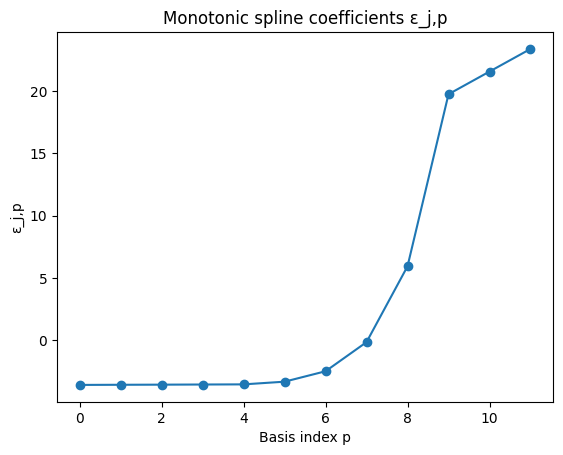

In [25]:
import matplotlib.pyplot as plt

plt.plot(range(len(eps)), eps, marker='o')
plt.title("Monotonic spline coefficients ε_j,p")
plt.xlabel("Basis index p")
plt.ylabel("ε_j,p")
plt.show()

In [26]:
# Monotonic?
is_mono = torch.all(torch.diff(eps) > 0)
print(is_mono)

tensor(True)


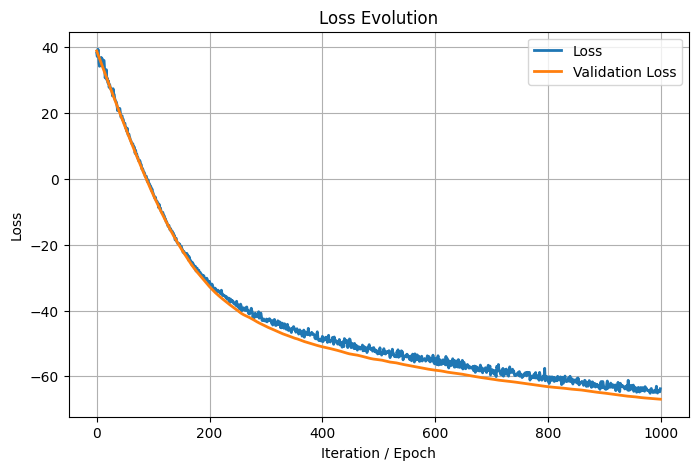

In [27]:
import matplotlib.pyplot as plt
loss_history = output['loss_history']
val_loss = output['val_history']


# Plot            
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="Loss", linewidth=2)
plt.plot(val_loss, label="Validation Loss", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

In [28]:
print(len(output['mu']), sum(p.numel() for p in model.parameters() if p.requires_grad))
print(output['mu'])

24 24
tensor([-3.6929, -4.3924, -4.3864, -4.4740, -4.4817, -2.5615,  1.5123,  1.0952,
         7.4795,  1.6411,  1.6411,  1.6411, -3.5997, -4.4417, -4.6669, -4.4392,
        -4.4684, -1.4235,  0.2700,  2.2371,  6.0885, 13.8166,  1.6411,  1.6411])


In [29]:
import torch

def flat_params(model):
    return torch.cat([p.detach().flatten().cpu() for p in model.parameters()])

# snapshot BEFORE
before = flat_params(model).clone()

model.bayesian_param_set(output, update_buffers=False)
# snapshot AFTER
after = flat_params(model)

max_abs_change = (after - before).abs().max().item()
print(f"Max |Δ| across all parameters: {max_abs_change:.3e}")



Max |Δ| across all parameters: 0.000e+00


In [30]:
# pretrain the marginal transformations
#_ = model.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

In [16]:
# train the joint model
#_ = model.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
#                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
#                max_batches_per_iter=False)

### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [31]:
log_likelihood_train_gtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model.log_likelihood(simulated_data_test)

In [32]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [33]:
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )

print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD GTM      Train Data:  8.4132
KLD Gaussian Train Data:  0.0994
KLD Copula   Train Data:  -0.0005
KLD GTM      Test  Data:  8.3814
KLD Gaussian Test  Data:  0.1092
KLD Copula   Test  Data:  0.0024


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [34]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)

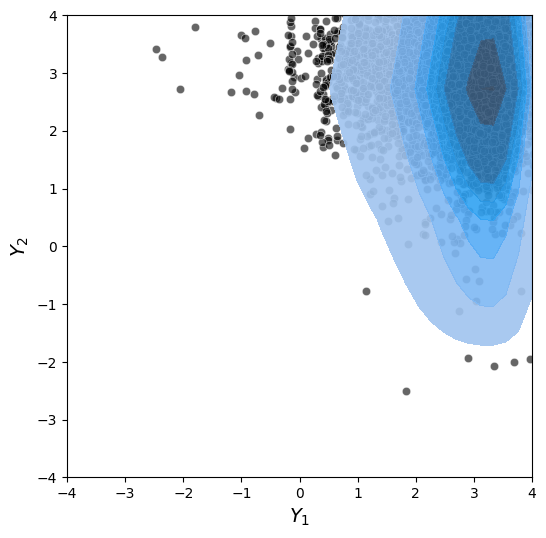

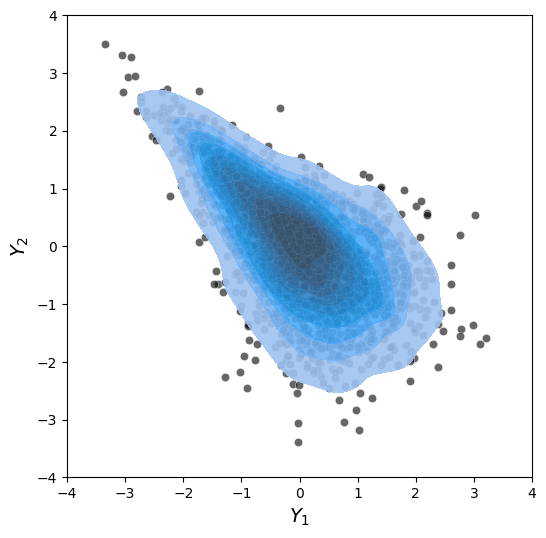

In [21]:
model.plot_densities(synthetic_samples, x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

In [22]:
pseudo_conditional_correlation_matrix = model.compute_pseudo_conditional_correlation_matrix(synthetic_samples)

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

: 

: 

: 

: 

: 

: 

In [ ]:
model.plot_conditional_dependence_structure(data=synthetic_samples)

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

: 

: 

: 

: 

: 

: 

One can also visualize the splines of each layer usign the function `plot_splines`. For the transformation layer we additionally include the dervaitive which is always positive due to the monotonically increasing constraint as well as the inverse which should lie exactly on the spline to visually confirm that the inverse sampling path works.

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


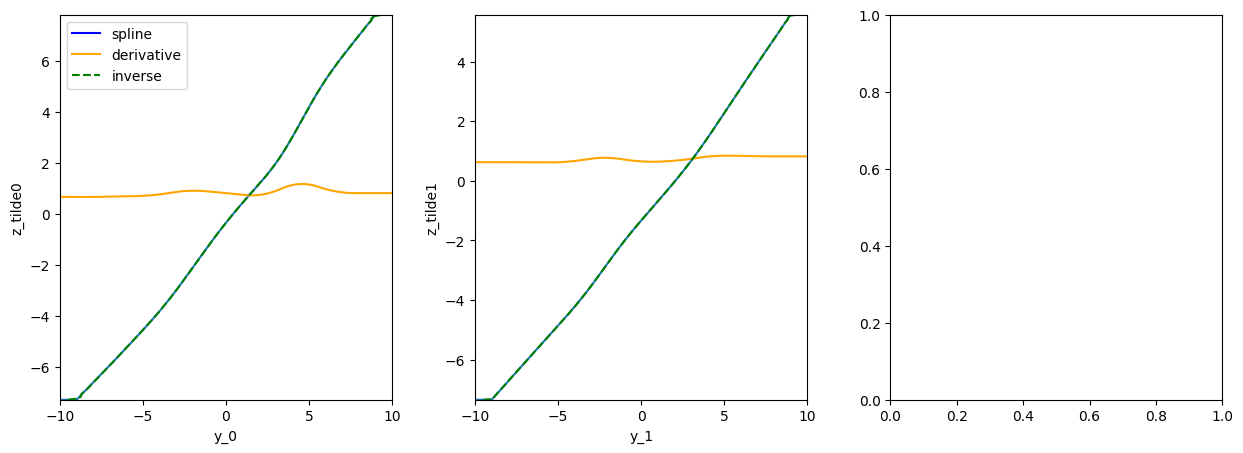

: 

: 

: 

: 

: 

: 

In [ ]:
model.plot_splines(layer_type="transformation")

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


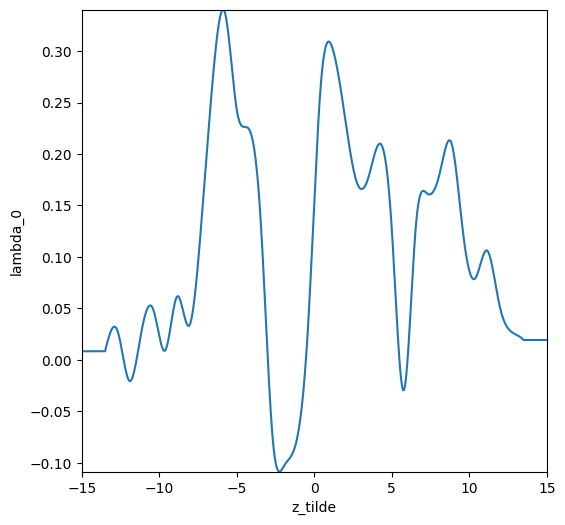

: 

: 

: 

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


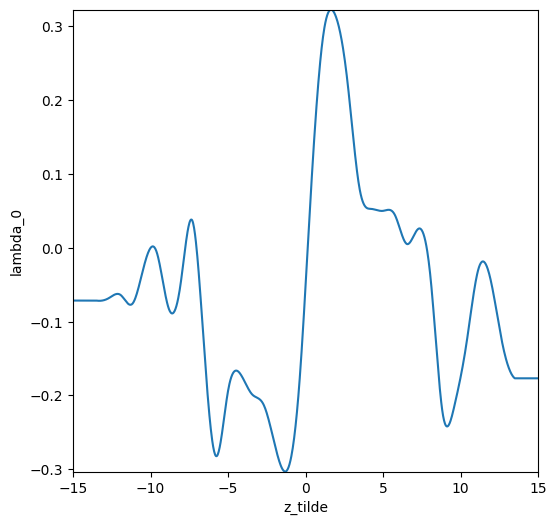

: 

: 

: 

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


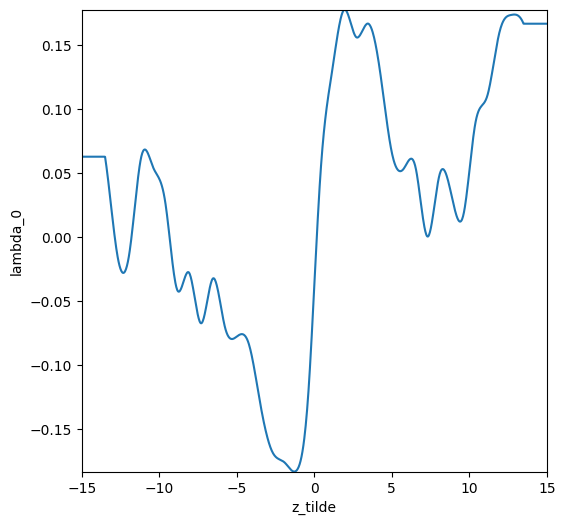

: 

: 

: 

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)